In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
import sklearn
import scipy
import statsmodels
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests
import matplotlib.cm as cm
import etcpy
import evo_etc
from functools import reduce
import multiprocessing

In [2]:
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
dfchemo = pd.read_csv('../data/Chemostat_exp_data.txt',sep='\t',index_col=0)

In [3]:
def boot_strap_ci(data,sampling_time=1000):
    # data is a matrix, we are going to get cis for all columns
    data = np.array(data)
    def _ci_of_a_column(lst):
        means = []
        for _ in range(sampling_time):
            sampled_index = np.random.randint(0,len(lst),size=len(lst)) 
            means.append(np.mean(lst[sampled_index]))
        means.sort()
        return [means[24],means[974]]
    
    cis = list()
    for i in range(data.shape[1]):
        cis.append(_ci_of_a_column(data[:,i]))
    
    return np.array(cis)

In [4]:
!less ../data/enzyme_uniprot_gene_name.csv|grep ADE5

P07244,ADE5,7


In [5]:
def load_gene_names():
    gene_names = dict()
    gene_ids = dict()
    for line in open('../data/enzyme_uniprot_gene_name.csv'):
        cont = line.strip().split(',')
        gene_names[cont[0]] = cont[1]
        gene_ids[cont[1]] = cont[0]
    return gene_names,gene_ids

In [6]:
# Convenient pickle wrappers
def load_pickle(filename):
    return pickle.load(open(file=filename,mode='rb'))

def dump_pickle(obj,filename):
    return pickle.dump(obj=obj,file=open(file=filename, mode='wb'))

### Visualize models from posterior distribution

In [7]:
model_skeleton = load_pickle("../results/permuted_smcabc_res/simulation_skeleton.pkl")

In [8]:
model_skeleton["model"] = list(map(load_pickle,model_skeleton.outfile))

In [9]:
model_frame = model_skeleton.set_index(["origin","status"])

In [10]:
reference_model = model_frame.loc[("unpermuted","original"),"model"]

In [11]:
models = model_frame.model

In [12]:
def plot_lines_prior_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental',zorder=1)
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    for item in model.simulated_data_t0: 
        plt.plot(dfae_batch.index,item['rae'],color='#1f78b4',zorder=0)

    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [13]:
def plot_lines_prior_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental',zorder=1)
    
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    for item in model.simulated_data_t0: 
        plt.plot(ts,item['ran'],zorder=0,color='#1f78b4')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [14]:
def plot_lines_prior_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])

    #rs0 = np.array(rs0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        if i<2: continue
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental',zorder=1)
        for j,r in enumerate(rs0):
            plt.plot(dfchemo.index,r[i*6:(i+1)*6],color='#1f78b4',zorder=0)
        print(j)
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

('unpermuted', 'original')
0.0018241406250000005


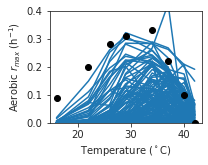

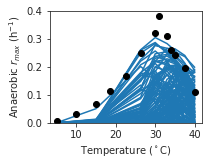

4.260765416666666
127


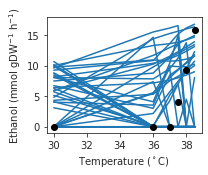

('unpermuted', 'replicate')
0.0018241406250000005


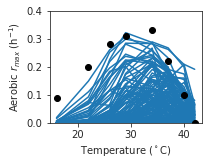

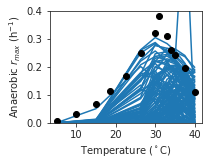

4.260765416666666
127


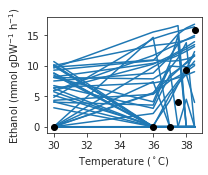

('permuted_0', 'original')
0.0018241406250000005


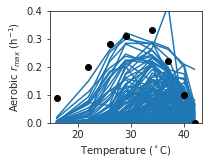

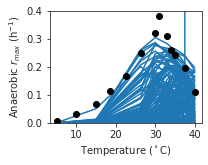

4.260765416666666
127


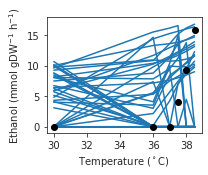

('permuted_0', 'replicate')
0.0018241406250000005


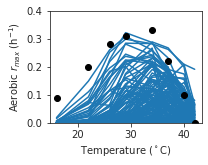

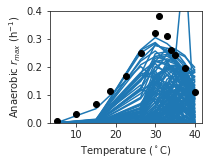

4.260765416666666
127


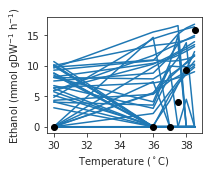

('permuted_1', 'original')
0.0018241406250000005


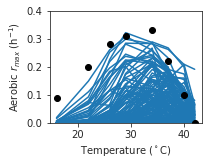

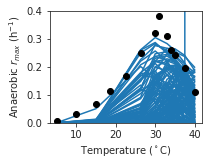

4.260765416666666
127


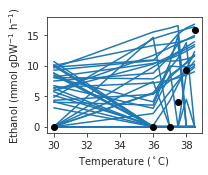

('permuted_1', 'replicate')
0.0018241406250000005


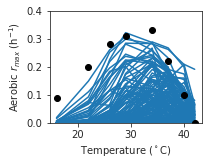

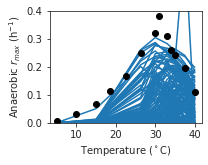

4.260765416666666
127


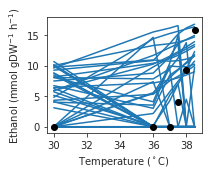

('permuted_2', 'original')
0.0018241406250000005


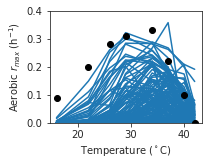

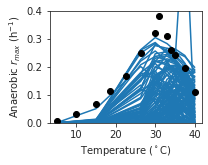

4.260765416666666
127


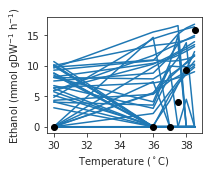

('permuted_2', 'replicate')
0.0018241406250000005


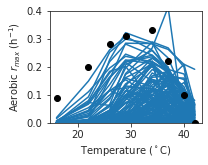

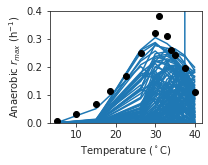

4.260765416666666
127


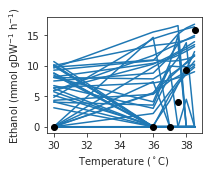

In [15]:
for index, model in models.iteritems():
    print(index)
    plot_lines_prior_ae(model)
    plot_lines_prior_an(model)
    plot_lines_prior_chemostat(model)

In [16]:
!pwd

/home/jakobpp/BayesianGEM/code


In [17]:
def plot_last_population_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental')
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    rs0 = list()
    rs  = list()
    for item in model.simulated_data_t0: rs0.append(item['rae'])
    for item in model.simulated_data: rs.append(item['rae'])

    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    
    plt.plot(dfae_batch.index,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(dfae_batch.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(dfae_batch.index,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(dfae_batch.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [18]:
def plot_last_population_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental')
    
    
    rs0 = list() # prior
    rs = list()  # posterior
    for item in model.simulated_data: rs.append(item['ran'])
    for item in model.simulated_data_t0:rs0.append(item['ran'])
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    print(np.var(dfan_batch.loc[ts,'r_an'])*0.15)
    
    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    plt.plot(ts,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(ts,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(ts,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(ts,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    #plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [19]:
def plot_last_population_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    rs  = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])
    for item in model.simulated_data: rs.append(item['chemostat'])

    #rs0 = np.array(rs0)
    #yt0 = np.mean(rs0,axis=0)
    #yerrt0 = np.std(rs0,axis=0)
    
    #rs = np.array(rs)
    #yt = np.mean(rs,axis=0)
    #yerrt = np.std(rs,axis=0)
    rs0 = np.array(rs0)
    yt0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    yt = np.percentile(rs,[5,50,95],axis=0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental')
        y0 = yt0[:,i*6:(i+1)*6]
        #yerr0 = yerrt0[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y0[1,:],color='#1f78b4',label='prior')
        plt.fill_between(dfchemo.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
        
        y = yt[:,i*6:(i+1)*6]
        #yerr = yerrt[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y[1,:],color='#fc8d59',label='posterior')
        plt.fill_between(dfchemo.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
        
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

In [20]:
def plot_legend_growth():
    plt.figure(figsize=(3,2.4))
    plt.scatter([],[],color='k',label='Exp')
    
    plt.plot([],[],color='#1f78b4',label='Prior')
    plt.fill_between([],[],[],alpha=0.8,color='#1f78b4')
    
    plt.plot([],[],color='#fc8d59',label='Posterior')
    plt.fill_between([],[],[],alpha=0.8,color='#fc8d59')
    
    plt.legend(loc='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../figures/prior_posterior_legend.pdf',transparent=True)
    plt.show()

('unpermuted', 'original')
0.0018241406250000005


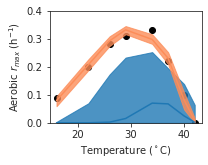

0.0017126156249999997


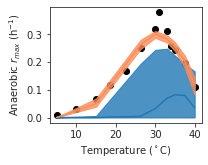

4.260765416666666


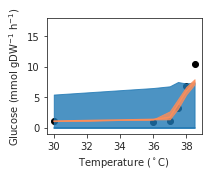

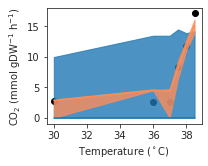

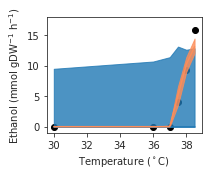

('unpermuted', 'replicate')
0.0018241406250000005


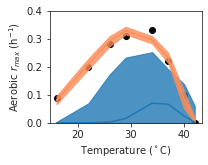

0.0017126156249999997


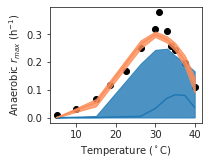

4.260765416666666


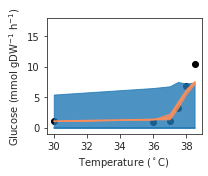

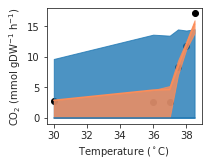

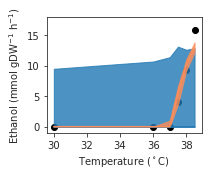

('permuted_0', 'original')
0.0018241406250000005


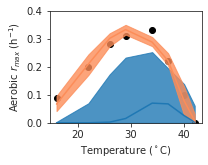

0.0017126156249999997


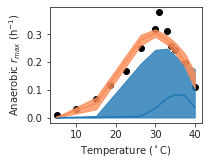

4.260765416666666


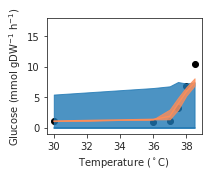

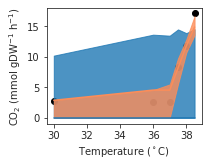

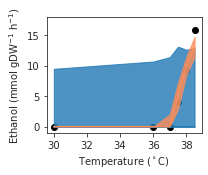

('permuted_0', 'replicate')
0.0018241406250000005


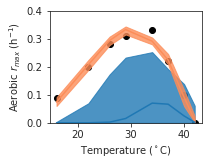

0.0017126156249999997


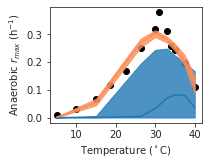

4.260765416666666


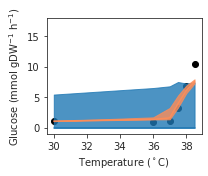

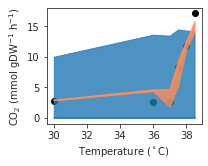

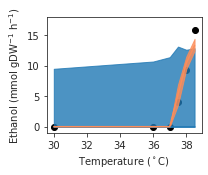

('permuted_1', 'original')
0.0018241406250000005


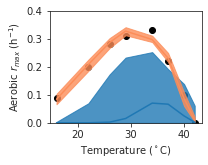

0.0017126156249999997


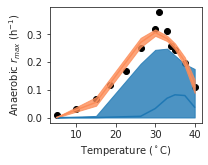

4.260765416666666


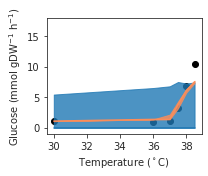

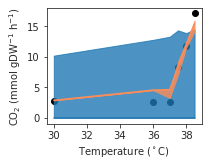

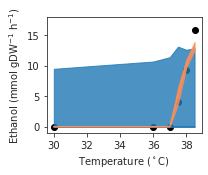

('permuted_1', 'replicate')
0.0018241406250000005


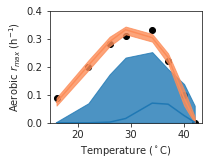

0.0017126156249999997


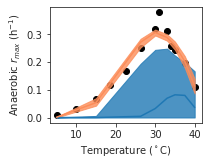

4.260765416666666


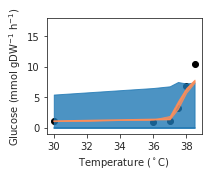

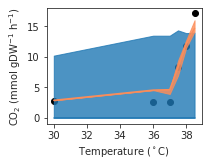

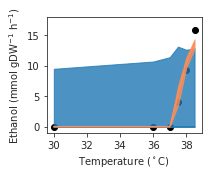

('permuted_2', 'original')
0.0018241406250000005


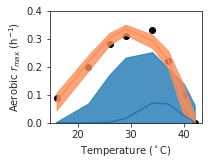

0.0017126156249999997


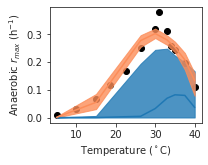

4.260765416666666


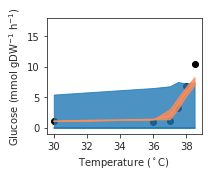

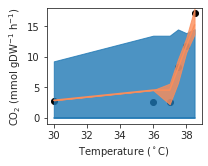

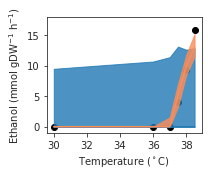

('permuted_2', 'replicate')
0.0018241406250000005


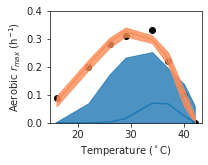

0.0017126156249999997


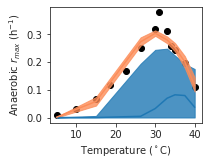

4.260765416666666


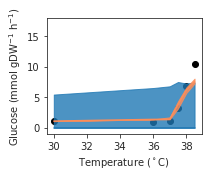

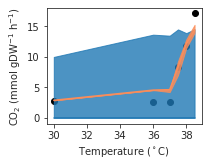

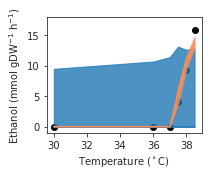

In [21]:
for index, model in models.iteritems():
    print(index)
    plot_last_population_ae(model)
    plot_last_population_an(model)
    plot_last_population_chemostat(model)
    

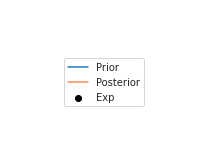

In [22]:
 plot_legend_growth()

### Visualize particle population

In [138]:
def build_a_dataframe_for_all_particles(results, n_priors = 128, r2_threshold = 0.9):
    columns = list(results.all_particles[0].keys())
    columns.sort()
    print("Iterating over particles")
    data = list()
    for p in results.all_particles:
        data.append([p[k] for k in columns])
    print("Creating Data Frame")
    df = pd.DataFrame(data=data,columns=columns)
    df['r2'] = results.all_distances
    print(df.shape)
    
    # Remove samples with a R2 score smaller than -3
    print("Doing filtering and labelling of Data Frame")
    df['r2'] = -df['r2']
    sel_index = df.index[df['r2']>-3]    
    df = df.loc[sel_index,:]
    df["period"] = "Intermediate"
    df.loc[:n_priors,"period"] = "Prior"
    df.loc[df["r2"] > r2_threshold,"period"] = 'Posterior'
    print(df.shape)

    return df

In [ ]:
model_frame["particle_df"] = load_pickle("../results/permuted_smcabc_res/particle_df.pkl")

In [66]:
unique_origins = model_frame.index.get_level_values("origin").unique()

Index(['unpermuted', 'permuted_0', 'permuted_1', 'permuted_2'], dtype='object', name='origin')

In [141]:
combined_df = load_pickle("../results/permuted_smcabc_res/combined_particle_df.pkl")

In [142]:
pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_full_ordination.pkl")

(63139,)
(61724,)
(62675,)
(62990,)
(63474,)
(62980,)
(62952,)
(63087,)


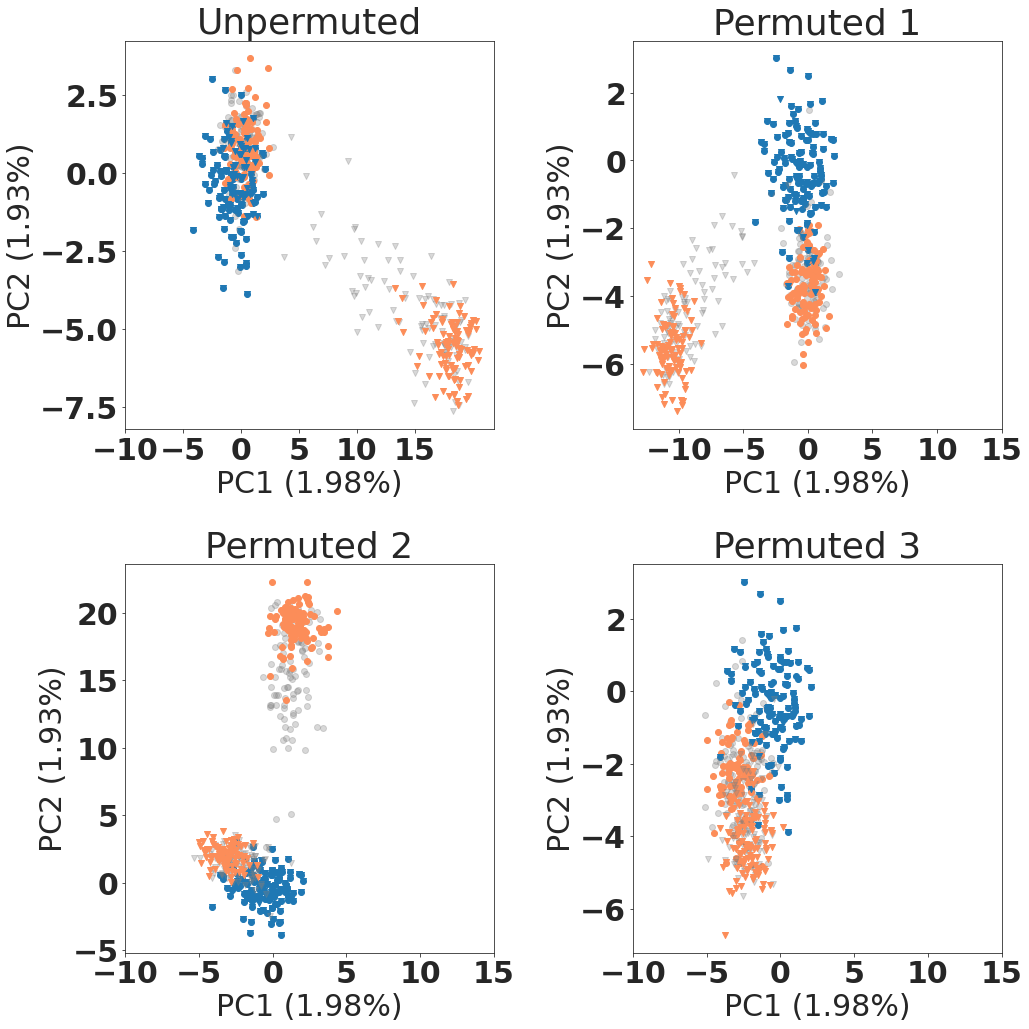

In [163]:
thinning_rng = np.random.default_rng(3052)
i=1
plt.figure(figsize=(15,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df["period"].to_numpy()
prior = combined_df["origin"].to_numpy()
model = combined_df["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
PCS, EV = pca_ordination
for origin in proper_names.keys():
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],color='#1f78b4',label='Prior', marker=marker)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    color='grey',alpha=0.3,label='Intermediate',marker=marker)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    color='#fc8d59',label='Posterior',marker=marker)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-10,20,5))
    plt.title(proper_names[origin])
    plt.tight_layout()
plt.savefig("../figures/pca.png",dpi=300)
plt.show()

## $R^2$ convergence plots

In [23]:
def r2_on_data(Yobs, simulated_data_one):
    r2_diff_dbs = [r2_score(Yobs[db],simulated_data_one[db]) for db in Yobs]
    return np.mean(r2_diff_dbs)

In [24]:
Yobs_batch = GEMS.aerobic_exp_data()
Yobs_chemo = GEMS.chemostat_exp_data()
#Yobs_batch_an = GEMS.anaerobic_exp_data()
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
Yobs_batch_an = {'data':dfan_batch.loc[sel_temp,'r_an'].values}

Yobs = {'rae':Yobs_batch['data'],
        'chemostat':Yobs_chemo['data'],
        'ran':Yobs_batch_an['data']}

In [26]:
def plot_convergence_inner(model, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    # r2s_history = np.array([r2_on_data(Yobs, item) if item is not None else 0 for
    #                         item in model.all_simulated_data[:offset*maxiter]])
    r2s_history = -np.array(model.all_distances[:offset*maxiter])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(model.all_simulated_data):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

In [27]:
def plot_convergence(model, maxiter=100):
    plt.figure(figsize=(3,2.4))
    plot_convergence_inner(model,maxiter)
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.tight_layout()
    plt.show()

In [28]:
def plot_convergence_and_compare(model, reference_model, maxiter=500, legend = True):
    plt.figure(figsize=(3,2.4))
    plot_convergence_inner(model,maxiter, label = 'Original')
    plot_convergence_inner(reference_model,maxiter, label = 'Replicate')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend()
    plt.tight_layout()
    plt.show()

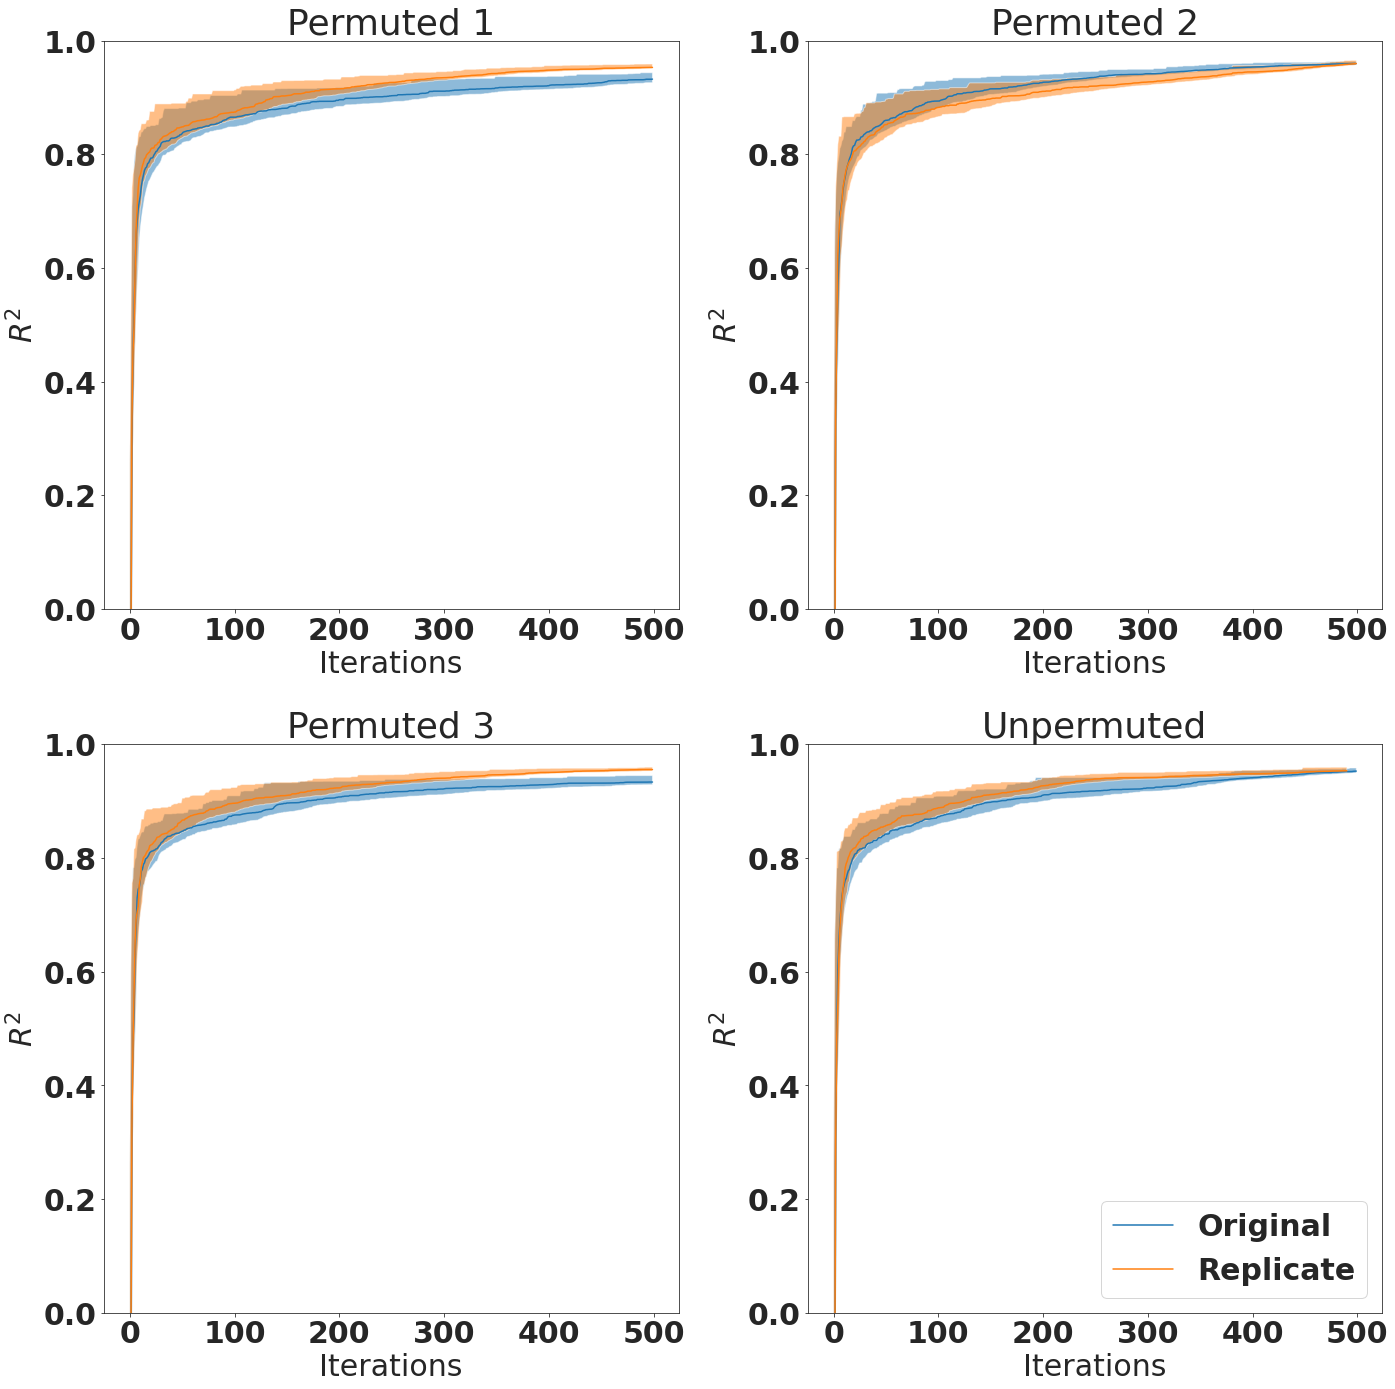

In [68]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
maxiter = 500
i = 1
plt.figure(figsize=(20,20))
for index, series in model_frame["model"].groupby("origin"):
    plt.subplot(2,2,i)
    models = series[index]
    original_model = models["original"]
    replicate_model = models["replicate"]
    plot_convergence_inner(original_model,maxiter, label = 'Original')
    plot_convergence_inner(replicate_model,maxiter, label = 'Replicate')
    if i==4:
        plt.legend()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title(proper_names[index])
    i += 1
plt.tight_layout()
plt.savefig("../figures/R2.pdf")
plt.show()

# Bayesian interpolation experiments

In [14]:
simulator = GEMS.simulate_at_three_conditions_2
distance_function = GEMS.distance_2
Yobs_batch = GEMS.aerobic_exp_data()
Yobs_chemo = GEMS.chemostat_exp_data()
#Yobs_batch_an = GEMS.anaerobic_exp_data()
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
Yobs_batch_an = {'data':dfan_batch.loc[sel_temp,'r_an'].values}
Yobs = {'rae':Yobs_batch['data'],
        'chemostat':Yobs_chemo['data'],
        'ran':Yobs_batch_an['data']}
GEMS.etc.SLACK_FACTOR = 1
model_idx = 1

In [63]:
logger = logging.getLogger()
logger.disabled = True

In [15]:
example_model = model_frame["model"][model_idx]

In [16]:
def evaluate_particle(example_particle_idx):
    example_particle = example_model.all_particles[example_particle_idx]
    stored_sim_res = example_model.all_simulated_data[example_particle_idx]
    true_sim_res = simulator(example_particle)
    return {'stored_res': stored_sim_res, 'sim_res': true_sim_res}

In [17]:
with multiprocessing.Pool(4) as p:
    particle_sim_res = p.map(evaluate_particle, np.random.choice(range(len(example_model.all_particles)),100))

Using license file /opt/gurobi/gurobi.lic
Using license file /opt/gurobi/gurobi.lic
Using license file /opt/gurobi/gurobi.lic
Using license file /opt/gurobi/gurobi.lic


2022-05-02 13:07:18,459 Using license file /opt/gurobi/gurobi.lic
2022-05-02 13:07:18,459 Using license file /opt/gurobi/gurobi.lic
2022-05-02 13:07:18,459 Using license file /opt/gurobi/gurobi.lic


Set parameter TokenServer to value cruncher
Set parameter TokenServer to value cruncher


2022-05-02 13:07:18,459 Using license file /opt/gurobi/gurobi.lic


Set parameter TokenServer to value cruncher


2022-05-02 13:07:18,461 Set parameter TokenServer to value cruncher


Set parameter TokenServer to value cruncher


2022-05-02 13:07:18,461 Set parameter TokenServer to value cruncher
2022-05-02 13:07:18,461 Set parameter TokenServer to value cruncher
2022-05-02 13:07:18,461 Set parameter TokenServer to value cruncher
2022-05-02 13:07:21,321 Model solved successfully


16.0

2022-05-02 13:07:21,322 Model solved successfully


 16.00.11336928918863214 
0.09117837137737529


2022-05-02 13:07:21,386 Model solved successfully


16.0 0.13595375487513595


2022-05-02 13:07:21,958 Model solved successfully


22.0 0.24832388507117092


2022-05-02 13:07:21,970 Model solved successfully


22.0 0.28522130849914273


2022-05-02 13:07:22,003 Model solved successfully


22.0 0.26078565892222283


2022-05-02 13:07:22,019 Model solved successfully


16.0 0.00020169020217903236


2022-05-02 13:07:22,618 Model solved successfully


26.0 0.31964191669168923


2022-05-02 13:07:22,626 Model solved successfully


26.0 0.32828332094864504


2022-05-02 13:07:22,630 Model solved successfully


26.0 0.3530183054759942


2022-05-02 13:07:23,036 Model solved successfully


22.0 0.008423245549211367


2022-05-02 13:07:23,247 Model solved successfully


29.0 0.35779590282147333


2022-05-02 13:07:23,255 Model solved successfully


29.0 0.3425226937554823


2022-05-02 13:07:23,301 Model solved successfully


29.0 0.35674109819051925


2022-05-02 13:07:23,858 Model solved successfully


34.0 0.3197942214955446


2022-05-02 13:07:23,866 Model solved successfully


34.0 0.29109636662195365


2022-05-02 13:07:23,935 Model solved successfully


34.0 0.2775355727270299


2022-05-02 13:07:24,190 Model solved successfully


26.0 0.062404820485462933


2022-05-02 13:07:24,488 Model solved successfully


37.0 0.22789563609806746


2022-05-02 13:07:24,493 Model solved successfully


37.0 0.26408291714419746


2022-05-02 13:07:24,547 Model solved successfully


37.0 0.21421879866507051


2022-05-02 13:07:25,103 Model solved successfully


40.0 0.10533822433559405


2022-05-02 13:07:25,382 Model solved successfully


29.0 0.16798389219496845


2022-05-02 13:07:25,563 Model solved successfully


40.0 0.10658219108848702


2022-05-02 13:07:25,616 Model solved successfully


40.0 0.15383402298197255


2022-05-02 13:07:26,043 Model solved successfully


34.0 0.24007101173037965


2022-05-02 13:07:26,213 Model solved successfully


42.0 0.015198953356384262


2022-05-02 13:07:26,226 rae: [0.11336928918863214, 0.24832388507117092, 0.31964191669168923, 0.3425226937554823, 0.29109636662195365, 0.22789563609806746, 0.10533822433559405, 0.015198953356384262]
2022-05-02 13:07:26,231 r2_batch: 0.9244932052396188
2022-05-02 13:07:26,232 MSE_ae: 0.0009182334119063236
2022-05-02 13:07:26,587 Model solved successfully


42.0 0.03202181895994818


2022-05-02 13:07:26,602 rae: [0.13595375487513595, 0.26078565892222283, 0.32828332094864504, 0.35779590282147333, 0.3197942214955446, 0.26408291714419746, 0.15383402298197255, 0.03202181895994818]
2022-05-02 13:07:26,607 r2_batch: 0.8314960118737361
2022-05-02 13:07:26,608 MSE_ae: 0.0020491664681042375
2022-05-02 13:07:26,682 Model solved successfully


37.0 0.19886089690079095


2022-05-02 13:07:27,345 Model solved successfully


42.0 0.016044847076211843


2022-05-02 13:07:27,360 rae: [0.09117837137737529, 0.28522130849914273, 0.3530183054759942, 0.35674109819051925, 0.2775355727270299, 0.21421879866507051, 0.10658219108848702, 0.016044847076211843]
2022-05-02 13:07:27,365 r2_batch: 0.8163467665298154
2022-05-02 13:07:27,366 MSE_ae: 0.002233395493903823
2022-05-02 13:07:27,798 Model solved successfully


40.0 0.0516001089306527


2022-05-02 13:07:29,623 Model solved successfully


42.0 0.0033452907204603107


2022-05-02 13:07:29,637 rae: [0, 0.008423245549211367, 0.062404820485462933, 0.16798389219496845, 0.24007101173037965, 0.19886089690079095, 0.0516001089306527, 0.0033452907204603107]
2022-05-02 13:07:29,642 r2_batch: -0.26640847905966614
2022-05-02 13:07:29,643 MSE_ae: 0.015400714363314664
2022-05-02 13:07:30,229 Model solved successfully


5.0 0.0023633417806987506


2022-05-02 13:07:30,568 Model solved successfully


5.0 0.00553756549469766


2022-05-02 13:07:30,844 Model solved successfully


15.0 0.0918560439458679


2022-05-02 13:07:31,203 Model solved successfully


15.0 0.10290617115321916


2022-05-02 13:07:31,404 Model solved successfully


5.0 0.00021850683104744504


2022-05-02 13:07:31,454 Model solved successfully


26.30000000000001 0.30174383291013007


2022-05-02 13:07:31,822 Model solved successfully


26.30000000000001 0.2997147665331916


2022-05-02 13:07:32,009 Model solved successfully


15.0 0.0606972257032666


2022-05-02 13:07:32,072 Model solved successfully


30.0 0.3168004590579838


2022-05-02 13:07:32,442 Model solved successfully


30.0 0.3198807955949448


2022-05-02 13:07:32,619 Model solved successfully


26.30000000000001 0.3177126569667979


2022-05-02 13:07:32,704 Model solved successfully


33.0 0.28231517581128707


2022-05-02 13:07:33,061 Model solved successfully


33.0 0.2992591938179754


2022-05-02 13:07:33,329 Model solved successfully


35.0 0.25057893877896203


2022-05-02 13:07:33,398 Model solved successfully


30.0 0.3162775272650685


2022-05-02 13:07:33,692 Model solved successfully


35.0 0.2750670861052812


2022-05-02 13:07:33,974 Model solved successfully


37.5 0.20007285726724255


2022-05-02 13:07:34,036 Model solved successfully


33.0 0.2738974121089627


2022-05-02 13:07:34,285 Model solved successfully


37.5 0.23314965140528232


2022-05-02 13:07:34,300 Model solved successfully


5.0 3.29526515821403e-08


2022-05-02 13:07:34,648 Model solved successfully


40.0 0.13574161342111038


2022-05-02 13:07:34,666 r2_batch_an: 0.9484702202080738
2022-05-02 13:07:34,667 MSE_an: 0.0005883380401630804
2022-05-02 13:07:34,668 Model error: 8 8
2022-05-02 13:07:34,687 Model solved successfully


35.0 0.247244602354967


2022-05-02 13:07:35,323 Model solved successfully


40.0 0.16914577891238547


2022-05-02 13:07:35,339 r2_batch_an: 0.8935676111995032
2022-05-02 13:07:35,341 MSE_an: 0.0012151851471053719
2022-05-02 13:07:35,342 Model error: 8 8
2022-05-02 13:07:35,371 Model solved successfully


37.5 0.2061318903122651


2022-05-02 13:07:35,725 Model solved successfully


15.0 0.00010143092994386056


2022-05-02 13:07:36,466 Model solved successfully


40.0 0.12293698809944502


2022-05-02 13:07:36,481 r2_batch_an: 0.9317665838220759
2022-05-02 13:07:36,482 MSE_an: 0.0007790507646229367
2022-05-02 13:07:36,483 Model error: 8 8
2022-05-02 13:07:36,720 Model solved successfully


26.30000000000001 0.06793466434762786


2022-05-02 13:07:37,609 Model solved successfully


30.0 0.1857104016313921


2022-05-02 13:07:38,270 Model solved successfully


33.0 0.22726186127305276


2022-05-02 13:07:38,882 Model solved successfully


35.0 0.22819483117650863


2022-05-02 13:07:39,491 Model solved successfully


37.5 0.19471225327896124


2022-05-02 13:07:39,549 Model solved successfully
2022-05-02 13:07:40,171 Model solved successfully
2022-05-02 13:07:40,175 Model solved successfully
2022-05-02 13:07:40,496 Model solved successfully


40.0 0.05368714481014702


2022-05-02 13:07:40,511 r2_batch_an: 0.28021643636132365
2022-05-02 13:07:40,513 MSE_an: 0.00821808385137186
2022-05-02 13:07:40,514 Model error: 8 8
2022-05-02 13:07:40,822 Model solved successfully
2022-05-02 13:07:40,826 Model solved successfully
2022-05-02 13:07:41,307 Model solved successfully
2022-05-02 13:07:41,465 Model solved successfully
2022-05-02 13:07:41,465 Model solved successfully
2022-05-02 13:07:41,972 Model solved successfully
2022-05-02 13:07:42,141 Model solved successfully
2022-05-02 13:07:42,156 Model solved successfully
2022-05-02 13:07:42,655 Model solved successfully
2022-05-02 13:07:42,819 Model solved successfully
2022-05-02 13:07:42,845 Model solved successfully
2022-05-02 13:07:42,868 Predicted flux: [1.0773435409751781, 5.750585408888065, 6.690606453219236, 7.1284161319563415, 7.561414675529726, 8.109546921345508, 2.8447170852220682, 11.466184471865061, 12.999483157708305, 13.714295159648756, 14.422170337376244, 15.3591920646027, 0.0, 9.70899191041718, 11

16.0 0.06843376428844854


2022-05-02 13:07:47,549 Model solved successfully
2022-05-02 13:07:47,749 Model solved successfully


16.0 0.12031943663739493


2022-05-02 13:07:47,770 Model solved successfully


22.0 0.19473937280272732


2022-05-02 13:07:48,155 Model solved successfully
2022-05-02 13:07:48,367 Model solved successfully


22.0 0.25965848280592047


2022-05-02 13:07:48,389 Model solved successfully


26.0 0.27024900321879214


2022-05-02 13:07:49,022 Model solved successfully


26.0 0.32858467805307984


2022-05-02 13:07:49,042 Model solved successfully


29.0 0.2785762748551702


2022-05-02 13:07:49,119 Model solved successfully
2022-05-02 13:07:49,141 Predicted flux: [1.0773435409751784, 1.3561496991510014, 2.53827494485032, 3.275437209930854, 4.202079657040612, 5.502169330516622, 2.84471708522211, 4.517554034277028, 0.0, 0.0, 2.4227347689249012, 6.976117009297805, 0.0, 0.0, 0.0, 0.0, 1.7128654774265617, 6.266217432352477]
2022-05-02 13:07:49,144 r2_flux: 0.08731288895759937
2022-05-02 13:07:49,145 MSE_chemo: 25.924971193112466
2022-05-02 13:07:49,207 Model solved successfully


16.0 0.0963456693275089


2022-05-02 13:07:49,636 Model solved successfully


29.0 0.34107245539485054


2022-05-02 13:07:49,681 Model solved successfully


34.0 0.17616183717129733


2022-05-02 13:07:50,261 Model solved successfully


34.0 0.27301081186218934


2022-05-02 13:07:50,277 Model solved successfully


37.0 0.09546035089334083


2022-05-02 13:07:50,286 Model solved successfully


22.0 0.2235131536125279


2022-05-02 13:07:50,880 Model solved successfully
2022-05-02 13:07:50,880 Model solved successfully


40.037.0 0.19013146966991032 
0.024356422342404208


2022-05-02 13:07:51,455 Model solved successfully


26.0 0.3075745869482836


2022-05-02 13:07:51,545 Model solved successfully


40.0 0.03767885768345502


2022-05-02 13:07:51,941 Model solved successfully


42.0 0.0026897689966241586


2022-05-02 13:07:51,954 rae: [0.06843376428844854, 0.19473937280272732, 0.27024900321879214, 0.2785762748551702, 0.17616183717129733, 0.09546035089334083, 0.024356422342404208, 0.0026897689966241586]
2022-05-02 13:07:51,959 r2_batch: 0.5222325642893901
2022-05-02 13:07:51,960 MSE_ae: 0.005810099925211996
2022-05-02 13:07:52,098 Model solved successfully


29.0 0.3470939375469958


2022-05-02 13:07:52,656 Model solved successfully


42.0 0.003184030024386404


2022-05-02 13:07:52,670 rae: [0.12031943663739493, 0.25965848280592047, 0.32858467805307984, 0.34107245539485054, 0.27301081186218934, 0.19013146966991032, 0.03767885768345502, 0.003184030024386404]
2022-05-02 13:07:52,675 r2_batch: 0.8372007634072084
2022-05-02 13:07:52,676 MSE_ae: 0.0019797913412526527
2022-05-02 13:07:52,729 Model solved successfully


34.0 0.3066513575578191


2022-05-02 13:07:53,299 Model solved successfully


16.0 0.05928353606826636


2022-05-02 13:07:53,878 Model solved successfully


37.0 0.006760113842957583


2022-05-02 13:07:53,924 Model solved successfully


22.0 0.17372605600980287


2022-05-02 13:07:54,532 Model solved successfully


26.0 0.24017650848406336


2022-05-02 13:07:55,118 Model solved successfully


29.0 0.2624792656010199


2022-05-02 13:07:55,337 Model solved successfully


40.0 8.609486143932353e-06


2022-05-02 13:07:55,729 Model solved successfully


34.0 0.2950099255688173


2022-05-02 13:07:56,146 Model solved successfully


5.0 0.0009310185209159927


2022-05-02 13:07:56,380 Model solved successfully


37.0 0.23973633053695337


2022-05-02 13:07:56,389 Model solved successfully


42.0 -0.0


2022-05-02 13:07:56,403 rae: [0.0963456693275089, 0.2235131536125279, 0.3075745869482836, 0.3470939375469958, 0.3066513575578191, 0.006760113842957583, 0, 0]
2022-05-02 13:07:56,407 r2_batch: 0.3961622807422278
2022-05-02 13:07:56,409 MSE_ae: 0.007343232764036316
2022-05-02 13:07:56,820 Model solved successfully


15.0 0.05057356642162183


2022-05-02 13:07:56,927 Model solved successfully


5.0 0.0025992167277831225


2022-05-02 13:07:57,411 Model solved successfully


26.30000000000001 0.24739677030318818


2022-05-02 13:07:57,459 Model solved successfully


40.0 0.0034817606064973866


2022-05-02 13:07:57,534 Model solved successfully


15.0 0.08482028486644352


2022-05-02 13:07:58,043 Model solved successfully


30.0 0.246017363944332


2022-05-02 13:07:58,176 Model solved successfully


26.30000000000001 0.29239980223423834


2022-05-02 13:07:58,619 Model solved successfully


42.0 7.355791233891381e-06


2022-05-02 13:07:58,633 rae: [0.05928353606826636, 0.17372605600980287, 0.24017650848406336, 0.2624792656010199, 0.2950099255688173, 0.23973633053695337, 0.0034817606064973866, 0]
2022-05-02 13:07:58,638 r2_batch: 0.8313498594270295
2022-05-02 13:07:58,639 MSE_ae: 0.0020509438188741082
2022-05-02 13:07:58,659 Model solved successfully


33.0 0.19111161667204668


2022-05-02 13:07:58,791 Model solved successfully


30.0 0.302494715347776


2022-05-02 13:07:59,259 Model solved successfully


35.0 0.14227332152454122


2022-05-02 13:07:59,376 Model solved successfully


33.0 0.2667923248203419


2022-05-02 13:07:59,838 Model solved successfully


37.5 0.08409641639249632


2022-05-02 13:08:00,010 Model solved successfully


35.0 0.230604784228594


2022-05-02 13:08:00,450 Model solved successfully


40.0 0.04045418192000897


2022-05-02 13:08:00,464 r2_batch_an: 0.4875569530609488
2022-05-02 13:08:00,466 MSE_an: 0.005850786460736182
2022-05-02 13:08:00,466 Model error: 8 8
2022-05-02 13:08:00,669 Model solved successfully


37.5 0.17143362909952373


2022-05-02 13:08:00,995 Model solved successfully


5.0 0.0011608256877882431


2022-05-02 13:08:01,382 Model solved successfully


40.0 0.07029887610632296


2022-05-02 13:08:01,396 r2_batch_an: 0.9287761351433835
2022-05-02 13:08:01,398 MSE_an: 0.0008131940255088651
2022-05-02 13:08:01,399 Model error: 8 8
2022-05-02 13:08:01,993 Model solved successfully


15.0 0.07286801618717949


2022-05-02 13:08:03,036 Model solved successfully


26.30000000000001 0.2750937208118075


2022-05-02 13:08:03,370 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:08:03,658 Model solved successfully


30.0 0.3115179754180345


2022-05-02 13:08:03,979 Model solved successfully


15.0 0.03696792433227702


2022-05-02 13:08:04,294 Model solved successfully


33.0 0.29827182889804654


2022-05-02 13:08:04,595 Model solved successfully


26.30000000000001 0.21294758064571717


2022-05-02 13:08:05,233 Model solved successfully


30.0 0.23457634526869695


2022-05-02 13:08:05,502 Model solved successfully


35.0 0.19466798334210078


2022-05-02 13:08:05,564 Model solved successfully
2022-05-02 13:08:05,859 Model solved successfully


33.0 0.2650258008655226


2022-05-02 13:08:06,163 Model solved successfully
2022-05-02 13:08:06,189 Model solved successfully
2022-05-02 13:08:06,491 Model solved successfully


35.0 0.2508356767668734


2022-05-02 13:08:06,538 Model solved successfully


37.5 0.0022017370666201803


2022-05-02 13:08:06,710 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:08:06,733 Predicted flux: [1.077343540975179, 3.820631847790604, 0, 0, 0, 0, 2.8447170852220833, 1.4492417685281156, 0, 0, 0, 0, 0.0, 0.7423621648667763, 0, 0, 0, 0]
2022-05-02 13:08:06,736 r2_flux: -1.0252689023120731
2022-05-02 13:08:06,737 MSE_chemo: 57.52797132281161
2022-05-02 13:08:06,839 Model solved successfully
2022-05-02 13:08:07,116 Model solved successfully


37.5 0.198015611970867


2022-05-02 13:08:07,462 Model solved successfully
2022-05-02 13:08:08,070 Model solved successfully
2022-05-02 13:08:08,187 Model solved successfully


40.0 0.003523967875141897


2022-05-02 13:08:08,202 r2_batch_an: 0.7471059536262745
2022-05-02 13:08:08,203 MSE_an: 0.002887401968594112
2022-05-02 13:08:08,204 Model error: 8 8
2022-05-02 13:08:08,680 Model solved successfully
2022-05-02 13:08:08,700 Model solved successfully


40.0 8.609550944102367e-06


2022-05-02 13:08:08,714 r2_batch_an: 0.42410654970809547
2022-05-02 13:08:08,716 MSE_an: 0.006575227475367176
2022-05-02 13:08:08,717 Model error: 8 8
2022-05-02 13:08:09,337 Model solved successfully
2022-05-02 13:08:09,360 Predicted flux: [1.0773435409751824, 1.3813533994898357, 4.848567747112254, 6.5649017401951895, 7.653037075737982, 8.137687804236565, 2.8447170852221277, 4.505526325114998, 10.04726042426844, 12.774903791602341, 15.921296165520904, 16.55140780404929, 0.0, 0.0, 7.712400948888028, 11.497581244469886, 13.18879106413901, 14.32768743037057]
2022-05-02 13:08:09,363 r2_flux: 0.48705958739406896
2022-05-02 13:08:09,364 MSE_chemo: 14.57012513894721
2022-05-02 13:08:10,825 Model solved successfully


16.0 0.1134294817217634


2022-05-02 13:08:11,451 Model solved successfully


22.0 0.280772373852907


2022-05-02 13:08:12,124 Model solved successfully


26.0 0.3501033074971108


2022-05-02 13:08:12,741 Model solved successfully


29.0 0.35515288590927696


2022-05-02 13:08:12,967 Model solved successfully
2022-05-02 13:08:13,357 Model solved successfully


34.0 0.24996888034520404


2022-05-02 13:08:13,385 Model solved successfully


16.0 1.61141434005325e-05


2022-05-02 13:08:13,430 Model solved successfully
2022-05-02 13:08:13,633 Model solved successfully
2022-05-02 13:08:13,973 Model solved successfully


37.0 0.1626560948735728


2022-05-02 13:08:13,999 Model solved successfully


22.0 0.0026449570854771413


2022-05-02 13:08:14,276 Model solved successfully
2022-05-02 13:08:14,374 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:08:14,397 Predicted flux: [1.0773435409751781, 0, 0, 0, 0, 0, 2.844717085222133, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:08:14,399 r2_flux: -1.018991472759509
2022-05-02 13:08:14,401 MSE_chemo: 57.349660291190766
2022-05-02 13:08:14,589 Model solved successfully


40.0 0.057561940124138664


2022-05-02 13:08:14,624 Model solved successfully


26.0 0.047907035500600006


2022-05-02 13:08:14,903 Model solved successfully
2022-05-02 13:08:15,243 Model solved successfully


42.0 0.005499367754650879


2022-05-02 13:08:15,256 rae: [0.1134294817217634, 0.280772373852907, 0.3501033074971108, 0.35515288590927696, 0.24996888034520404, 0.1626560948735728, 0.057561940124138664, 0.005499367754650879]
2022-05-02 13:08:15,256 Model solved successfully


29.0 0.1994598543586332


2022-05-02 13:08:15,261 r2_batch: 0.737366985896113
2022-05-02 13:08:15,262 MSE_ae: 0.003193863669953989
2022-05-02 13:08:15,546 Model solved successfully
2022-05-02 13:08:15,883 Model solved successfully


34.0 0.30161924093791764


2022-05-02 13:08:16,506 Model solved successfully


37.0 0.2393524865267886


2022-05-02 13:08:16,601 Model solved successfully
2022-05-02 13:08:16,626 Predicted flux: [1.0785629938015588, 1.3548939688560369, 1.5578845587951287, 3.76468851634171, 6.537297329496622, 8.137021987831186, 2.852033802180365, 4.510019652507146, 0.0, 0.8390369234877215, 12.850144900719398, 16.61489958591124, 0.0, 0.0, 0.0, 0.16076863197853175, 11.37714745781566, 14.293944090223436]
2022-05-02 13:08:16,629 r2_flux: 0.8138400605398315
2022-05-02 13:08:16,630 MSE_chemo: 5.287892213470976
2022-05-02 13:08:17,188 Model solved successfully


40.0 0.03362202954707613


2022-05-02 13:08:18,378 Model solved successfully


42.0 0.0020603922733629194


2022-05-02 13:08:18,392 rae: [0, 0.0026449570854771413, 0.047907035500600006, 0.1994598543586332, 0.30161924093791764, 0.2393524865267886, 0.03362202954707613, 0.0020603922733629194]
2022-05-02 13:08:18,397 r2_batch: -0.22035767523891936
2022-05-02 13:08:18,399 MSE_ae: 0.014840693416225799
2022-05-02 13:08:18,755 Model solved successfully


16.0 0.14131284109785147


2022-05-02 13:08:19,437 Model solved successfully


5.0 0.0015050537566929359


2022-05-02 13:08:19,789 Model solved successfully


22.0 0.28127122514446434


2022-05-02 13:08:20,038 Model solved successfully


15.0 0.08924189930576264


2022-05-02 13:08:20,654 Model solved successfully


26.30000000000001 0.3201347286908563


2022-05-02 13:08:20,852 Model solved successfully


26.0 0.3499343873868467


2022-05-02 13:08:21,037 Model solved successfully


16.0 0.12518279689685186


2022-05-02 13:08:21,286 Model solved successfully


30.0 0.302086063792559


2022-05-02 13:08:21,655 Model solved successfully


22.0 0.2855419668072307


2022-05-02 13:08:21,889 Model solved successfully


33.0 0.2354372688300386


2022-05-02 13:08:21,913 Model solved successfully


29.0 0.37507405529683663


2022-05-02 13:08:22,280 Model solved successfully


26.0 0.33072630335761677


2022-05-02 13:08:22,505 Model solved successfully


35.0 0.18479352841602165


2022-05-02 13:08:22,938 Model solved successfully


29.0 0.3500195686318402


2022-05-02 13:08:23,023 Model solved successfully


34.0 0.33536874232892305


2022-05-02 13:08:23,128 Model solved successfully


37.5 0.1176752001164089


2022-05-02 13:08:23,178 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:08:23,573 Model solved successfully


34.0 0.2882609226226988


2022-05-02 13:08:23,746 Model solved successfully


40.0 0.05136436075776564


2022-05-02 13:08:23,762 r2_batch_an: 0.7381422717167394
2022-05-02 13:08:23,763 MSE_an: 0.0029897442465661103
2022-05-02 13:08:23,764 Model error: 8 8
2022-05-02 13:08:23,786 Model solved successfully


15.0 6.410262803855237e-06


2022-05-02 13:08:24,076 Model solved successfully


37.0 0.2870643082931433


2022-05-02 13:08:24,218 Model solved successfully


37.0 0.23396136639863804


2022-05-02 13:08:24,426 Model solved successfully


26.30000000000001 0.05600567955357518


2022-05-02 13:08:24,873 Model solved successfully


40.0 0.12284416412163256


2022-05-02 13:08:25,054 Model solved successfully


30.0 0.23106473429801358


2022-05-02 13:08:25,093 Model solved successfully


40.0 0.15523124909518665


2022-05-02 13:08:25,496 Model solved successfully


42.0 0.008941684341471662


2022-05-02 13:08:25,511 rae: [0.12518279689685186, 0.2855419668072307, 0.33072630335761677, 0.3500195686318402, 0.2882609226226988, 0.23396136639863804, 0.12284416412163256, 0.008941684341471662]
2022-05-02 13:08:25,515 r2_batch: 0.8430542372468615
2022-05-02 13:08:25,516 MSE_ae: 0.0019086076117307469
2022-05-02 13:08:25,692 Model solved successfully


33.0 0.2782824560476712


2022-05-02 13:08:26,101 Model solved successfully


42.0 0.03285958733162906


2022-05-02 13:08:26,116 rae: [0.14131284109785147, 0.28127122514446434, 0.3499343873868467, 0.37507405529683663, 0.33536874232892305, 0.2870643082931433, 0.15523124909518665, 0.03285958733162906]
2022-05-02 13:08:26,121 r2_batch: 0.7222648427884724
2022-05-02 13:08:26,122 MSE_ae: 0.0033775198884020627
2022-05-02 13:08:26,301 Model solved successfully


35.0 0.26736098580493917


2022-05-02 13:08:26,956 Model solved successfully


37.5 0.23629057959720745


2022-05-02 13:08:27,610 Model solved successfully


40.0 0.19226953472080394


2022-05-02 13:08:27,626 r2_batch_an: 0.3436581992503779
2022-05-02 13:08:27,627 MSE_an: 0.007493741488696263
2022-05-02 13:08:27,628 Model error: 8 8
2022-05-02 13:08:28,967 Model solved successfully
2022-05-02 13:08:29,640 Model solved successfully
2022-05-02 13:08:30,283 Model solved successfully


5.0 2.235073467105378e-05


2022-05-02 13:08:30,359 Model solved successfully
2022-05-02 13:08:30,821 Model solved successfully


5.0 0.005293524351645075


2022-05-02 13:08:31,071 Model solved successfully
2022-05-02 13:08:31,453 Model solved successfully


15.0 0.0734408726933313


2022-05-02 13:08:31,735 Model solved successfully
2022-05-02 13:08:31,772 Model solved successfully


15.0 0.09846331366205159


2022-05-02 13:08:32,072 Model solved successfully


26.30000000000001 0.29090011441818786


2022-05-02 13:08:32,434 Model solved successfully
2022-05-02 13:08:32,446 Model solved successfully
2022-05-02 13:08:32,457 Predicted flux: [1.077343540975175, 1.354893968856041, 1.3671286510552598, 1.372985200840772, 1.3789559667182427, 1.3851657701860505, 0.0, 4.510019652507299, 4.583427745702552, 4.618567044415688, 4.65439163968043, 4.691650460487267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2022-05-02 13:08:32,460 r2_flux: -0.3733947776778408
2022-05-02 13:08:32,462 MSE_chemo: 39.01141981440233
2022-05-02 13:08:32,697 Model solved successfully


30.0 0.3025912321848111


2022-05-02 13:08:32,815 Model solved successfully


26.30000000000001 0.30881763228324244


2022-05-02 13:08:33,149 Model solved successfully
2022-05-02 13:08:33,331 Model solved successfully


33.0 0.26619665466080583


2022-05-02 13:08:33,833 Model solved successfully
2022-05-02 13:08:33,984 Model solved successfully


35.0 0.23653024241115647


2022-05-02 13:08:33,995 Model solved successfully


30.0 0.3346290460207464


2022-05-02 13:08:34,450 Model solved successfully
2022-05-02 13:08:34,576 Model solved successfully


37.5 0.1933419571692386


2022-05-02 13:08:34,923 Model solved successfully


33.0 0.3150250999536739


2022-05-02 13:08:35,103 Model solved successfully
2022-05-02 13:08:35,203 Model solved successfully


40.0 0.1146853916217907


2022-05-02 13:08:35,219 r2_batch_an: 0.9571522852452563
2022-05-02 13:08:35,220 MSE_an: 0.0004892111052301137
2022-05-02 13:08:35,221 Model error: 8 8
2022-05-02 13:08:35,761 Model solved successfully
2022-05-02 13:08:35,785 Predicted flux: [1.0773435409751744, 1.354893968856037, 1.3671286510552518, 2.418095466142432, 4.858617064195884, 7.154724751319192, 2.8447170852221144, 4.510019652507259, 4.583427745702497, 0.0, 10.114939517816616, 13.813199576585156, 0.0, 0.0, 0.0, 1.534975770335408, 7.708709353364813, 12.747902385350486]
2022-05-02 13:08:35,788 r2_flux: 0.7567242366199153
2022-05-02 13:08:35,789 MSE_chemo: 6.910273062153653
2022-05-02 13:08:35,934 Model solved successfully


35.0 0.29627162584028394


2022-05-02 13:08:36,655 Model solved successfully


16.0 0.0792853031765107


2022-05-02 13:08:37,199 Model solved successfully


37.5 0.2582176845020411


2022-05-02 13:08:37,254 Model solved successfully


22.0 0.21102923565296539


2022-05-02 13:08:37,875 Model solved successfully


26.0 0.2948803486968488


2022-05-02 13:08:38,321 Model solved successfully


40.0 0.1784330739409941


2022-05-02 13:08:38,336 r2_batch_an: 0.8230280904497645
2022-05-02 13:08:38,338 MSE_an: 0.002020565716545466
2022-05-02 13:08:38,339 Model error: 8 8
2022-05-02 13:08:38,488 Model solved successfully


29.0 0.3313370601474918


2022-05-02 13:08:39,091 Model solved successfully


34.0 0.29485412066289496


2022-05-02 13:08:39,713 Model solved successfully


37.0 0.25142748160269157


2022-05-02 13:08:40,066 Model solved successfully
2022-05-02 13:08:40,067 Model solved successfully


16.0 0.026957170338309248


2022-05-02 13:08:40,331 Model solved successfully


40.0 0.17606242862870763


2022-05-02 13:08:40,707 Model solved successfully


22.0 0.21096264216661295


2022-05-02 13:08:40,754 Model solved successfully
2022-05-02 13:08:41,334 Model solved successfully


26.0 0.3189787760354455


2022-05-02 13:08:41,381 Model solved successfully


42.0 0.08803750033174021


2022-05-02 13:08:41,393 rae: [0.0792853031765107, 0.21102923565296539, 0.2948803486968488, 0.3313370601474918, 0.29485412066289496, 0.25142748160269157, 0.17606242862870763, 0.08803750033174021]
2022-05-02 13:08:41,398 r2_batch: 0.82863001281758
2022-05-02 13:08:41,399 MSE_ae: 0.0020840197035012116
2022-05-02 13:08:41,505 Model solved successfully
2022-05-02 13:08:41,976 Model solved successfully


29.0 0.3491769476972594


2022-05-02 13:08:42,224 Model solved successfully
2022-05-02 13:08:42,616 Model solved successfully


34.0 0.30519092810230325


2022-05-02 13:08:42,919 Model solved successfully
2022-05-02 13:08:43,221 Model solved successfully


37.0 0.2531732014096947


2022-05-02 13:08:43,483 Model solved successfully
2022-05-02 13:08:43,611 Model solved successfully
2022-05-02 13:08:43,635 Predicted flux: [1.0773435409751781, 1.354893968856037, 1.3671286510552596, 1.372985200840776, 1.3789559667182545, 1.3851657701860582, 2.844717085222102, 4.510019652507142, 4.583427745702515, 0.0, 0.0, 4.6916504604873746, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2022-05-02 13:08:43,637 r2_flux: -0.6363358710058915
2022-05-02 13:08:43,638 MSE_chemo: 46.480288594886865
2022-05-02 13:08:43,851 Model solved successfully


40.0 0.18547878209055235


2022-05-02 13:08:44,392 Model solved successfully
2022-05-02 13:08:44,971 Model solved successfully


42.0 0.058518105914977483


2022-05-02 13:08:44,989 rae: [0.026957170338309248, 0.21096264216661295, 0.3189787760354455, 0.3491769476972594, 0.30519092810230325, 0.2531732014096947, 0.18547878209055235, 0.058518105914977483]
2022-05-02 13:08:44,994 r2_batch: 0.7985794849813668
2022-05-02 13:08:44,996 MSE_ae: 0.00244946229435941
2022-05-02 13:08:45,343 Model solved successfully
2022-05-02 13:08:45,699 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:08:46,316 Model solved successfully


15.0 0.046606217917448955


2022-05-02 13:08:46,351 Model solved successfully
2022-05-02 13:08:46,908 Model solved successfully


26.30000000000001 0.259435441730925


2022-05-02 13:08:47,400 Model solved successfully
2022-05-02 13:08:47,556 Model solved successfully


30.0 0.29849899913953787


2022-05-02 13:08:47,931 Model solved successfully


16.0 0.06586631503368721


2022-05-02 13:08:48,197 Model solved successfully


33.0 0.28552589900460323


2022-05-02 13:08:48,495 Model solved successfully
2022-05-02 13:08:48,518 Predicted flux: [1.0773435409751742, 1.3548939688560402, 1.3671286510552598, 1.3729852008407675, 2.283996915480433, 3.6881686877148385, 2.8447170852219874, 0.0, 0.0, 0.0, 0.0, 1.2292382372910025, 0.0, 0.0, 0.0, 0.0, 0.0, 4.110549269373046]
2022-05-02 13:08:48,521 r2_flux: -0.5270763741899425
2022-05-02 13:08:48,522 MSE_chemo: 43.37676135838155
2022-05-02 13:08:48,558 Model solved successfully


22.0 0.19360684394555316


2022-05-02 13:08:48,851 Model solved successfully


35.0 0.2652595052064071


2022-05-02 13:08:49,174 Model solved successfully


26.0 0.28714320247047403


2022-05-02 13:08:49,432 Model solved successfully


37.5 0.22880779457021652


2022-05-02 13:08:49,562 Model solved successfully


5.0 1.9919584387874253e-05


2022-05-02 13:08:49,807 Model solved successfully


29.0 0.33356212509649924


2022-05-02 13:08:50,042 Model solved successfully


40.0 0.17328398495141198


2022-05-02 13:08:50,058 r2_batch_an: 0.921771935867257
2022-05-02 13:08:50,059 MSE_an: 0.0008931640329815844
2022-05-02 13:08:50,060 Model error: 8 8
2022-05-02 13:08:50,265 Model solved successfully


15.0 0.015695619254093796


2022-05-02 13:08:50,472 Model solved successfully


34.0 0.31556673551196496


2022-05-02 13:08:50,903 Model solved successfully


26.30000000000001 0.2935365252294529


2022-05-02 13:08:51,108 Model solved successfully


37.0 0.26693711752827576


2022-05-02 13:08:51,504 Model solved successfully


30.0 0.3105536275293836


2022-05-02 13:08:51,747 Model solved successfully


40.0 0.0946388059027978


2022-05-02 13:08:52,111 Model solved successfully


33.0 0.2870049166472576


2022-05-02 13:08:52,718 Model solved successfully


35.0 0.26362785352755846


2022-05-02 13:08:52,780 Model solved successfully


16.0

2022-05-02 13:08:52,782 Model solved successfully


 42.00.06794299378906679 
0.009621820716525212


2022-05-02 13:08:52,795 rae: [0.06586631503368721, 0.19360684394555316, 0.28714320247047403, 0.33356212509649924, 0.31556673551196496, 0.26693711752827576, 0.0946388059027978, 0.009621820716525212]
2022-05-02 13:08:52,800 r2_batch: 0.9613286369093605
2022-05-02 13:08:52,801 MSE_ae: 0.0004702800295850727
2022-05-02 13:08:53,327 Model solved successfully


37.5 0.2259682542963765


2022-05-02 13:08:53,417 Model solved successfully


22.0 0.21952941598384704


2022-05-02 13:08:53,907 Model solved successfully


40.0 0.1751699615127205


2022-05-02 13:08:53,921 r2_batch_an: 0.8818193154086434
2022-05-02 13:08:53,923 MSE_an: 0.0013493205800290268
2022-05-02 13:08:53,923 Model error: 8 8
2022-05-02 13:08:54,013 Model solved successfully


26.0 0.3062457682972268


2022-05-02 13:08:54,640 Model solved successfully


29.0 0.337869406610813


2022-05-02 13:08:54,802 Model solved successfully
2022-05-02 13:08:55,406 Model solved successfully
2022-05-02 13:08:55,656 Model solved successfully


34.0 0.30464366793537073


2022-05-02 13:08:56,015 Model solved successfully
2022-05-02 13:08:56,631 Model solved successfully
2022-05-02 13:08:56,737 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:08:57,245 Model solved successfully
2022-05-02 13:08:57,343 Model solved successfully


15.0 0.03835375076277324


2022-05-02 13:08:57,469 Failed to solve the problem, problem: Solver status is Unbounded


37.0 0


2022-05-02 13:08:57,856 Model solved successfully
2022-05-02 13:08:57,880 Predicted flux: [1.0773435409751708, 4.12351381193624, 5.297201294109126, 5.814069147586714, 6.288893057177701, 6.725248355347033, 2.8447170852220443, 8.852172465283672, 10.75318551170555, 11.592470799243042, 12.366065859955178, 13.08015734106423, 0.0, 6.134783122852421, 8.705339046160091, 9.836299962824128, 10.87397416124103, 11.825994315194492]
2022-05-02 13:08:57,882 r2_flux: 0.31664332742227375
2022-05-02 13:08:57,883 MSE_chemo: 19.41081651845055
2022-05-02 13:08:57,955 Model solved successfully


26.30000000000001 0.24867161408170424


2022-05-02 13:08:58,592 Model solved successfully


30.0 0.2951158815731505


2022-05-02 13:08:58,664 Model solved successfully
2022-05-02 13:08:59,191 Failed to solve the problem, problem: Solver status is Unbounded


40.0 0


2022-05-02 13:08:59,206 Model solved successfully


33.0 0.28431042729634826


2022-05-02 13:08:59,312 Model solved successfully
2022-05-02 13:08:59,809 Model solved successfully


35.0 0.2680401160574465


2022-05-02 13:08:59,927 Model solved successfully
2022-05-02 13:09:00,194 Failed to solve the problem, problem: Solver status is Unbounded


42.0 0


2022-05-02 13:09:00,209 rae: [0.06794299378906679, 0.21952941598384704, 0.3062457682972268, 0.337869406610813, 0.30464366793537073, 0, 0, 0]
2022-05-02 13:09:00,214 r2_batch: 0.36912350131536364
2022-05-02 13:09:00,215 MSE_ae: 0.007672049670722697
2022-05-02 13:09:00,458 Model solved successfully


37.5 0.23684517636422153


2022-05-02 13:09:00,534 Model solved successfully
2022-05-02 13:09:01,098 Model solved successfully


40.0 0.18923467381390582


2022-05-02 13:09:01,113 r2_batch_an: 0.8831342252551557
2022-05-02 13:09:01,115 MSE_an: 0.0013343076790383376
2022-05-02 13:09:01,116 Model error: 8 8
2022-05-02 13:09:01,170 Model solved successfully
2022-05-02 13:09:01,787 Model solved successfully
2022-05-02 13:09:01,811 Predicted flux: [1.0790334271788353, 1.3558833664432193, 2.149336721353741, 2.850986116807883, 3.5461859229518677, 4.225647472621146, 2.8548564024440513, 4.515956038030336, 5.822676842468046, 6.948929896861852, 8.065575157833283, 9.156433640418138, 0.0, 0.0, 1.7269996625126927, 3.2688213216781996, 4.796098109624455, 6.289053517339874]
2022-05-02 13:09:01,814 r2_flux: 0.4934944140653862
2022-05-02 13:09:01,815 MSE_chemo: 14.387343225991259
2022-05-02 13:09:02,201 Model solved successfully


16.0 0.12705480818905304


2022-05-02 13:09:02,831 Model solved successfully


22.0 0.2603426111242215


2022-05-02 13:09:03,438 Model solved successfully


26.0 0.32390473465369635


2022-05-02 13:09:04,080 Model solved successfully


29.0 0.35428087801117875


2022-05-02 13:09:04,099 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:09:04,696 Model solved successfully


34.0 0.3098365128302672


2022-05-02 13:09:04,723 Model solved successfully


15.0 0.04107008017847682


2022-05-02 13:09:05,322 Model solved successfully


37.0 0.24817821384953337


2022-05-02 13:09:05,330 Model solved successfully


26.30000000000001 0.2693248691823391


2022-05-02 13:09:05,903 Model solved successfully
2022-05-02 13:09:05,944 Model solved successfully


30.0 0.30196568069110763


2022-05-02 13:09:06,407 Model solved successfully


40.0 0.05676596105784457


2022-05-02 13:09:06,538 Model solved successfully
2022-05-02 13:09:06,633 Model solved successfully


16.0 2.2751322020477533e-06


2022-05-02 13:09:06,917 Model solved successfully


33.0 0.28692545852667684


2022-05-02 13:09:07,174 Model solved successfully
2022-05-02 13:09:07,494 Model solved successfully


42.0 0.0003717458939458312


2022-05-02 13:09:07,508 rae: [0.12705480818905304, 0.2603426111242215, 0.32390473465369635, 0.35428087801117875, 0.3098365128302672, 0.24817821384953337, 0.05676596105784457, 0]
2022-05-02 13:09:07,513 r2_batch: 0.8769372069020713
2022-05-02 13:09:07,514 MSE_ae: 0.0014965589354393421
2022-05-02 13:09:07,797 Model solved successfully
2022-05-02 13:09:07,898 Model solved successfully


22.0 0.00040524051464896794


2022-05-02 13:09:08,433 Model solved successfully
2022-05-02 13:09:08,540 Model solved successfully


26.0 0.009247183113275582


2022-05-02 13:09:08,748 Model solved successfully


35.0 0.26566189147420105


2022-05-02 13:09:09,090 Model solved successfully
2022-05-02 13:09:09,114 Predicted flux: [1.0773435409751781, 1.3563140393666453, 2.2119846652025386, 4.656989325374594, 6.586218882390397, 7.154864606837784, 2.8447170852220656, 4.518540075570914, 0.0, 9.777457376966094, 13.6722431516158, 18.495941172836872, 0.0, 0.0, 0.0, 7.272567207326209, 11.112862991048777, 10.406951153780401]
2022-05-02 13:09:09,116 r2_flux: 0.853501357755498
2022-05-02 13:09:09,117 MSE_chemo: 4.161308989759977
2022-05-02 13:09:09,214 Model solved successfully


29.0 0.0689980146936245


2022-05-02 13:09:09,828 Model solved successfully


34.0 0.24224629798384734


2022-05-02 13:09:10,448 Model solved successfully


37.0 0.20218258679469056


2022-05-02 13:09:11,638 Model solved successfully


40.0 0.11981077716340123


2022-05-02 13:09:12,219 Model solved successfully


5.0 0.004415590229413608


2022-05-02 13:09:12,668 Model solved successfully


42.0 0.03897067608678697


2022-05-02 13:09:12,683 rae: [0, 0, 0.009247183113275582, 0.0689980146936245, 0.24224629798384734, 0.20218258679469056, 0.11981077716340123, 0.03897067608678697]
2022-05-02 13:09:12,687 r2_batch: -0.9469962501971803
2022-05-02 13:09:12,689 MSE_ae: 0.02367729971138228
2022-05-02 13:09:12,869 Model solved successfully


15.0 0.10146034869554252


2022-05-02 13:09:13,433 Model solved successfully


16.0 0.062176742449221965


2022-05-02 13:09:13,497 Model solved successfully


26.30000000000001 0.2934295486454319


2022-05-02 13:09:14,056 Model solved successfully


22.0 0.18478721966777775


2022-05-02 13:09:14,131 Model solved successfully


30.0 0.3184562333124938


2022-05-02 13:09:14,711 Model solved successfully


26.0 0.27286351157415745


2022-05-02 13:09:14,747 Model solved successfully


33.0 0.2944672163540669


2022-05-02 13:09:15,348 Model solved successfully


35.0

2022-05-02 13:09:15,350 Model solved successfully


29.0  0.26761437842437810.31915660584170785



2022-05-02 13:09:15,690 Failed to solve the problem, problem: Solver status is Unbounded


37.5 0


2022-05-02 13:09:15,961 Model solved successfully


34.0 0.29531351554195556


2022-05-02 13:09:15,997 Model solved successfully


37.5 0.2186600603839242


2022-05-02 13:09:16,587 Model solved successfully


37.0 0.2422578451804985


2022-05-02 13:09:16,697 Failed to solve the problem, problem: Solver status is Infeasible


40.0 0


2022-05-02 13:09:16,711 r2_batch_an: 0.4214331184841188
2022-05-02 13:09:16,713 MSE_an: 0.006605751209277478
2022-05-02 13:09:16,714 Model error: 8 8
2022-05-02 13:09:16,978 Model solved successfully


5.0 1.2075325974336463e-11


2022-05-02 13:09:17,085 Model solved successfully


40.0 0.06318930920923213


2022-05-02 13:09:17,101 r2_batch_an: 0.9262988838365083
2022-05-02 13:09:17,102 MSE_an: 0.0008414778874769059
2022-05-02 13:09:17,103 Model error: 8 8
2022-05-02 13:09:17,210 Model solved successfully


40.0 0.10820693838405679


2022-05-02 13:09:17,887 Model solved successfully


15.0 9.071556787121523e-07


2022-05-02 13:09:18,458 Model solved successfully


42.0 0.01319720701841287


2022-05-02 13:09:18,473 rae: [0.062176742449221965, 0.18478721966777775, 0.27286351157415745, 0.31915660584170785, 0.29531351554195556, 0.2422578451804985, 0.10820693838405679, 0.01319720701841287]
2022-05-02 13:09:18,478 r2_batch: 0.9683369473917028
2022-05-02 13:09:18,479 MSE_ae: 0.0003850524038287136
2022-05-02 13:09:18,571 Model solved successfully


26.30000000000001 0.011489856851098032


2022-05-02 13:09:19,194 Model solved successfully


30.0 0.11140095370225729


2022-05-02 13:09:19,818 Model solved successfully


33.0 0.21245483814873836


2022-05-02 13:09:20,436 Model solved successfully


35.0 0.20828973614930066


2022-05-02 13:09:21,079 Model solved successfully


37.5 0.16484156566313016


2022-05-02 13:09:21,383 Model solved successfully
2022-05-02 13:09:21,915 Model solved successfully
2022-05-02 13:09:22,154 Model solved successfully


40.0 0.10957037483399817


2022-05-02 13:09:22,170 r2_batch_an: -0.27043890312117
2022-05-02 13:09:22,171 MSE_an: 0.014505156773954512
2022-05-02 13:09:22,172 Model error: 8 8
2022-05-02 13:09:22,325 Model solved successfully
2022-05-02 13:09:22,614 Model solved successfully
2022-05-02 13:09:22,766 Model solved successfully


5.0 0.0005977764535809846


2022-05-02 13:09:23,272 Model solved successfully
2022-05-02 13:09:23,421 Model solved successfully


15.0 0.04452732326818365


2022-05-02 13:09:24,000 Model solved successfully
2022-05-02 13:09:24,033 Model solved successfully


26.30000000000001 0.24659938107652785


2022-05-02 13:09:24,219 Model solved successfully
2022-05-02 13:09:24,634 Model solved successfully
2022-05-02 13:09:24,651 Model solved successfully


30.0 0.293019735439094


2022-05-02 13:09:25,257 Model solved successfully
2022-05-02 13:09:25,271 Model solved successfully


33.0 0.2862725603619609


2022-05-02 13:09:25,281 Predicted flux: [1.0773435409751788, 1.3548939688560209, 1.36712865105526, 1.3729852008407755, 1.3860117361388284, 2.6900671726549583, 2.8447170852220633, 4.510019652507053, 4.583427745702526, 4.6185670444156735, 4.6576380881649415, 2.4777068400934104, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2022-05-02 13:09:25,283 r2_flux: -0.43311367005691137
2022-05-02 13:09:25,284 MSE_chemo: 40.70774109020488
2022-05-02 13:09:25,934 Model solved successfully


35.0 0.2675534024764255


2022-05-02 13:09:26,073 Model solved successfully
2022-05-02 13:09:26,544 Model solved successfully


37.5 0.227794382285428


2022-05-02 13:09:27,018 Model solved successfully
2022-05-02 13:09:27,133 Model solved successfully


40.0 0.17255417945330787


2022-05-02 13:09:27,149 r2_batch_an: 0.9197915553470232
2022-05-02 13:09:27,150 MSE_an: 0.0009157749037975725
2022-05-02 13:09:27,151 Model error: 8 8
2022-05-02 13:09:27,684 Model solved successfully
2022-05-02 13:09:27,860 Model solved successfully
2022-05-02 13:09:28,335 Model solved successfully
2022-05-02 13:09:28,930 Model solved successfully
2022-05-02 13:09:28,956 Predicted flux: [1.0773435409751713, 1.354893968856038, 1.3671286510552472, 3.8561074685123335, 6.177859562830981, 7.162652953660312, 2.8447170852220567, 4.510019652507204, 4.583427745702512, 8.478915106281386, 12.9707676197069, 15.373202161720629, 0.0, 0.0, 0.0, 5.457471189807307, 10.238522798325006, 11.956691136941652]
2022-05-02 13:09:28,958 r2_flux: 0.9172749586735087
2022-05-02 13:09:28,959 MSE_chemo: 2.349813301174897
2022-05-02 13:09:28,963 Model solved successfully
2022-05-02 13:09:29,238 Model solved successfully


16.0 0.11846830632730268


2022-05-02 13:09:29,611 Model solved successfully
2022-05-02 13:09:29,862 Model solved successfully


22.0 0.2800913033162756


2022-05-02 13:09:30,250 Model solved successfully
2022-05-02 13:09:30,275 Predicted flux: [1.3240967062642972, 1.3548939688560369, 1.438726392408954, 2.299822143169061, 3.2813255382880118, 4.251517725238006, 0.0, 4.510019652507199, 0.0, 0.0, 5.488257682582641, 8.860653184278002, 0.0, 0.0, 0.0, 0.0, 2.7564590830543647, 6.12885458474973]
2022-05-02 13:09:30,278 r2_flux: 0.22069211536651212
2022-05-02 13:09:30,279 MSE_chemo: 22.13632055854681
2022-05-02 13:09:30,461 Model solved successfully


26.0 0.3455754104521435


2022-05-02 13:09:31,086 Model solved successfully


29.0 0.3648026831798449


2022-05-02 13:09:31,697 Model solved successfully


34.0 0.31286728878210746


2022-05-02 13:09:31,933 Model solved successfully
2022-05-02 13:09:32,338 Model solved successfully


37.0 0.2685238804068841


2022-05-02 13:09:32,564 Model solved successfully
2022-05-02 13:09:33,198 Model solved successfully
2022-05-02 13:09:33,218 Model solved successfully


16.0 0.05677108574488671


2022-05-02 13:09:33,411 Model solved successfully


40.0 0.17556757396025502


2022-05-02 13:09:33,809 Model solved successfully
2022-05-02 13:09:33,870 Model solved successfully


22.0 0.17953807257263932


2022-05-02 13:09:34,367 Model solved successfully


42.0 0.045651626383691524


2022-05-02 13:09:34,381 rae: [0.11846830632730268, 0.2800913033162756, 0.3455754104521435, 0.3648026831798449, 0.31286728878210746, 0.2685238804068841, 0.17556757396025502, 0.045651626383691524]
2022-05-02 13:09:34,386 r2_batch: 0.7433261635785235
2022-05-02 13:09:34,387 MSE_ae: 0.0031213944826068
2022-05-02 13:09:34,426 Model solved successfully
2022-05-02 13:09:34,497 Model solved successfully


26.0 0.2731859848178978


2022-05-02 13:09:34,859 Model solved successfully


16.0 0.02842886445585754


2022-05-02 13:09:35,049 Model solved successfully
2022-05-02 13:09:35,072 Predicted flux: [1.077343540975175, 1.381783525831513, 1.7472766150019339, 2.150150602829944, 2.6211775853367234, 3.3305816034914213, 2.8447170852220784, 4.671356994360076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2022-05-02 13:09:35,075 r2_flux: -0.8240318116746042
2022-05-02 13:09:35,076 MSE_chemo: 51.811811080553326
2022-05-02 13:09:35,105 Model solved successfully


29.0 0.3245179140692364


2022-05-02 13:09:35,737 Model solved successfully


34.0 0.30516322019583586


2022-05-02 13:09:35,996 Model solved successfully


22.0 0.17285718146534404


2022-05-02 13:09:36,376 Model solved successfully


37.0 0.25765715230201336


2022-05-02 13:09:37,000 Model solved successfully


40.0 0.10972415755394874


2022-05-02 13:09:37,095 Model solved successfully


26.0 0.295344767306175


2022-05-02 13:09:38,130 Model solved successfully


42.0 0.012788414068088862


2022-05-02 13:09:38,145 rae: [0.05677108574488671, 0.17953807257263932, 0.2731859848178978, 0.3245179140692364, 0.30516322019583586, 0.25765715230201336, 0.10972415755394874, 0.012788414068088862]
2022-05-02 13:09:38,150 r2_batch: 0.9581335590544687
2022-05-02 13:09:38,151 MSE_ae: 0.0005091351716860471
2022-05-02 13:09:38,157 Model solved successfully


29.0 0.3380703256327633


2022-05-02 13:09:38,542 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:09:39,069 Model solved successfully


16.0 0.040113368140916206


2022-05-02 13:09:39,148 Model solved successfully


15.0 0.07524232604102468


2022-05-02 13:09:39,240 Model solved successfully


34.0 0.28567234183554496


2022-05-02 13:09:39,685 Model solved successfully


22.0 0.1304186833371131


2022-05-02 13:09:39,780 Model solved successfully


26.30000000000001 0.30088431015792616


2022-05-02 13:09:40,287 Model solved successfully


26.0 0.24059154316606926


2022-05-02 13:09:40,396 Model solved successfully


30.0 0.32025843305387125


2022-05-02 13:09:40,473 Model solved successfully


37.0 0.2223186921803709


2022-05-02 13:09:40,903 Model solved successfully


29.0 0.28864014677482824


2022-05-02 13:09:41,014 Model solved successfully


33.0 0.2916213233017621


2022-05-02 13:09:41,111 Model solved successfully


40.0 0.056238265607714145


2022-05-02 13:09:41,622 Model solved successfully


35.0 0.2755819518381417


2022-05-02 13:09:41,954 Model solved successfully


34.0 0.27691544408952956


2022-05-02 13:09:42,183 Model solved successfully


42.0 0.004856289220082695


2022-05-02 13:09:42,196 rae: [0.02842886445585754, 0.17285718146534404, 0.295344767306175, 0.3380703256327633, 0.28567234183554496, 0.2223186921803709, 0.056238265607714145, 0.004856289220082695]
2022-05-02 13:09:42,201 r2_batch: 0.9027610643834757
2022-05-02 13:09:42,202 MSE_ae: 0.001182516618599076
2022-05-02 13:09:42,247 Model solved successfully


37.5 0.2451919921464718


2022-05-02 13:09:42,394 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:09:43,000 Model solved successfully


15.0 0.03236115013565358


2022-05-02 13:09:43,223 Model solved successfully


40.0 0.19997935955018048


2022-05-02 13:09:43,237 r2_batch_an: 0.8404460681839014
2022-05-02 13:09:43,238 MSE_an: 0.0018216970443895668
2022-05-02 13:09:43,239 Model error: 8 8
2022-05-02 13:09:43,480 Failed to solve the problem, problem: Solver status is Unbounded


37.0 0


2022-05-02 13:09:43,654 Model solved successfully


26.30000000000001 0.2325490324197391


2022-05-02 13:09:44,267 Model solved successfully


30.0 0.28873119206032577


2022-05-02 13:09:44,877 Model solved successfully


33.0 0.28189946614229716


2022-05-02 13:09:45,164 Failed to solve the problem, problem: Solver status is Unbounded


40.0 0


2022-05-02 13:09:45,464 Model solved successfully


35.0 0.2618716596647925


2022-05-02 13:09:46,040 Model solved successfully


37.5 0.21923629422810195


2022-05-02 13:09:46,140 Failed to solve the problem, problem: Solver status is Unbounded


42.0 0


2022-05-02 13:09:46,154 rae: [0.040113368140916206, 0.1304186833371131, 0.24059154316606926, 0.28864014677482824, 0.27691544408952956, 0, 0, 0]
2022-05-02 13:09:46,158 r2_batch: 0.2747529174577493
2022-05-02 13:09:46,159 MSE_ae: 0.008819684442853654
2022-05-02 13:09:46,700 Model solved successfully


40.0 0.14266220138836777


2022-05-02 13:09:46,717 r2_batch_an: 0.9422585040305218
2022-05-02 13:09:46,718 MSE_an: 0.0006592599213880191
2022-05-02 13:09:46,719 Model error: 8 8
2022-05-02 13:09:47,066 Model solved successfully


5.0 7.190006827061701e-05


2022-05-02 13:09:48,095 Model solved successfully
2022-05-02 13:09:48,424 Model solved successfully


15.0 0.01853688343539648


2022-05-02 13:09:48,708 Model solved successfully
2022-05-02 13:09:49,364 Model solved successfully
2022-05-02 13:09:49,478 Model solved successfully


26.30000000000001 0.27169886981714225


2022-05-02 13:09:50,040 Model solved successfully
2022-05-02 13:09:50,386 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:09:50,650 Model solved successfully


30.0 0.30261020388872933


2022-05-02 13:09:50,681 Model solved successfully
2022-05-02 13:09:51,016 Model solved successfully


15.0 0.027846633971443196


2022-05-02 13:09:51,322 Model solved successfully
2022-05-02 13:09:51,346 Predicted flux: [1.0773435409751793, 4.468516711757909, 6.5831547538502555, 6.796104950249625, 7.009477623075064, 7.22724629698459, 2.8447170852221255, 9.395119146517226, 16.28224508069959, 16.403411179911235, 16.52596313980172, 16.653421425912327, 0.0, 6.898318481700621, 6.0456037505132025, 7.08384811852632, 8.118980235698007, 9.170675706934112]
2022-05-02 13:09:51,349 r2_flux: -0.04042917796769063
2022-05-02 13:09:51,350 MSE_chemo: 29.553497733171096
2022-05-02 13:09:51,495 Model solved successfully
2022-05-02 13:09:51,630 Model solved successfully


26.30000000000001 0.23524596446560922


2022-05-02 13:09:51,723 Model solved successfully


33.0 0.26881342073246695


2022-05-02 13:09:52,115 Model solved successfully
2022-05-02 13:09:52,255 Model solved successfully


30.0 0.2843782375277083


2022-05-02 13:09:52,746 Model solved successfully
2022-05-02 13:09:52,802 Model solved successfully


35.0 0.24025300888827622


2022-05-02 13:09:52,842 Model solved successfully


33.0 0.2659911405544564


2022-05-02 13:09:53,349 Model solved successfully
2022-05-02 13:09:53,793 Model solved successfully


35.0 0.24413562348873577


2022-05-02 13:09:53,809 Model solved successfully


37.5 0.18959542538279375


2022-05-02 13:09:53,968 Model solved successfully
2022-05-02 13:09:54,396 Model solved successfully


40.0 0.08623227184459804


2022-05-02 13:09:54,413 r2_batch_an: 0.9396801607993874
2022-05-02 13:09:54,415 MSE_an: 0.0006886979940830442
2022-05-02 13:09:54,416 Model error: 8 8
2022-05-02 13:09:54,588 Model solved successfully
2022-05-02 13:09:54,611 Predicted flux: [1.0773435409751784, 1.3555763057380004, 3.678263939576903, 6.166560940384598, 6.574933903445541, 6.8832989852232975, 2.8447170852220878, 4.51411367379897, 8.007236300022655, 12.947805416096822, 16.525348208538045, 16.65304749135911, 0.0, 0.0, 4.885766091671211, 10.216108032790874, 5.511260226274063, 7.106528667520864]
2022-05-02 13:09:54,614 r2_flux: 0.4916149579463871
2022-05-02 13:09:54,615 MSE_chemo: 14.440729370217749
2022-05-02 13:09:54,689 Failed to solve the problem, problem: Solver status is Infeasible


37.5 0


2022-05-02 13:09:55,668 Model solved successfully


40.0 206030.92106413777


2022-05-02 13:09:55,683 r2_batch_an: -464735352127.354
2022-05-02 13:09:55,685 MSE_an: 5306086836.965973
2022-05-02 13:09:55,686 Model error: 8 8
2022-05-02 13:09:55,751 Model solved successfully


16.0 0.09562882581894996


2022-05-02 13:09:56,387 Model solved successfully


22.0 0.22307693820189833


2022-05-02 13:09:57,024 Model solved successfully


26.0 0.29881514007639837


2022-05-02 13:09:57,662 Model solved successfully


29.0 0.3277430746922615


2022-05-02 13:09:58,276 Model solved successfully


34.0 0.2901986792149485


2022-05-02 13:09:58,566 Model solved successfully


16.0 0.06801276838294067


2022-05-02 13:09:58,922 Model solved successfully


37.0 0.21984303180124226


2022-05-02 13:09:59,186 Model solved successfully


22.0 0.19861717676335194


2022-05-02 13:09:59,577 Model solved successfully


40.0 0.028267234083609594


2022-05-02 13:09:59,711 Model solved successfully
2022-05-02 13:09:59,830 Model solved successfully


26.0 0.28412780922140257


2022-05-02 13:10:00,448 Model solved successfully


29.0 0.3273495438366164

2022-05-02 13:10:00,451 Model solved successfully


2022-05-02 13:10:00,670 Model solved successfully


42.0 0.0018006749324248313


2022-05-02 13:10:00,687 rae: [0.09562882581894996, 0.22307693820189833, 0.29881514007639837, 0.3277430746922615, 0.2901986792149485, 0.21984303180124226, 0.028267234083609594, 0.0018006749324248313]
2022-05-02 13:10:00,692 r2_batch: 0.918118392763902
2022-05-02 13:10:00,693 MSE_ae: 0.0009957571079977365
2022-05-02 13:10:00,831 Model solved successfully
2022-05-02 13:10:01,092 Model solved successfully


34.0 0.3065754744510573


2022-05-02 13:10:01,626 Model solved successfully
2022-05-02 13:10:01,745 Model solved successfully


37.0 0.25328176266316643


2022-05-02 13:10:01,762 Model solved successfully
2022-05-02 13:10:02,373 Model solved successfully


40.0 0.10276087128042974


2022-05-02 13:10:02,848 Model solved successfully
2022-05-02 13:10:03,457 Model solved successfully


42.0 0.012019835847413453


2022-05-02 13:10:03,465 Model solved successfully
2022-05-02 13:10:03,471 rae: [0.06801276838294067, 0.19861717676335194, 0.28412780922140257, 0.3273495438366164, 0.3065754744510573, 0.25328176266316643, 0.10276087128042974, 0.012019835847413453]
2022-05-02 13:10:03,475 r2_batch: 0.9731529844864009
2022-05-02 13:10:03,477 MSE_ae: 0.0003264848777224091
2022-05-02 13:10:03,766 Model solved successfully
2022-05-02 13:10:04,085 Model solved successfully
2022-05-02 13:10:04,109 Predicted flux: [1.077343540975181, 1.3548939688560389, 1.3696718116263062, 2.317556586864104, 3.6162360158540237, 5.151151022577304, 2.8447170852220833, 4.510019652507244, 4.598686709128839, 3.2000754033584995, 6.492884593031684, 10.655155634482547, 0.0, 0.0, 0.0, 0.0, 3.7619552369984963, 8.316203170176165]
2022-05-02 13:10:04,111 r2_flux: 0.518612861363638
2022-05-02 13:10:04,113 MSE_chemo: 13.673851148866218
2022-05-02 13:10:04,694 Model solved successfully


5.0 0.002479485452746565


2022-05-02 13:10:04,927 Model solved successfully
2022-05-02 13:10:05,306 Model solved successfully


15.0 0.07528531726287879


2022-05-02 13:10:05,798 Model solved successfully
2022-05-02 13:10:05,936 Model solved successfully


26.30000000000001 0.2753831050098319


2022-05-02 13:10:06,566 Model solved successfully


30.0 0.29701040228100506


2022-05-02 13:10:06,670 Model solved successfully
2022-05-02 13:10:06,694 Predicted flux: [1.077343540975179, 1.3548939688560369, 1.3735250145793223, 3.8909588442914056, 1.3789559667182547, 1.3851657701860502, 2.8447170852220567, 4.510019652507197, 4.621805926846962, 19.726408905119435, 4.65439163968051, 4.691650460487303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2022-05-02 13:10:06,696 r2_flux: -0.5831021709588129
2022-05-02 13:10:06,697 MSE_chemo: 44.968179873808204
2022-05-02 13:10:07,202 Model solved successfully


33.0 0.27456213789933903


2022-05-02 13:10:07,628 Model solved successfully


5.0 0.00031591788422559506


2022-05-02 13:10:07,831 Model solved successfully


35.0 0.2535423879101172


2022-05-02 13:10:08,225 Model solved successfully


15.0 0.04708812491465567


2022-05-02 13:10:08,461 Model solved successfully


37.5 0.2152826855395312


2022-05-02 13:10:08,686 Model solved successfully


16.0 0.07759207015960606


2022-05-02 13:10:08,822 Model solved successfully


26.30000000000001 0.2548494665720065


2022-05-02 13:10:09,099 Model solved successfully


40.0 0.16021858407207054


2022-05-02 13:10:09,115 r2_batch_an: 0.941269157683616
2022-05-02 13:10:09,117 MSE_an: 0.00067055572146967
2022-05-02 13:10:09,118 Model error: 8 8
2022-05-02 13:10:09,328 Model solved successfully


22.0 0.21683151570899567


2022-05-02 13:10:09,418 Model solved successfully


30.0 0.29865131239027065


2022-05-02 13:10:09,965 Model solved successfully


26.0 0.301295143528551


2022-05-02 13:10:10,028 Model solved successfully


33.0 0.28175795749155835


2022-05-02 13:10:10,620 Model solved successfully
2022-05-02 13:10:10,621 Model solved successfully


29.035.0  0.256012288006222440.3352856735508793



2022-05-02 13:10:10,731 Model solved successfully


16.0 0.12898180524406652


2022-05-02 13:10:11,241 Model solved successfully


34.0 0.286128411101106


2022-05-02 13:10:11,249 Model solved successfully


37.5 0.21669448326233448


2022-05-02 13:10:11,348 Model solved successfully


22.0 0.2710711320703302


2022-05-02 13:10:11,850 Model solved successfully


40.0 0.1663268536080713


2022-05-02 13:10:11,866 r2_batch_an: 0.9408347704946042
2022-05-02 13:10:11,868 MSE_an: 0.0006755153100510127
2022-05-02 13:10:11,869 Model error: 8 8
2022-05-02 13:10:11,878 Model solved successfully


37.0 0.2179149760062233


2022-05-02 13:10:11,955 Model solved successfully


26.0 0.33826408543806263


2022-05-02 13:10:12,494 Model solved successfully


40.0 0.06956566602986201


2022-05-02 13:10:12,563 Model solved successfully


29.0 0.3509762074814265


2022-05-02 13:10:13,190 Model solved successfully


34.0 0.2880995919423955


2022-05-02 13:10:13,691 Model solved successfully


42.0 0.006100800014130431


2022-05-02 13:10:13,705 rae: [0.07759207015960606, 0.21683151570899567, 0.301295143528551, 0.3352856735508793, 0.286128411101106, 0.2179149760062233, 0.06956566602986201, 0.006100800014130431]
2022-05-02 13:10:13,710 r2_batch: 0.9545405406512036
2022-05-02 13:10:13,711 MSE_ae: 0.0005528296439245033
2022-05-02 13:10:13,850 Model solved successfully


37.0 0.20846096975169354


2022-05-02 13:10:13,966 Model solved successfully
2022-05-02 13:10:14,447 Model solved successfully


40.0 0.05708190995708178


2022-05-02 13:10:14,697 Model solved successfully
2022-05-02 13:10:15,425 Model solved successfully
2022-05-02 13:10:15,514 Model solved successfully


42.0 0.005836037134185526


2022-05-02 13:10:15,528 rae: [0.12898180524406652, 0.2710711320703302, 0.33826408543806263, 0.3509762074814265, 0.2880995919423955, 0.20846096975169354, 0.05708190995708178, 0.005836037134185526]
2022-05-02 13:10:15,532 r2_batch: 0.84161114858365
2022-05-02 13:10:15,534 MSE_ae: 0.0019261569227710185
2022-05-02 13:10:16,135 Model solved successfully
2022-05-02 13:10:16,571 Model solved successfully
2022-05-02 13:10:16,755 Model solved successfully
2022-05-02 13:10:17,227 Model solved successfully
2022-05-02 13:10:17,383 Model solved successfully
2022-05-02 13:10:17,407 Predicted flux: [1.077343540975179, 1.3548939688560486, 1.3671286510552676, 1.3729852008407764, 3.5298092030775767, 6.792612409438704, 2.844717085221903, 4.510019652507312, 0.0, 4.6185670444156806, 6.383283845064392, 13.186750332562296, 0.0, 0.0, 0.0, 0.0, 3.650604864457689, 11.974789981720479]
2022-05-02 13:10:17,409 r2_flux: 0.6897129609176829
2022-05-02 13:10:17,411 MSE_chemo: 8.81373523574557
2022-05-02 13:10:17,845 M

5.0 0


2022-05-02 13:10:18,447 Model solved successfully
2022-05-02 13:10:19,046 Model solved successfully
2022-05-02 13:10:19,277 Model solved successfully


15.0 0.047322715627359235


2022-05-02 13:10:19,672 Model solved successfully
2022-05-02 13:10:19,696 Predicted flux: [1.077343540975175, 1.354893968856037, 1.4696970035584467, 3.9203986360737964, 6.148036779033966, 7.329575098137112, 2.8447170852220687, 4.5100196525071565, 0.0, 8.625842961182961, 12.207210967914481, 18.040094196374266, 0.0, 0.0, 0.0, 5.6386023473154365, 10.53083277283013, 11.15900611590973]
2022-05-02 13:10:19,698 r2_flux: 0.9069441953741775
2022-05-02 13:10:19,700 MSE_chemo: 2.6432596944652973
2022-05-02 13:10:19,820 Model solved successfully


5.0 0.0031305316810267083


2022-05-02 13:10:19,907 Model solved successfully


26.30000000000001 0.2600992342537117


2022-05-02 13:10:20,456 Model solved successfully


15.0 0.09600892562181995


2022-05-02 13:10:20,530 Model solved successfully


30.0 0.29064356228689725


2022-05-02 13:10:21,093 Model solved successfully


26.30000000000001 0.30937403281820636


2022-05-02 13:10:21,187 Model solved successfully


33.0 0.2626719460226647


2022-05-02 13:10:21,691 Model solved successfully


16.0 0.06628096628501833


2022-05-02 13:10:21,721 Model solved successfully


30.0 0.31608555687103723


2022-05-02 13:10:21,810 Model solved successfully


35.0 0.2327844276899482


2022-05-02 13:10:22,298 Model solved successfully


22.0 0.23124828348756823


2022-05-02 13:10:22,353 Model solved successfully


33.0 0.2806318925887536


2022-05-02 13:10:22,451 Model solved successfully


37.5 0.17837979102572288


2022-05-02 13:10:22,953 Model solved successfully


26.0 0.31717915741642194


2022-05-02 13:10:22,992 Model solved successfully


35.0 0.2468270489941768


2022-05-02 13:10:23,123 Model solved successfully


40.0 0.06618578180690535


2022-05-02 13:10:23,138 r2_batch_an: 0.9352591919350215
2022-05-02 13:10:23,140 MSE_an: 0.0007391741297813875
2022-05-02 13:10:23,141 Model error: 8 8
2022-05-02 13:10:23,618 Model solved successfully


29.0 0.3375897281370443


2022-05-02 13:10:23,628 Model solved successfully


37.5 0.1925202065805079


2022-05-02 13:10:24,245 Model solved successfully


34.0 0.2751093469279827


2022-05-02 13:10:24,264 Model solved successfully


40.0 0.12964637827584116


2022-05-02 13:10:24,280 r2_batch_an: 0.9395237755150307
2022-05-02 13:10:24,281 MSE_an: 0.0006904835132931055
2022-05-02 13:10:24,282 Model error: 8 8
2022-05-02 13:10:24,398 Model solved successfully


16.0 0.07201733701898405


2022-05-02 13:10:25,360 Model solved successfully


37.0 0.2023274056424805


2022-05-02 13:10:25,488 Model solved successfully


22.0 0.1979670635011773


2022-05-02 13:10:26,582 Model solved successfully


26.0 0.26737529486888095


2022-05-02 13:10:26,636 Model solved successfully


40.0 0.08581519149451235


2022-05-02 13:10:27,173 Model solved successfully


29.0 0.31935044847986976


2022-05-02 13:10:27,820 Model solved successfully


34.0 0.2927333720086631


2022-05-02 13:10:27,985 Model solved successfully
2022-05-02 13:10:28,447 Model solved successfully


37.0 0.2384752792887516


2022-05-02 13:10:28,679 Model solved successfully
2022-05-02 13:10:29,096 Model solved successfully


40.0 0.1146676136399369


2022-05-02 13:10:29,182 Model solved successfully
2022-05-02 13:10:29,323 Model solved successfully


42.0 0.016154372298964544


2022-05-02 13:10:29,338 rae: [0.06628096628501833, 0.23124828348756823, 0.31717915741642194, 0.3375897281370443, 0.2751093469279827, 0.2023274056424805, 0.08581519149451235, 0.016154372298964544]
2022-05-02 13:10:29,342 r2_batch: 0.9232171908120586
2022-05-02 13:10:29,343 MSE_ae: 0.0009337509436089825
2022-05-02 13:10:29,373 Model solved successfully
2022-05-02 13:10:29,945 Model solved successfully
2022-05-02 13:10:30,030 Model solved successfully
2022-05-02 13:10:30,244 Model solved successfully


42.0 0.01856489621022426


2022-05-02 13:10:30,258 rae: [0.07201733701898405, 0.1979670635011773, 0.26737529486888095, 0.31935044847986976, 0.2927333720086631, 0.2384752792887516, 0.1146676136399369, 0.01856489621022426]
2022-05-02 13:10:30,262 r2_batch: 0.9705588607688719
2022-05-02 13:10:30,263 MSE_ae: 0.0003580318541185475
2022-05-02 13:10:30,572 Model solved successfully
2022-05-02 13:10:30,665 Model solved successfully
2022-05-02 13:10:31,202 Model solved successfully
2022-05-02 13:10:31,284 Model solved successfully
2022-05-02 13:10:31,307 Predicted flux: [1.0773435409751706, 1.3548939688560362, 1.3671286510552596, 1.3729852008407675, 2.344754981067216, 4.224060287965096, 2.8447170852220607, 0.0, 4.583427745702544, 4.618567044415616, 0.0, 7.987153477760738, 0.0, 0.0, 0.0, 0.0, 0.0, 5.501863741848174]
2022-05-02 13:10:31,310 r2_flux: -0.010116341702064213
2022-05-02 13:10:31,311 MSE_chemo: 28.692458503560026
2022-05-02 13:10:31,836 Model solved successfully
2022-05-02 13:10:32,480 Model solved successfully


5.0 0.0021437360433020853


2022-05-02 13:10:34,001 Model solved successfully


15.0 0.0675746354016502


2022-05-02 13:10:34,508 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:10:34,643 Model solved successfully


26.30000000000001 0.2840562520013297


2022-05-02 13:10:35,266 Model solved successfully


30.0 0.29867544744696223


2022-05-02 13:10:35,621 Model solved successfully


16.0 0.0683218158453678


2022-05-02 13:10:35,685 Model solved successfully


15.0 0.04707987262364384


2022-05-02 13:10:35,874 Model solved successfully


33.0 0.26681809410598256


2022-05-02 13:10:36,287 Model solved successfully


22.0 0.20057292251552125


2022-05-02 13:10:36,682 Model solved successfully


26.30000000000001 0.24106783148864683


2022-05-02 13:10:36,751 Model solved successfully


35.0 0.23402421759926265


2022-05-02 13:10:36,870 Model solved successfully


16.0 0.08669309273502332


2022-05-02 13:10:36,954 Model solved successfully


26.0 0.28929878278566556


2022-05-02 13:10:37,326 Model solved successfully


30.0 0.28477426221689445


2022-05-02 13:10:37,476 Model solved successfully


22.0 0.22587675142671906


2022-05-02 13:10:37,578 Model solved successfully


29.0 0.3283793493777247


2022-05-02 13:10:37,840 Model solved successfully


37.5 0.1786810219080685


2022-05-02 13:10:37,938 Model solved successfully


33.0 0.26925536190790783


2022-05-02 13:10:38,123 Model solved successfully


26.0 0.3024655010538034


2022-05-02 13:10:38,577 Model solved successfully


35.0 0.24602462063667213


2022-05-02 13:10:38,744 Model solved successfully


34.0

2022-05-02 13:10:38,747 Model solved successfully


 0.0641696697141658129.0 
0.32727173761562867


2022-05-02 13:10:39,212 Model solved successfully


37.5 0.20480195658042422


2022-05-02 13:10:39,373 Model solved successfully


34.0 0.32008171524143697


2022-05-02 13:10:39,817 Model solved successfully


40.0 0.10912495404686935


2022-05-02 13:10:39,823 Model solved successfully


40.0 0.1500969244683097


2022-05-02 13:10:39,834 r2_batch_an: 0.9592712503081551
2022-05-02 13:10:39,835 MSE_an: 0.000465017954059783
2022-05-02 13:10:39,836 Model error: 8 8
2022-05-02 13:10:39,837 r2_batch_an: 0.9455512875088892
2022-05-02 13:10:39,838 MSE_an: 0.0006216647718227275
2022-05-02 13:10:39,839 Model error: 8 8
2022-05-02 13:10:39,996 Model solved successfully


37.0 0.2899954721156663


2022-05-02 13:10:40,579 Model solved successfully


37.0 5.692137670855289e-07


2022-05-02 13:10:40,603 Model solved successfully


40.0 0.14885918440223977


2022-05-02 13:10:41,265 Model solved successfully


42.0 0.025293881786106125


2022-05-02 13:10:41,279 rae: [0.08669309273502332, 0.22587675142671906, 0.3024655010538034, 0.32727173761562867, 0.32008171524143697, 0.2899954721156663, 0.14885918440223977, 0.025293881786106125]
2022-05-02 13:10:41,284 r2_batch: 0.902266042364852
2022-05-02 13:10:41,286 MSE_ae: 0.0011885365504286831
2022-05-02 13:10:41,463 Model solved successfully


40.0 -0.0


2022-05-02 13:10:42,223 Model solved successfully


42.0 -0.0


2022-05-02 13:10:42,237 rae: [0.0683218158453678, 0.20057292251552125, 0.28929878278566556, 0.3283793493777247, 0.06416966971416581, 0, 0, 0]
2022-05-02 13:10:42,241 r2_batch: -0.3358376384753443
2022-05-02 13:10:42,243 MSE_ae: 0.016245038031646262
2022-05-02 13:10:44,647 Model solved successfully
2022-05-02 13:10:44,776 Model solved successfully
2022-05-02 13:10:45,307 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:10:45,324 Model solved successfully
2022-05-02 13:10:45,399 Model solved successfully
2022-05-02 13:10:45,950 Model solved successfully
2022-05-02 13:10:45,949 Model solved successfully


15.0 0.06026702375583316


2022-05-02 13:10:46,391 Model solved successfully
2022-05-02 13:10:46,595 Model solved successfully


26.30000000000001 0.2709689515838628


2022-05-02 13:10:46,614 Model solved successfully
2022-05-02 13:10:46,753 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:10:47,245 Model solved successfully


30.0 0.2914721379352713


2022-05-02 13:10:47,262 Model solved successfully
2022-05-02 13:10:47,376 Model solved successfully


15.0 0.04541064032688633


2022-05-02 13:10:47,466 Model solved successfully
2022-05-02 13:10:47,914 Model solved successfully


33.0 0.28736794465347754


2022-05-02 13:10:47,930 Model solved successfully
2022-05-02 13:10:47,954 Predicted flux: [1.0773435409751781, 1.3548939688560324, 3.0214386096342114, 5.14799463382859, 6.885449292224461, 7.706534540570118, 2.8447170852221024, 4.510019652507181, 5.411130235668893, 10.55046841844389, 13.311846962585204, 17.286483273120943, 0.0, 0.0, 2.45312745273349, 8.359077611949319, 12.190752315066272, 12.666689904835392]
2022-05-02 13:10:47,957 r2_flux: 0.848520602429353
2022-05-02 13:10:47,958 MSE_chemo: 4.302787856710087
2022-05-02 13:10:48,023 Model solved successfully


26.30000000000001 0.27024920832914895


2022-05-02 13:10:48,621 Model solved successfully
2022-05-02 13:10:48,661 Model solved successfully


30.0 0.3070291590061115


2022-05-02 13:10:48,786 Model solved successfully


35.0 0.2798002824165975


2022-05-02 13:10:49,265 Model solved successfully


33.0 0.27490601790145397


2022-05-02 13:10:49,389 Model solved successfully


37.5 0.25692645499437233


2022-05-02 13:10:49,712 Model solved successfully
2022-05-02 13:10:49,737 Predicted flux: [1.0773435409751781, 3.1592359958612923, 6.88023013286949, 7.125302838289586, 7.3852148898872905, 7.669619829388762, 2.844717085222087, 7.143929943172414, 8.003623347946965, 8.863850533096546, 9.780898664789792, 10.79106013668455, 0.0, 3.7793961240622327, 9.735795366614362, 10.595940266049615, 11.512893630403344, 12.523055102298098]
2022-05-02 13:10:49,740 r2_flux: 0.36589138067883975
2022-05-02 13:10:49,741 MSE_chemo: 18.011920504092316
2022-05-02 13:10:50,060 Model solved successfully


40.0 0.20637722192293464


2022-05-02 13:10:50,075 r2_batch_an: 0.8231894579982346
2022-05-02 13:10:50,077 MSE_an: 0.002018723312646281
2022-05-02 13:10:50,078 Model error: 8 8
2022-05-02 13:10:50,608 Model solved successfully


35.0 0.0015433638207573586


2022-05-02 13:10:52,131 Model solved successfully


16.0 0.09282837352005871


2022-05-02 13:10:52,275 Model solved successfully


37.5 8.043004357024497e-08


2022-05-02 13:10:52,805 Model solved successfully


22.0 0.2362290758358234


2022-05-02 13:10:52,939 Model solved successfully


40.0 -0.0


2022-05-02 13:10:52,954 r2_batch_an: -0.20928374660209048
2022-05-02 13:10:52,956 MSE_an: 0.013806921596595204
2022-05-02 13:10:52,957 Model error: 8 8
2022-05-02 13:10:53,436 Model solved successfully


26.0 0.3166305705826233


2022-05-02 13:10:54,047 Model solved successfully


29.0 0.3470376918084987


2022-05-02 13:10:54,181 Model solved successfully


16.0 0.06827587908325711


2022-05-02 13:10:54,653 Model solved successfully


34.0 0.31335962171137327


2022-05-02 13:10:54,929 Model solved successfully
2022-05-02 13:10:55,287 Model solved successfully


37.0 0.25665208339099715


2022-05-02 13:10:55,442 Model solved successfully


22.0 0.18559391092415467


2022-05-02 13:10:55,606 Model solved successfully
2022-05-02 13:10:55,925 Model solved successfully


40.0 0.13984352317125323


2022-05-02 13:10:56,309 Model solved successfully
2022-05-02 13:10:56,492 Model solved successfully


26.0 0.2736792741940167


2022-05-02 13:10:56,992 Model solved successfully
2022-05-02 13:10:57,032 Model solved successfully


42.0 0.02975131387095185


2022-05-02 13:10:57,045 rae: [0.09282837352005871, 0.2362290758358234, 0.3166305705826233, 0.3470376918084987, 0.31335962171137327, 0.25665208339099715, 0.13984352317125323, 0.02975131387095185]
2022-05-02 13:10:57,049 r2_batch: 0.9164634781381783
2022-05-02 13:10:57,050 MSE_ae: 0.0010158824213289978
2022-05-02 13:10:57,531 Model solved successfully


29.0 0.3146425057289231


2022-05-02 13:10:57,713 Model solved successfully
2022-05-02 13:10:57,864 Model solved successfully
2022-05-02 13:10:58,386 Model solved successfully
2022-05-02 13:10:58,412 Predicted flux: [1.0773435409751781, 1.3548939688560369, 1.3671286510552558, 1.372985200840775, 1.3789559667182507, 2.49722936076149, 2.844717085222112, 4.510019652507219, 0.0, 0.0, 4.654391639680484, 2.8043919707277785, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2022-05-02 13:10:58,415 r2_flux: -0.5321502680692041
2022-05-02 13:10:58,416 MSE_chemo: 43.52088583550551
2022-05-02 13:10:58,692 Model solved successfully


34.0 0.28598179109275396


2022-05-02 13:10:59,780 Model solved successfully


37.0 0.22620873624208424


2022-05-02 13:10:59,877 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:10:59,900 Predicted flux: [1.0773435409751786, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:10:59,903 r2_flux: -1.03365361597979
2022-05-02 13:10:59,904 MSE_chemo: 57.766139976305354
2022-05-02 13:11:00,958 Model solved successfully


40.0 0.049126587817848115


2022-05-02 13:11:01,283 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:11:01,906 Model solved successfully


15.0 0.04767938679196582


2022-05-02 13:11:02,050 Model solved successfully


42.0 0.0034428903235956747


2022-05-02 13:11:02,066 rae: [0.06827587908325711, 0.18559391092415467, 0.2736792741940167, 0.3146425057289231, 0.28598179109275396, 0.22620873624208424, 0.049126587817848115, 0.0034428903235956747]
2022-05-02 13:11:02,070 r2_batch: 0.9453466689123976
2022-05-02 13:11:02,071 MSE_ae: 0.0006646357435231399
2022-05-02 13:11:02,504 Model solved successfully


16.0 0.051853579056283204


2022-05-02 13:11:02,513 Model solved successfully


26.30000000000001 0.2808629433620927


2022-05-02 13:11:03,139 Model solved successfully


22.0 0.18040123677630743


2022-05-02 13:11:03,211 Model solved successfully


30.0 0.3137708363115922


2022-05-02 13:11:03,755 Model solved successfully


26.0 0.2793124583441099


2022-05-02 13:11:03,871 Model solved successfully


33.0 0.2917245443473549


2022-05-02 13:11:03,957 Model solved successfully


16.0 0.041750376764889546


2022-05-02 13:11:04,403 Model solved successfully


29.0 0.32777135003525965


2022-05-02 13:11:04,524 Model solved successfully


35.0 0.265999662186501


2022-05-02 13:11:04,577 Model solved successfully


22.0 0.16015208128872835


2022-05-02 13:11:05,055 Model solved successfully


34.0 0.3022999986021711


2022-05-02 13:11:05,140 Model solved successfully


37.5 0.22248995025783086


2022-05-02 13:11:05,228 Model solved successfully


26.0 0.2576505774598174


2022-05-02 13:11:05,694 Model solved successfully


37.0 0.25494419054710493


2022-05-02 13:11:05,739 Model solved successfully


40.0 0.15752408728720455


2022-05-02 13:11:05,754 r2_batch_an: 0.9425067362623996
2022-05-02 13:11:05,755 MSE_an: 0.0006564257453950694
2022-05-02 13:11:05,756 Model error: 8 8
2022-05-02 13:11:05,865 Model solved successfully


29.0 0.3130726466371493


2022-05-02 13:11:06,492 Model solved successfully


34.0 0.30569121906185


2022-05-02 13:11:06,764 Model solved successfully


40.0 0.14380394120967863


2022-05-02 13:11:06,992 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:11:07,143 Model solved successfully


37.0 0.2663110292409928


2022-05-02 13:11:07,950 Model solved successfully


15.0 0.030141042259379372


2022-05-02 13:11:08,110 Model solved successfully


42.0 0.024029537159579065


2022-05-02 13:11:08,124 rae: [0.051853579056283204, 0.18040123677630743, 0.2793124583441099, 0.32777135003525965, 0.3022999986021711, 0.25494419054710493, 0.14380394120967863, 0.024029537159579065]
2022-05-02 13:11:08,129 r2_batch: 0.9317471926161678
2022-05-02 13:11:08,130 MSE_ae: 0.0008300181247943225
2022-05-02 13:11:08,204 Model solved successfully


40.0 0.08926160437654887


2022-05-02 13:11:08,833 Model solved successfully


26.30000000000001 0.2390578043869504


2022-05-02 13:11:09,432 Model solved successfully


42.0 0.007544659916325393


2022-05-02 13:11:09,449 rae: [0.041750376764889546, 0.16015208128872835, 0.2576505774598174, 0.3130726466371493, 0.30569121906185, 0.2663110292409928, 0.08926160437654887, 0.007544659916325393]
2022-05-02 13:11:09,454 r2_batch: 0.9246287148188159
2022-05-02 13:11:09,456 MSE_ae: 0.0009165854883830566
2022-05-02 13:11:09,870 Model solved successfully


30.0 0.27747094331640265


2022-05-02 13:11:10,636 Model solved successfully
2022-05-02 13:11:10,922 Model solved successfully


33.0 0.2568802434646925


2022-05-02 13:11:11,307 Model solved successfully
2022-05-02 13:11:11,955 Model solved successfully
2022-05-02 13:11:11,975 Model solved successfully


35.0 0.23522226001509117


2022-05-02 13:11:12,414 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:11:12,586 Model solved successfully
2022-05-02 13:11:13,039 Model solved successfully


15.0 0.034889753427758186


2022-05-02 13:11:13,047 Model solved successfully


37.5 0.19442071986122342


2022-05-02 13:11:13,220 Model solved successfully
2022-05-02 13:11:13,657 Model solved successfully


26.30000000000001 0.2560643159088207


2022-05-02 13:11:13,739 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:11:13,851 Model solved successfully
2022-05-02 13:11:13,875 Predicted flux: [1.0773435409751793, 1.3548939688560324, 1.4308364748296087, 3.7729923328202424, 5.951005837892289, 7.03943514026164, 2.844717085222097, 4.510019652507375, 4.564550361203429, 8.275994789343153, 11.83518884210189, 16.60031134233012, 0.0, 0.0, 0.0, 5.197561807045851, 10.12575101231141, 8.147585545720325]
2022-05-02 13:11:13,878 r2_flux: 0.8398223035267997
2022-05-02 13:11:13,880 MSE_chemo: 4.549863931028948
2022-05-02 13:11:14,107 Model solved successfully


40.0 0.12964877465795302


2022-05-02 13:11:14,122 r2_batch_an: 0.9293600904603722
2022-05-02 13:11:14,123 MSE_an: 0.0008065267521743542
2022-05-02 13:11:14,124 Model error: 8 8
2022-05-02 13:11:14,251 Model solved successfully


30.0 0.2995644830392356


2022-05-02 13:11:14,348 Model solved successfully


15.0 0.02287167989671532


2022-05-02 13:11:14,898 Model solved successfully


33.0 0.28441661376317484


2022-05-02 13:11:15,022 Model solved successfully


26.30000000000001 0.22317505916276853


2022-05-02 13:11:15,529 Model solved successfully


35.0 0.2642520900962633


2022-05-02 13:11:15,650 Model solved successfully


30.0 0.28459228565313077


2022-05-02 13:11:16,150 Model solved successfully


37.5 0.22817936332945368


2022-05-02 13:11:16,251 Model solved successfully


33.0 0.28779159948442046


2022-05-02 13:11:16,854 Model solved successfully


35.0 0.2772649064592187


2022-05-02 13:11:17,188 Model solved successfully


40.0 0.17177753395843906


2022-05-02 13:11:17,205 r2_batch_an: 0.9182272636418303
2022-05-02 13:11:17,206 MSE_an: 0.0009336351065733802
2022-05-02 13:11:17,207 Model error: 8 8
2022-05-02 13:11:17,459 Model solved successfully


37.5 0.2472990271524682


2022-05-02 13:11:17,972 Model solved successfully


16.0 0.09053573390384975


2022-05-02 13:11:18,591 Model solved successfully


40.0 0.15917256100709318


2022-05-02 13:11:18,607 r2_batch_an: 0.882271883599925
2022-05-02 13:11:18,609 MSE_an: 0.0013441534109905808
2022-05-02 13:11:18,610 Model error: 8 8
2022-05-02 13:11:18,623 Model solved successfully


22.0 0.20888231237676994


2022-05-02 13:11:19,293 Model solved successfully


26.0 0.28126031410562075


2022-05-02 13:11:19,566 Model solved successfully
2022-05-02 13:11:19,984 Model solved successfully


29.0 0.3114827001534882


2022-05-02 13:11:20,542 Model solved successfully
2022-05-02 13:11:20,613 Model solved successfully


34.0 0.2961338889399001


2022-05-02 13:11:21,265 Model solved successfully


37.0 0.2580280003093707


2022-05-02 13:11:21,553 Model solved successfully
2022-05-02 13:11:22,081 Model solved successfully
2022-05-02 13:11:22,406 Model solved successfully


40.0 0.1281580326995504


2022-05-02 13:11:22,726 Model solved successfully
2022-05-02 13:11:22,871 Model solved successfully
2022-05-02 13:11:23,420 Model solved successfully


42.0 0.016497379719444226


2022-05-02 13:11:23,430 Model solved successfully
2022-05-02 13:11:23,433 rae: [0.09053573390384975, 0.20888231237676994, 0.28126031410562075, 0.3114827001534882, 0.2961338889399001, 0.2580280003093707, 0.1281580326995504, 0.016497379719444226]
2022-05-02 13:11:23,438 r2_batch: 0.9615464483685445
2022-05-02 13:11:23,439 MSE_ae: 0.00046763123804315386
2022-05-02 13:11:23,469 Model solved successfully
2022-05-02 13:11:23,904 Model solved successfully
2022-05-02 13:11:24,112 Model solved successfully
2022-05-02 13:11:24,142 Model solved successfully
2022-05-02 13:11:24,755 Model solved successfully
2022-05-02 13:11:24,773 Model solved successfully
2022-05-02 13:11:24,890 Model solved successfully
2022-05-02 13:11:24,915 Predicted flux: [1.0773435409751821, 1.354893968856043, 1.3671286510552543, 1.3729852008407664, 2.2305259224265237, 4.125912830191282, 2.8447170852220776, 0.0, 4.583427745702544, 4.6185670444155615, 3.281255873168186, 2.0519743943015247, 0.0, 0.0, 0.0, 0.0, 0.0, 1.34445269

5.0 0


2022-05-02 13:11:28,281 Model solved successfully


15.0 0.043532449214644206


2022-05-02 13:11:28,897 Model solved successfully


26.30000000000001 0.24201373578319113


2022-05-02 13:11:29,025 Model solved successfully


16.0 0.07251370094569132


2022-05-02 13:11:29,519 Model solved successfully


30.0 0.27205249519276103


2022-05-02 13:11:29,650 Model solved successfully


22.0 0.2136526600001674


2022-05-02 13:11:29,807 Model solved successfully


16.0 0.0033496454748031916


2022-05-02 13:11:30,177 Model solved successfully


33.0 0.2656686890257475


2022-05-02 13:11:30,270 Model solved successfully


26.0 0.29970769431711375


2022-05-02 13:11:30,529 Model solved successfully


22.0 0.06703400539571412


2022-05-02 13:11:30,814 Model solved successfully


35.0 0.2543364871767595


2022-05-02 13:11:30,872 Model solved successfully


16.0 0.10155271927382599


2022-05-02 13:11:30,883 Model solved successfully


29.0 0.3326151461078435


2022-05-02 13:11:31,222 Model solved successfully


26.0 0.19435454520944948


2022-05-02 13:11:31,455 Model solved successfully


37.5 0.22913490210162016


2022-05-02 13:11:31,499 Model solved successfully


22.0 0.2382335129577286


2022-05-02 13:11:31,878 Model solved successfully


29.0 0.28260227733226395


2022-05-02 13:11:32,079 Model solved successfully


34.0 0.021768757367593785


2022-05-02 13:11:32,115 Model solved successfully


26.0 0.31260883425995456


2022-05-02 13:11:32,514 Model solved successfully


40.0 0.18457454692677963


2022-05-02 13:11:32,526 Model solved successfully


34.0 0.29829292873192204


2022-05-02 13:11:32,529 r2_batch_an: 0.873672325896483
2022-05-02 13:11:32,531 MSE_an: 0.0014423383235972738
2022-05-02 13:11:32,531 Model error: 8 8
2022-05-02 13:11:32,729 Model solved successfully


29.0 0.3361083081887226


2022-05-02 13:11:33,161 Model solved successfully


37.0 0.22558912751725327


2022-05-02 13:11:33,356 Model solved successfully


34.0 0.2621822026622157


2022-05-02 13:11:33,819 Model solved successfully


40.0 0.010644617258705932


2022-05-02 13:11:33,825 Model solved successfully


37.0 1.2513541870639998e-07


2022-05-02 13:11:34,336 Model solved successfully


37.0 0.1879816495276458


2022-05-02 13:11:34,596 Model solved successfully


40.0 -0.0


2022-05-02 13:11:34,989 Model solved successfully


42.0 0.0003153278709120692


2022-05-02 13:11:35,003 rae: [0.0033496454748031916, 0.06703400539571412, 0.19435454520944948, 0.28260227733226395, 0.29829292873192204, 0.22558912751725327, 0.010644617258705932, 0]
2022-05-02 13:11:35,008 r2_batch: 0.5652578190029149
2022-05-02 13:11:35,009 MSE_ae: 0.0052868724917192415
2022-05-02 13:11:35,331 Model solved successfully


42.0 -0.0


2022-05-02 13:11:35,345 rae: [0.07251370094569132, 0.2136526600001674, 0.29970769431711375, 0.3326151461078435, 0.021768757367593785, 0, 0, 0]
2022-05-02 13:11:35,349 r2_batch: -0.5911448311775929
2022-05-02 13:11:35,350 MSE_ae: 0.019349812845398762
2022-05-02 13:11:35,394 Model solved successfully


40.0 0.08040988944371429


2022-05-02 13:11:36,381 Model solved successfully


42.0 0.012397896997868932


2022-05-02 13:11:36,395 rae: [0.10155271927382599, 0.2382335129577286, 0.31260883425995456, 0.3361083081887226, 0.2621822026622157, 0.1879816495276458, 0.08040988944371429, 0.012397896997868932]
2022-05-02 13:11:36,399 r2_batch: 0.9023291240059033
2022-05-02 13:11:36,400 MSE_ae: 0.0011877694185344614
2022-05-02 13:11:37,395 Model solved successfully
2022-05-02 13:11:38,074 Model solved successfully
2022-05-02 13:11:38,680 Model solved successfully
2022-05-02 13:11:39,289 Model solved successfully
2022-05-02 13:11:39,525 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:11:39,902 Model solved successfully
2022-05-02 13:11:40,148 Model solved successfully


15.0 0.05037901696674932


2022-05-02 13:11:40,185 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:11:40,520 Model solved successfully
2022-05-02 13:11:40,543 Predicted flux: [1.0773435409751793, 1.3548939688560373, 2.7003957550702284, 4.709283202378538, 6.488081170656603, 7.159623615912099, 2.8447170852220336, 4.51001965250719, 6.678475943458192, 9.853223095202297, 13.590022287396677, 18.371641811237826, 0.0, 0.0, 2.952277213167082, 7.391565979219964, 10.859560287956947, 10.483377861802866]
2022-05-02 13:11:40,546 r2_flux: 0.8138690495740935
2022-05-02 13:11:40,547 MSE_chemo: 5.287068776973335
2022-05-02 13:11:40,773 Model solved successfully


26.30000000000001 0.2694242924469373


2022-05-02 13:11:40,840 Model solved successfully


15.0 0.012476760763582152


2022-05-02 13:11:41,072 Model solved successfully


5.0 0.000800896136748232


2022-05-02 13:11:41,390 Model solved successfully


30.0 0.29592105257806106


2022-05-02 13:11:41,544 Model solved successfully


26.30000000000001 0.2273168729649787


2022-05-02 13:11:41,661 Model solved successfully


15.0 0.07684761759229868


2022-05-02 13:11:42,014 Model solved successfully


33.0 0.22481258607774224


2022-05-02 13:11:42,144 Model solved successfully


30.0 0.28486825380641834


2022-05-02 13:11:42,297 Model solved successfully


26.30000000000001 0.28814586899926814


2022-05-02 13:11:42,763 Model solved successfully


33.0 0.28905436764146336


2022-05-02 13:11:42,931 Model solved successfully


30.0 0.2947439470696074


2022-05-02 13:11:43,177 Model solved successfully


35.0 0.0004124000144677176


2022-05-02 13:11:43,379 Model solved successfully


35.0 0.281401411410898


2022-05-02 13:11:43,557 Model solved successfully


33.0 0.25705323816735115


2022-05-02 13:11:44,036 Model solved successfully


37.5 0.2240288483864664


2022-05-02 13:11:44,174 Model solved successfully


35.0 0.22036409375343616


2022-05-02 13:11:44,543 Model solved successfully


37.5 1.565550282078161e-08


2022-05-02 13:11:44,693 Model solved successfully


40.0 0.01671102069876298


2022-05-02 13:11:44,708 r2_batch_an: 0.8192488948014738
2022-05-02 13:11:44,709 MSE_an: 0.0020637144466600977
2022-05-02 13:11:44,710 Model error: 8 8
2022-05-02 13:11:44,789 Model solved successfully


16.0 0.1331323137977806


2022-05-02 13:11:45,082 Model solved successfully


37.5 0.16676392798343084


2022-05-02 13:11:45,223 Model solved successfully


40.0 -0.0


2022-05-02 13:11:45,237 r2_batch_an: -0.2818388869904933
2022-05-02 13:11:45,238 MSE_an: 0.014635315377283518
2022-05-02 13:11:45,239 Model error: 8 8
2022-05-02 13:11:45,387 Model solved successfully


22.0 0.2781523402459057


2022-05-02 13:11:45,997 Model solved successfully


26.0 0.3408483788653483


2022-05-02 13:11:46,199 Model solved successfully


40.0 0.10776123771780252


2022-05-02 13:11:46,214 r2_batch_an: 0.9326916097962187
2022-05-02 13:11:46,215 MSE_an: 0.0007684893383772853
2022-05-02 13:11:46,216 Model error: 8 8
2022-05-02 13:11:46,621 Model solved successfully


29.0 0.3489480646673468


2022-05-02 13:11:47,231 Model solved successfully


34.0 0.27082705529017326


2022-05-02 13:11:47,847 Model solved successfully


37.0 0.20059866561601242


2022-05-02 13:11:48,846 Model solved successfully


40.0 0.10182548870186921


2022-05-02 13:11:49,682 Model solved successfully
2022-05-02 13:11:50,131 Model solved successfully
2022-05-02 13:11:50,287 Model solved successfully


42.0 0.01968145780816378


2022-05-02 13:11:50,302 rae: [0.1331323137977806, 0.2781523402459057, 0.3408483788653483, 0.3489480646673468, 0.27082705529017326, 0.20059866561601242, 0.10182548870186921, 0.01968145780816378]
2022-05-02 13:11:50,306 r2_batch: 0.8205709563582012
2022-05-02 13:11:50,307 MSE_ae: 0.0021820253854126885
2022-05-02 13:11:50,472 Model solved successfully
2022-05-02 13:11:50,985 Model solved successfully
2022-05-02 13:11:51,226 Model solved successfully
2022-05-02 13:11:51,596 Model solved successfully
2022-05-02 13:11:51,887 Model solved successfully
2022-05-02 13:11:51,931 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:11:51,954 Predicted flux: [1.0773435409751744, 0, 0, 0, 0, 0, 2.8447170852220904, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:11:51,956 r2_flux: -1.018991472759509
2022-05-02 13:11:51,957 MSE_chemo: 57.349660291190766
2022-05-02 13:11:52,541 Model solved successfully
2022-05-02 13:11:52,567 Model solved successfully
2022-05-02 13:11:53,11

5.0 3.581184206820298e-05


2022-05-02 13:11:55,368 Model solved successfully


15.0 0.1047534670363739


2022-05-02 13:11:55,608 Model solved successfully
2022-05-02 13:11:55,632 Predicted flux: [1.077343540975183, 2.5211792465337974, 5.4768734565334585, 6.52821088920488, 7.319368679614035, 7.984178910899939, 2.844717085222137, 0.0, 7.343499834672191, 9.657172574115293, 11.394848267846008, 12.805066569762989, 0.0, 0.22964509783771103, 9.075882718792107, 11.389555458235293, 13.127231151966225, 14.548867527321232]
2022-05-02 13:11:55,634 r2_flux: 0.5282191484683105
2022-05-02 13:11:55,635 MSE_chemo: 13.400983576345158
2022-05-02 13:11:55,958 Model solved successfully


26.30000000000001 0.3072060294096021


2022-05-02 13:11:56,245 Model solved successfully


16.0 0.0919547793909501


2022-05-02 13:11:56,568 Model solved successfully


30.0 0.30186907023731874


2022-05-02 13:11:56,889 Model solved successfully


22.0 0.22107525328659322


2022-05-02 13:11:57,191 Model solved successfully


33.0 0.2631406567649276


2022-05-02 13:11:57,506 Model solved successfully


26.0 0.2963957625805374


2022-05-02 13:11:57,523 Model solved successfully


16.0 0.07457207514155109


2022-05-02 13:11:57,790 Model solved successfully


35.0 0.22831255858650287


2022-05-02 13:11:58,140 Model solved successfully


22.0 0.19984477331621947


2022-05-02 13:11:58,151 Model solved successfully


29.0 0.3184822873541747


2022-05-02 13:11:58,415 Model solved successfully


37.5 0.17784027892882995


2022-05-02 13:11:58,763 Model solved successfully


26.0 0.2880729361958409


2022-05-02 13:11:58,826 Model solved successfully


34.0 0.2384712715395319


2022-05-02 13:11:59,397 Model solved successfully


29.0 0.33493731753177464


2022-05-02 13:11:59,467 Model solved successfully


37.0 

2022-05-02 13:11:59,470 Model solved successfully


0.11503402397554462
40.0 0.1256071663661661


2022-05-02 13:11:59,485 r2_batch_an: 0.9148397468954368
2022-05-02 13:11:59,486 MSE_an: 0.0009723118673055319
2022-05-02 13:11:59,487 Model error: 8 8
2022-05-02 13:12:00,021 Model solved successfully


34.0 0.2994104134449395


2022-05-02 13:12:00,032 Model solved successfully


16.0 0.07797670205500126


2022-05-02 13:12:00,607 Model solved successfully


40.0 0.045981163111001915


2022-05-02 13:12:00,679 Model solved successfully


22.0 0.1911352404053212


2022-05-02 13:12:01,096 Model solved successfully


37.0 0.23913663042474564


2022-05-02 13:12:01,310 Model solved successfully


26.0 0.27551509036353994


2022-05-02 13:12:01,945 Model solved successfully


29.0 0.3183333669054434


2022-05-02 13:12:01,967 Model solved successfully


42.0 0.015176629577283144


2022-05-02 13:12:01,981 rae: [0.0919547793909501, 0.22107525328659322, 0.2963957625805374, 0.3184822873541747, 0.2384712715395319, 0.11503402397554462, 0.045981163111001915, 0.015176629577283144]
2022-05-02 13:12:01,986 r2_batch: 0.7601697363644828
2022-05-02 13:12:01,987 MSE_ae: 0.0029165608466800476
2022-05-02 13:12:02,233 Model solved successfully


40.0 0.06650417729937477


2022-05-02 13:12:02,583 Model solved successfully


34.0 0.2798960034107309


2022-05-02 13:12:03,448 Model solved successfully


42.0 0.002603090896035494


2022-05-02 13:12:03,461 rae: [0.07457207514155109, 0.19984477331621947, 0.2880729361958409, 0.33493731753177464, 0.2994104134449395, 0.23913663042474564, 0.06650417729937477, 0.002603090896035494]
2022-05-02 13:12:03,466 r2_batch: 0.9655067021406496
2022-05-02 13:12:03,467 MSE_ae: 0.00041947083943644475
2022-05-02 13:12:03,690 Model solved successfully


37.0 0.20267673527411514


2022-05-02 13:12:04,247 Model solved successfully
2022-05-02 13:12:04,881 Model solved successfully


40.0 0.04299145255767734


2022-05-02 13:12:04,908 Model solved successfully
2022-05-02 13:12:05,520 Model solved successfully
2022-05-02 13:12:06,126 Model solved successfully
2022-05-02 13:12:06,368 Model solved successfully


42.0 0.004000581543523162


2022-05-02 13:12:06,384 rae: [0.07797670205500126, 0.1911352404053212, 0.27551509036353994, 0.3183333669054434, 0.2798960034107309, 0.20267673527411514, 0.04299145255767734, 0.004000581543523162]
2022-05-02 13:12:06,389 r2_batch: 0.9343267307339163
2022-05-02 13:12:06,390 MSE_ae: 0.0007986485229655153
2022-05-02 13:12:06,517 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:12:06,746 Model solved successfully
2022-05-02 13:12:07,144 Model solved successfully


15.0 0.061560211614002436


2022-05-02 13:12:07,354 Model solved successfully
2022-05-02 13:12:07,379 Predicted flux: [1.077343540975187, 1.3548939688560369, 3.769742817613533, 5.216770521094984, 6.618740149489622, 7.68905339232679, 2.8447170852221193, 4.510019652507233, 8.257694791666959, 10.657189941034474, 12.88518215208865, 14.642653165548719, 0.0, 0.0, 5.217478384912636, 8.512044512453224, 11.603957292110067, 13.936161513891504]
2022-05-02 13:12:07,381 r2_flux: 0.756211729176525
2022-05-02 13:12:07,382 MSE_chemo: 6.924830888757529
2022-05-02 13:12:07,779 Model solved successfully


26.30000000000001 0.26672208582932405


2022-05-02 13:12:07,881 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:12:08,399 Model solved successfully


30.0 0.2804463494192282


2022-05-02 13:12:08,515 Model solved successfully


15.0 0.04049573873390764


2022-05-02 13:12:09,028 Model solved successfully


33.0 0.23462948990728227


2022-05-02 13:12:09,179 Model solved successfully


26.30000000000001 0.2626465811545111


2022-05-02 13:12:09,641 Model solved successfully


35.0 0.19232293756693075


2022-05-02 13:12:09,807 Model solved successfully


30.0 0.3074936849991672


2022-05-02 13:12:10,277 Model solved successfully


37.5 0.1333176765505898


2022-05-02 13:12:10,416 Model solved successfully


33.0 0.28829709928166936


2022-05-02 13:12:10,599 Model solved successfully


5.0 0.0007100179094922187


2022-05-02 13:12:11,054 Model solved successfully


35.0 0.2645498180196812


2022-05-02 13:12:11,209 Model solved successfully


15.0 0.05031891105476994


2022-05-02 13:12:11,257 Model solved successfully


40.0 0.0751061702951614


2022-05-02 13:12:11,273 r2_batch_an: 0.8361788454888448
2022-05-02 13:12:11,274 MSE_an: 0.0018704177928089575
2022-05-02 13:12:11,275 Model error: 8 8
2022-05-02 13:12:11,834 Model solved successfully


26.30000000000001 0.24598607058873806


2022-05-02 13:12:12,120 Model solved successfully


16.0 0.13891941643623942


2022-05-02 13:12:12,254 Model solved successfully


37.5 0.22130319633769707


2022-05-02 13:12:12,443 Model solved successfully


30.0 0.2896177359265257


2022-05-02 13:12:13,079 Model solved successfully


33.0 0.2735986575659771


2022-05-02 13:12:13,181 Model solved successfully


22.0 0.27150280226820145


2022-05-02 13:12:13,447 Model solved successfully


40.0 0.13942948308683065


2022-05-02 13:12:13,463 r2_batch_an: 0.9611338607653084
2022-05-02 13:12:13,464 MSE_an: 0.00044375171557838993
2022-05-02 13:12:13,465 Model error: 8 8
2022-05-02 13:12:14,082 Model solved successfully


35.0 0.24751915471539276


2022-05-02 13:12:14,219 Model solved successfully


26.0 0.3072710389313272


2022-05-02 13:12:15,133 Model solved successfully


37.5 0.17642370039138963


2022-05-02 13:12:15,231 Model solved successfully


29.0 0.2622373341336271


2022-05-02 13:12:16,131 Model solved successfully
2022-05-02 13:12:16,262 Model solved successfully


34.0 0.10079592980170701


2022-05-02 13:12:16,844 Model solved successfully
2022-05-02 13:12:16,981 Model solved successfully


40.0 0.04627407190883984


2022-05-02 13:12:16,998 r2_batch_an: 0.9226683460508835
2022-05-02 13:12:17,000 MSE_an: 0.0008829293257356652
2022-05-02 13:12:17,001 Model error: 8 8
2022-05-02 13:12:17,362 Model solved successfully


37.0 0.039225413834530556


2022-05-02 13:12:17,471 Model solved successfully
2022-05-02 13:12:18,040 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:12:18,064 Predicted flux: [1.0773435409751673, 1.354893968856041, 5.100870723837898, 0, 0, 0, 2.84471708522184, 4.510019652507231, 10.497051533697647, 0, 0, 0, 0.0, 0.0, 8.244414324350396, 0, 0, 0]
2022-05-02 13:12:18,067 r2_flux: -1.2887113543122104
2022-05-02 13:12:18,068 MSE_chemo: 65.01108124790531
2022-05-02 13:12:18,206 Model solved successfully
2022-05-02 13:12:18,502 Model solved successfully


40.0 0.01219706312088069


2022-05-02 13:12:19,198 Model solved successfully
2022-05-02 13:12:19,455 Model solved successfully


42.0 0.004477726927078222


2022-05-02 13:12:19,470 rae: [0.13891941643623942, 0.27150280226820145, 0.3072710389313272, 0.2622373341336271, 0.10079592980170701, 0.039225413834530556, 0.01219706312088069, 0.004477726927078222]
2022-05-02 13:12:19,475 r2_batch: -0.06359094861639258
2022-05-02 13:12:19,476 MSE_ae: 0.012934263051689664
2022-05-02 13:12:20,183 Model solved successfully
2022-05-02 13:12:21,186 Model solved successfully
2022-05-02 13:12:21,883 Model solved successfully
2022-05-02 13:12:22,187 Model solved successfully
2022-05-02 13:12:22,442 Model solved successfully


16.0 0.1335288656180022


2022-05-02 13:12:22,887 Model solved successfully
2022-05-02 13:12:23,070 Model solved successfully


22.0 0.29675499874158023


2022-05-02 13:12:23,261 Model solved successfully
2022-05-02 13:12:23,285 Predicted flux: [1.0773435409751824, 1.3598649567413894, 1.3739017405492844, 3.010736045548425, 5.333422008146298, 7.168652952460272, 2.8447170852221, 4.539845579819358, 4.624066282666684, 4.507613570378255, 10.89172951212101, 13.807862664605175, 0.0, 0.0, 0.0, 1.776648403818725, 8.744729188063854, 12.792355444763707]
2022-05-02 13:12:23,287 r2_flux: 0.8778248379973755
2022-05-02 13:12:23,289 MSE_chemo: 3.470398033576197
2022-05-02 13:12:23,707 Model solved successfully


26.0 0.32662572065827034


2022-05-02 13:12:23,842 Model solved successfully


5.0 0.0028264761067055746


2022-05-02 13:12:23,918 Model solved successfully
2022-05-02 13:12:24,333 Model solved successfully


29.0 0.29390813228162194


2022-05-02 13:12:24,772 Model solved successfully


15.0 0.12757496076950603


2022-05-02 13:12:24,974 Model solved successfully


34.0 0.14219187524503243


2022-05-02 13:12:25,039 Model solved successfully
2022-05-02 13:12:25,621 Model solved successfully


37.0 0.064721820368817


2022-05-02 13:12:25,819 Model solved successfully


26.30000000000001 0.27865679113195424


2022-05-02 13:12:26,075 Model solved successfully
2022-05-02 13:12:26,239 Model solved successfully


40.0 0.020244546748081148


2022-05-02 13:12:27,075 Model solved successfully


30.0 0.21792852089591688


2022-05-02 13:12:27,159 Model solved successfully
2022-05-02 13:12:27,183 Predicted flux: [1.0773435409751793, 1.361522579049902, 3.8442998265383466, 6.007954723603249, 7.553206167103738, 8.156078519462426, 0.0, 4.549791313670373, 8.404625808964417, 11.958386924980484, 15.532506577226437, 16.93001431310235, 0.0, 0.0, 5.368811274504478, 10.234998628004977, 13.08369313238349, 13.906299584783788]
2022-05-02 13:12:27,186 r2_flux: 0.6472891727341974
2022-05-02 13:12:27,187 MSE_chemo: 10.018787299320145
2022-05-02 13:12:27,313 Model solved successfully


42.0 0.003270789420834461


2022-05-02 13:12:27,327 rae: [0.1335288656180022, 0.29675499874158023, 0.32662572065827034, 0.29390813228162194, 0.14219187524503243, 0.064721820368817, 0.020244546748081148, 0.003270789420834461]
2022-05-02 13:12:27,331 r2_batch: 0.1834096555318211
2022-05-02 13:12:27,333 MSE_ae: 0.009930504142180998
2022-05-02 13:12:27,530 Model solved successfully


16.0 0.08799872785403329


2022-05-02 13:12:28,060 Model solved successfully


33.0 0.12615913777111962


2022-05-02 13:12:28,156 Model solved successfully


22.0 0.22923840659603675


2022-05-02 13:12:28,765 Model solved successfully


26.0 0.3162368050112358


2022-05-02 13:12:29,065 Model solved successfully


35.0 0.07407262228171511


2022-05-02 13:12:29,397 Model solved successfully


29.0 0.34918020614513867


2022-05-02 13:12:29,993 Model solved successfully


37.5 0.032676940058345254


2022-05-02 13:12:30,019 Model solved successfully


34.0 0.32189044198811484


2022-05-02 13:12:30,645 Model solved successfully


37.0 0.27352625692855614


2022-05-02 13:12:30,999 Model solved successfully


40.0 0.012536826087227594


2022-05-02 13:12:31,014 r2_batch_an: -0.22933401606281056
2022-05-02 13:12:31,016 MSE_an: 0.014035844295021135
2022-05-02 13:12:31,017 Model error: 8 8
2022-05-02 13:12:31,266 Model solved successfully


40.0 0.11576249682419607


2022-05-02 13:12:31,675 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:12:31,767 Model solved successfully


16.0 2.1863021087440495e-11


2022-05-02 13:12:32,276 Model solved successfully


15.0 0.08836864248272921


2022-05-02 13:12:32,424 Model solved successfully


42.0 0.0024381765989327973


2022-05-02 13:12:32,438 rae: [0.08799872785403329, 0.22923840659603675, 0.3162368050112358, 0.34918020614513867, 0.32189044198811484, 0.27352625692855614, 0.11576249682419607, 0.0024381765989327973]
2022-05-02 13:12:32,442 r2_batch: 0.9291552334609731
2022-05-02 13:12:32,443 MSE_ae: 0.0008615387780831977
2022-05-02 13:12:32,883 Model solved successfully


22.0 3.8457933243845083e-08


2022-05-02 13:12:32,929 Model solved successfully


26.30000000000001 0.28964636619317863


2022-05-02 13:12:33,617 Model solved successfully


30.0 0.2449920608458907


2022-05-02 13:12:33,630 Model solved successfully


26.0 3.7382184867603387e-06


2022-05-02 13:12:34,250 Model solved successfully


33.0 0.15981215279172775


2022-05-02 13:12:34,299 Model solved successfully


29.0 9.538290793352483e-05


2022-05-02 13:12:34,877 Model solved successfully


35.0 0.10717091469036315


2022-05-02 13:12:34,934 Model solved successfully


34.0 0.01340847960281364


2022-05-02 13:12:35,510 Model solved successfully


37.5 0.0532729637095754


2022-05-02 13:12:35,574 Model solved successfully


37.0 0.1159821270066436


2022-05-02 13:12:36,174 Model solved successfully


40.0 0.02020296024688813


2022-05-02 13:12:36,190 r2_batch_an: 0.16471578834547118
2022-05-02 13:12:36,191 MSE_an: 0.009536805281302354
2022-05-02 13:12:36,192 Model error: 8 8
2022-05-02 13:12:36,219 Model solved successfully


40.0 0.08739238431792024


2022-05-02 13:12:36,346 Model solved successfully
2022-05-02 13:12:36,650 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:12:37,260 Model solved successfully


15.0 0.057828650003848826


2022-05-02 13:12:37,327 Model solved successfully


42.0 0.008677033753171005


2022-05-02 13:12:37,341 rae: [0, 0, 0, 0, 0.01340847960281364, 0.1159821270066436, 0.08739238431792024, 0.008677033753171005]
2022-05-02 13:12:37,344 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:12:37,346 r2_batch: -2.4319326899900267
2022-05-02 13:12:37,347 MSE_ae: 0.0417355189471756
2022-05-02 13:12:37,368 Predicted flux: [1.0773435409751706, 0, 0, 0, 0, 0, 2.844717085222032, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:12:37,371 r2_flux: -1.018991472759509
2022-05-02 13:12:37,372 MSE_chemo: 57.349660291190766
2022-05-02 13:12:37,860 Model solved successfully


26.30000000000001 0.2787087512371974


2022-05-02 13:12:38,463 Model solved successfully


30.0 0.31188507186173864


2022-05-02 13:12:39,093 Model solved successfully


33.0 0.29611364535516016


2022-05-02 13:12:39,698 Model solved successfully


35.0 0.27790573972714644


2022-05-02 13:12:40,307 Model solved successfully


37.5 0.24190616869955164


2022-05-02 13:12:40,889 Model solved successfully


40.0 0.15317974158928796


2022-05-02 13:12:40,904 r2_batch_an: 0.9290901471460629
2022-05-02 13:12:40,906 MSE_an: 0.0008096088130940232
2022-05-02 13:12:40,906 Model error: 8 8
2022-05-02 13:12:41,203 Model solved successfully
2022-05-02 13:12:41,761 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:12:41,785 Predicted flux: [1.0773435409751713, 0, 0, 0, 0, 0, 2.8447170852221992, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:12:41,788 r2_flux: -1.018991472759509
2022-05-02 13:12:41,789 MSE_chemo: 57.349660291190766
2022-05-02 13:12:42,016 Model solved successfully


16.0 0.079273216404689


2022-05-02 13:12:42,141 Model solved successfully


5.0 0.0018520403247064639


2022-05-02 13:12:42,672 Model solved successfully


22.0 0.23083624262629215


2022-05-02 13:12:43,243 Model solved successfully


15.0 0.07376450111089


2022-05-02 13:12:43,318 Model solved successfully


26.0 0.29563649957432336


2022-05-02 13:12:43,897 Model solved successfully


26.30000000000001 0.28463095599418803


2022-05-02 13:12:43,921 Model solved successfully


29.0 0.2969313285737295


2022-05-02 13:12:44,534 Model solved successfully


30.0 0.3036529010975351


2022-05-02 13:12:44,548 Model solved successfully


34.0 0.18512624414969317


2022-05-02 13:12:45,128 Model solved successfully


33.0 0.2737755961942677


2022-05-02 13:12:45,168 Model solved successfully


37.0 0.10189148197798188


2022-05-02 13:12:45,690 Model solved successfully
2022-05-02 13:12:45,754 Model solved successfully


35.0 0.242084871893346


2022-05-02 13:12:45,852 Model solved successfully


16.0 0.11711401781377045


2022-05-02 13:12:46,253 Model solved successfully


40.0 0.023436628486629463


2022-05-02 13:12:46,374 Model solved successfully


37.5 0.19292703677875048


2022-05-02 13:12:46,452 Model solved successfully
2022-05-02 13:12:46,511 Model solved successfully


22.0 0.2438799119412304


2022-05-02 13:12:47,005 Model solved successfully


40.0 0.12439511295544857


2022-05-02 13:12:47,022 r2_batch_an: 0.9679179818880839
2022-05-02 13:12:47,023 MSE_an: 0.00036629443666667
2022-05-02 13:12:47,024 Model error: 8 8
2022-05-02 13:12:47,162 Model solved successfully
2022-05-02 13:12:47,179 Model solved successfully


26.0 0.31289308638226804


2022-05-02 13:12:47,462 Model solved successfully


42.0 8.431211953005317e-05


2022-05-02 13:12:47,476 rae: [0.079273216404689, 0.23083624262629215, 0.29563649957432336, 0.2969313285737295, 0.18512624414969317, 0.10189148197798188, 0.023436628486629463, 0]
2022-05-02 13:12:47,481 r2_batch: 0.5653994083677768
2022-05-02 13:12:47,482 MSE_ae: 0.0052851506323024905
2022-05-02 13:12:47,777 Model solved successfully
2022-05-02 13:12:47,819 Model solved successfully


29.0 0.3333093093629896


2022-05-02 13:12:48,391 Model solved successfully
2022-05-02 13:12:48,439 Model solved successfully


34.0 0.2892929051726358


2022-05-02 13:12:49,033 Model solved successfully
2022-05-02 13:12:49,057 Predicted flux: [1.0773435409751828, 1.3548939688560369, 1.3671286510552598, 2.2992125112601376, 4.991236297527594, 6.877919424153019, 0.0, 0.0, 0.0, 0.0, 5.143037770314008, 12.220423400850217, 0.0, 0.0, 0.0, 0.0, 4.436158166652674, 11.344501057272863]
2022-05-02 13:12:49,060 r2_flux: 0.5437843175468106
2022-05-02 13:12:49,061 MSE_chemo: 12.958853348916875
2022-05-02 13:12:49,101 Model solved successfully


37.0 0.24251984791137063


2022-05-02 13:12:49,727 Model solved successfully


40.0 0.1409609420818621


2022-05-02 13:12:50,404 Model solved successfully


42.0 0.031176326596493262


2022-05-02 13:12:50,420 rae: [0.11711401781377045, 0.2438799119412304, 0.31289308638226804, 0.3333093093629896, 0.2892929051726358, 0.24251984791137063, 0.1409609420818621, 0.031176326596493262]
2022-05-02 13:12:50,424 r2_batch: 0.9064641510551031
2022-05-02 13:12:50,426 MSE_ae: 0.001137483613028332
2022-05-02 13:12:51,827 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:12:51,853 Predicted flux: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2022-05-02 13:12:51,855 r2_flux: -1.036103450504834
2022-05-02 13:12:51,857 MSE_chemo: 57.83572777777777
2022-05-02 13:12:52,282 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:12:53,056 Model solved successfully


16.0 0.10514080373808443


2022-05-02 13:12:53,298 Model solved successfully


15.0 0.046734576441320654


2022-05-02 13:12:53,665 Model solved successfully


22.0 0.2397891485198247


2022-05-02 13:12:53,938 Model solved successfully


26.30000000000001 0.2608208222343582


2022-05-02 13:12:54,261 Model solved successfully


26.0 0.31265038969244746


2022-05-02 13:12:54,555 Model solved successfully


30.0 0.25832566805687335


2022-05-02 13:12:54,867 Model solved successfully


29.0 0.34124304878927825


2022-05-02 13:12:55,160 Model solved successfully


33.0 0.19931063112792116


2022-05-02 13:12:55,317 Model solved successfully


5.0 0.004119716920345617


2022-05-02 13:12:55,513 Model solved successfully


34.0 0.3093140445434092


2022-05-02 13:12:55,791 Model solved successfully


35.0 0.14845406585199758


2022-05-02 13:12:55,955 Model solved successfully


15.0 0.0865279440812353


2022-05-02 13:12:55,975 Model solved successfully


16.0 0.06668584990718451


2022-05-02 13:12:56,167 Model solved successfully


37.0 0.2602519999129774


2022-05-02 13:12:56,419 Model solved successfully


37.5 0.08728662681546359


2022-05-02 13:12:56,605 Model solved successfully


22.0 0.18785557167590194


2022-05-02 13:12:56,619 Model solved successfully


26.30000000000001 0.2763358171726167


2022-05-02 13:12:56,866 Model solved successfully


40.0 0.14220956137564228


2022-05-02 13:12:57,239 Model solved successfully


26.0 0.2763316888324813

2022-05-02 13:12:57,243 Model solved successfully


30.0 0.29752070693228544



2022-05-02 13:12:57,418 Model solved successfully


40.0 0.02324521078696102


2022-05-02 13:12:57,433 r2_batch_an: 0.5138975336902892
2022-05-02 13:12:57,434 MSE_an: 0.005550044527686978
2022-05-02 13:12:57,435 Model error: 8 8
2022-05-02 13:12:57,876 Model solved successfully


33.0 0.2755349640146942


2022-05-02 13:12:57,897 Model solved successfully


29.0 0.3263310407293044


2022-05-02 13:12:57,910 Model solved successfully


42.0 0.023928037703123906


2022-05-02 13:12:57,923 rae: [0.10514080373808443, 0.2397891485198247, 0.31265038969244746, 0.34124304878927825, 0.3093140445434092, 0.2602519999129774, 0.14220956137564228, 0.023928037703123906]
2022-05-02 13:12:57,928 r2_batch: 0.9151285968651843
2022-05-02 13:12:57,929 MSE_ae: 0.0010321158290597977
2022-05-02 13:12:58,513 Model solved successfully


34.0 0.3162545595309031


2022-05-02 13:12:58,518 Model solved successfully


35.0 0.2577844519426218


2022-05-02 13:12:59,127 Model solved successfully


37.5 0.22050222039202877


2022-05-02 13:12:59,137 Model solved successfully


37.0 0.25725910244419814


2022-05-02 13:12:59,750 Model solved successfully


40.0 0.16559836279540024


2022-05-02 13:12:59,769 r2_batch_an: 0.928687165717106
2022-05-02 13:12:59,771 MSE_an: 0.0008142098283728
2022-05-02 13:12:59,772 Model error: 8 8
2022-05-02 13:12:59,789 Model solved successfully


40.0 0.04668383372647519


2022-05-02 13:13:00,919 Model solved successfully


42.0 0.0037077986185306685


2022-05-02 13:13:00,935 rae: [0.06668584990718451, 0.18785557167590194, 0.2763316888324813, 0.3263310407293044, 0.3162545595309031, 0.25725910244419814, 0.04668383372647519, 0.0037077986185306685]
2022-05-02 13:13:00,940 r2_batch: 0.9444457372495759
2022-05-02 13:13:00,942 MSE_ae: 0.000675591917166486
2022-05-02 13:13:02,231 Model solved successfully
2022-05-02 13:13:02,811 Model solved successfully


5.0 0.0011430704316819605


2022-05-02 13:13:02,844 Model solved successfully
2022-05-02 13:13:03,452 Model solved successfully


15.0 0.06560779043008544


2022-05-02 13:13:03,507 Model solved successfully
2022-05-02 13:13:04,073 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:13:04,073 Model solved successfully


26.30000000000001 0.2806019159893946


2022-05-02 13:13:04,098 Predicted flux: [2.1548803980756563, 7.541877082510506, 8.3002128950897, 0, 0, 0, 0.0, 16.366309919164827, 15.884250625667795, 0, 0, 0, 0.0, 12.632804207634619, 15.14884129212069, 0, 0, 0]
2022-05-02 13:13:04,100 r2_flux: -2.682011962945585
2022-05-02 13:13:04,101 MSE_chemo: 104.58792823647664
2022-05-02 13:13:04,604 Model solved successfully
2022-05-02 13:13:04,751 Model solved successfully


30.0 0.3175776037767366


2022-05-02 13:13:05,213 Model solved successfully
2022-05-02 13:13:05,277 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:13:05,439 Model solved successfully


33.0 0.3053904208826845


2022-05-02 13:13:05,845 Model solved successfully
2022-05-02 13:13:05,948 Model solved successfully


15.0 0.046508641334088004


2022-05-02 13:13:06,120 Model solved successfully


35.0 0.2880772841300271


2022-05-02 13:13:06,466 Model solved successfully
2022-05-02 13:13:06,590 Model solved successfully


26.30000000000001 0.2502494227200559


2022-05-02 13:13:06,724 Model solved successfully


37.5 0.25103273709400065


2022-05-02 13:13:07,082 Model solved successfully
2022-05-02 13:13:07,239 Model solved successfully


30.0 0.2982309273395604


2022-05-02 13:13:07,398 Model solved successfully


40.0 0.1914762465866306


2022-05-02 13:13:07,414 r2_batch_an: 0.8604822701231103
2022-05-02 13:13:07,415 MSE_an: 0.00159293496101127
2022-05-02 13:13:07,416 Model error: 8 8
2022-05-02 13:13:07,722 Model solved successfully
2022-05-02 13:13:07,746 Predicted flux: [1.077343540975175, 2.5365929668908413, 4.1872534975701035, 5.096522277445182, 6.04386428837717, 6.972882568412651, 2.8447170852220487, 6.070968306872875, 9.006314201380354, 10.46303804414555, 11.980336788868009, 13.470008454524354, 0.0, 2.2917566151424245, 6.248931311705642, 8.24837572994827, 10.331752390382993, 12.373971397661283]
2022-05-02 13:13:07,749 r2_flux: 0.6561108686303676
2022-05-02 13:13:07,750 MSE_chemo: 9.768206120715133
2022-05-02 13:13:07,877 Model solved successfully


33.0 0.2938202317296572


2022-05-02 13:13:08,237 Model solved successfully


16.0 0.0991569936023806


2022-05-02 13:13:08,488 Model solved successfully


35.0 0.2792486473874342


2022-05-02 13:13:08,853 Model solved successfully


22.0 0.2439972165001351


2022-05-02 13:13:09,122 Model solved successfully


37.5 0.24510160301846293


2022-05-02 13:13:09,506 Model solved successfully


26.0 0.32875779851870035


2022-05-02 13:13:09,733 Model solved successfully


40.0 0.19201463079562153


2022-05-02 13:13:09,750 r2_batch_an: 0.8724678456409329
2022-05-02 13:13:09,752 MSE_an: 0.0014560904016350008
2022-05-02 13:13:09,753 Model error: 8 8
2022-05-02 13:13:10,132 Model solved successfully


29.0 0.36018984345775296


2022-05-02 13:13:10,784 Model solved successfully


34.0 0.3230407722800987


2022-05-02 13:13:11,406 Model solved successfully


37.0 0.24429424344359085


2022-05-02 13:13:11,776 Model solved successfully


16.0 0.008416421787028736


2022-05-02 13:13:12,044 Model solved successfully


40.0 0.02115411064217595


2022-05-02 13:13:12,349 Model solved successfully
2022-05-02 13:13:12,403 Model solved successfully


22.0 0.10046679719959577


2022-05-02 13:13:12,984 Model solved successfully
2022-05-02 13:13:13,082 Model solved successfully


26.0 0.23296807799658076


2022-05-02 13:13:13,119 Model solved successfully


42.0 0.0012251879366691686


2022-05-02 13:13:13,133 rae: [0.0991569936023806, 0.2439972165001351, 0.32875779851870035, 0.36018984345775296, 0.3230407722800987, 0.24429424344359085, 0.02115411064217595, 0.0012251879366691686]
2022-05-02 13:13:13,138 r2_batch: 0.858432323131358
2022-05-02 13:13:13,139 MSE_ae: 0.0017215956704197516
2022-05-02 13:13:13,613 Model solved successfully
2022-05-02 13:13:13,706 Model solved successfully


29.0 0.30857745044890567


2022-05-02 13:13:14,254 Model solved successfully
2022-05-02 13:13:14,361 Model solved successfully


34.0 0.29173850373135113


2022-05-02 13:13:14,627 Model solved successfully
2022-05-02 13:13:14,895 Model solved successfully
2022-05-02 13:13:15,015 Model solved successfully


37.0 0.21378965535591984


2022-05-02 13:13:15,336 Model solved successfully
2022-05-02 13:13:15,546 Model solved successfully
2022-05-02 13:13:15,570 Predicted flux: [1.077343540975175, 5.925359450280484, 6.714908486824252, 7.0765916419480535, 7.423867407161832, 7.838281742430541, 0.0, 11.688697011969149, 12.985126472302092, 13.58009137315633, 14.152889057152006, 14.85852466594233, 0.0, 10.122057764542395, 11.842490144007176, 12.630057158951484, 13.385485612594989, 14.275910814005966]
2022-05-02 13:13:15,572 r2_flux: -0.2788701384184471
2022-05-02 13:13:15,573 MSE_chemo: 36.32643772120688
2022-05-02 13:13:15,645 Model solved successfully


40.0 0.029499510027486783


2022-05-02 13:13:16,174 Model solved successfully
2022-05-02 13:13:16,810 Model solved successfully
2022-05-02 13:13:16,881 Model solved successfully


42.0 0.0017467306414191142


2022-05-02 13:13:16,896 rae: [0.008416421787028736, 0.10046679719959577, 0.23296807799658076, 0.30857745044890567, 0.29173850373135113, 0.21378965535591984, 0.029499510027486783, 0.0017467306414191142]
2022-05-02 13:13:16,901 r2_batch: 0.7404327929085276
2022-05-02 13:13:16,902 MSE_ae: 0.0031565805824889533
2022-05-02 13:13:17,424 Model solved successfully
2022-05-02 13:13:17,744 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:13:18,037 Model solved successfully
2022-05-02 13:13:18,061 Predicted flux: [1.0773435409751781, 1.354893968856041, 1.367128651055251, 2.774484091465479, 4.728263621353495, 6.713886488964367, 2.8447170852221646, 4.510019652507184, 4.583427745702491, 6.502676695740764, 9.90955706761836, 13.062478341819098, 0.0, 0.0, 0.0, 2.754504596965353, 7.420340249936796, 11.800748215669058]
2022-05-02 13:13:18,064 r2_flux: 0.8605848035103891
2022-05-02 13:13:18,065 MSE_chemo: 3.9601029850714786
2022-05-02 13:13:18,376 Model solved successfully


15.0 0.06897532343848273


2022-05-02 13:13:19,021 Model solved successfully


26.30000000000001 0.29039308914128936


2022-05-02 13:13:19,662 Model solved successfully


30.0 0.32150185730677827


2022-05-02 13:13:19,678 Model solved successfully


16.0 0.07922881209870747


2022-05-02 13:13:20,273 Model solved successfully


33.0 0.30729226048412306


2022-05-02 13:13:20,304 Model solved successfully


22.0 0.20657743115760832


2022-05-02 13:13:20,899 Model solved successfully


35.0 0.2903140413423597


2022-05-02 13:13:20,923 Model solved successfully


26.0 0.2770515995226464


2022-05-02 13:13:21,135 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:13:21,516 Model solved successfully


37.5 0.2626523160047873


2022-05-02 13:13:21,578 Model solved successfully


29.0 0.29873294789845334


2022-05-02 13:13:21,746 Model solved successfully


15.0 0.051705366578528124


2022-05-02 13:13:22,157 Model solved successfully


40.0 0.21719513958405262


2022-05-02 13:13:22,171 r2_batch_an: 0.7821947931251798
2022-05-02 13:13:22,173 MSE_an: 0.002486777336667829
2022-05-02 13:13:22,174 Model error: 8 8
2022-05-02 13:13:22,208 Model solved successfully


34.0 0.2483222059282513


2022-05-02 13:13:22,354 Model solved successfully


26.30000000000001 0.26788317121535293


2022-05-02 13:13:22,400 Model solved successfully


16.0 0.0698063897276658


2022-05-02 13:13:22,839 Model solved successfully


37.0 0.17332551545286776


2022-05-02 13:13:22,987 Model solved successfully


30.0 0.30180495966930687


2022-05-02 13:13:23,005 Model solved successfully


22.0 0.20858726382212509


2022-05-02 13:13:23,484 Model solved successfully


40.0 0.06358222357509291


2022-05-02 13:13:23,584 Model solved successfully


33.0 0.2814105273839502


2022-05-02 13:13:23,645 Model solved successfully


26.0 0.30089086102997


2022-05-02 13:13:24,220 Model solved successfully


35.0 0.2536863901299505


2022-05-02 13:13:24,293 Model solved successfully


29.0 0.3362865853371301


2022-05-02 13:13:24,553 Model solved successfully


42.0 0.009552543553394037


2022-05-02 13:13:24,567 rae: [0.07922881209870747, 0.20657743115760832, 0.2770515995226464, 0.29873294789845334, 0.2483222059282513, 0.17332551545286776, 0.06358222357509291, 0.009552543553394037]
2022-05-02 13:13:24,572 r2_batch: 0.8914331676925265
2022-05-02 13:13:24,573 MSE_ae: 0.0013202744622641672
2022-05-02 13:13:24,868 Model solved successfully


37.5 0.2045842754118268


2022-05-02 13:13:24,915 Model solved successfully


34.0 0.2951012385192336


2022-05-02 13:13:25,505 Model solved successfully


40.0 0.1385422362781048


2022-05-02 13:13:25,511 Model solved successfully


37.0 0.23372819312048634


2022-05-02 13:13:25,521 r2_batch_an: 0.9705146608980583
2022-05-02 13:13:25,522 MSE_an: 0.00033664701636272544
2022-05-02 13:13:25,523 Model error: 8 8
2022-05-02 13:13:26,130 Model solved successfully


40.0 0.05461995413866601


2022-05-02 13:13:27,046 Model solved successfully
2022-05-02 13:13:27,771 Model solved successfully
2022-05-02 13:13:28,225 Model solved successfully


42.0 0.003866307561161443


2022-05-02 13:13:28,240 rae: [0.0698063897276658, 0.20858726382212509, 0.30089086102997, 0.3362865853371301, 0.2951012385192336, 0.23372819312048634, 0.05461995413866601, 0.003866307561161443]
2022-05-02 13:13:28,244 r2_batch: 0.9476847552376153
2022-05-02 13:13:28,246 MSE_ae: 0.0006362024218525631
2022-05-02 13:13:28,467 Model solved successfully
2022-05-02 13:13:28,889 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:13:29,144 Model solved successfully
2022-05-02 13:13:29,485 Model solved successfully


15.0 0.03899147080091614


2022-05-02 13:13:29,773 Model solved successfully
2022-05-02 13:13:30,099 Model solved successfully


26.30000000000001 0.23594889331239352


2022-05-02 13:13:30,300 Model solved successfully
2022-05-02 13:13:30,411 Model solved successfully
2022-05-02 13:13:30,434 Predicted flux: [1.077343540975179, 1.3548939688560404, 1.3671286510552556, 1.3729852008407712, 3.4568737876615723, 7.342807283548479, 0.0, 4.51001965250724, 4.583427745702516, 4.618567044415612, 7.726560814203409, 14.117308470215603, 0.0, 0.0, 0.0, 0.0, 4.301569345144282, 13.160095535223121]
2022-05-02 13:13:30,437 r2_flux: 0.7503632898153368
2022-05-02 13:13:30,438 MSE_chemo: 7.090956409901681
2022-05-02 13:13:30,732 Model solved successfully


30.0 0.27175016804546626


2022-05-02 13:13:31,009 Model solved successfully
2022-05-02 13:13:31,404 Model solved successfully


33.0 0.24817108037439486


2022-05-02 13:13:31,773 Model solved successfully
2022-05-02 13:13:32,041 Model solved successfully


35.0 0.21344076498440054


2022-05-02 13:13:32,380 Model solved successfully
2022-05-02 13:13:32,680 Model solved successfully


37.5 0.15463294104281425


2022-05-02 13:13:32,972 Model solved successfully


5.0 0.0014094936462457736


2022-05-02 13:13:32,999 Model solved successfully
2022-05-02 13:13:33,303 Model solved successfully


40.0 0.08873592050408319


2022-05-02 13:13:33,318 r2_batch_an: 0.8907761588653291
2022-05-02 13:13:33,320 MSE_an: 0.0012470563796650332
2022-05-02 13:13:33,321 Model error: 8 8
2022-05-02 13:13:33,607 Model solved successfully
2022-05-02 13:13:33,630 Predicted flux: [1.0773435409751713, 1.3548939688560397, 1.3671286510552634, 3.48489892039846, 6.349285483100788, 7.860994554794743, 2.8447170852220975, 4.510019652507164, 0.0, 7.76601481167889, 12.462243565047563, 16.60807340513183, 0.0, 0.0, 0.0, 4.493553500352232, 11.007062586464073, 13.065335473395503]
2022-05-02 13:13:33,632 Model solved successfully


15.0

2022-05-02 13:13:33,633 r2_flux: 0.9435704539969346


 0.053506669116408556

2022-05-02 13:13:33,635 MSE_chemo: 1.60288705392041


2022-05-02 13:13:34,276 Model solved successfully


26.30000000000001 0.2759002782844931


2022-05-02 13:13:34,721 Model solved successfully


16.0 0.0019919249802738377


2022-05-02 13:13:34,898 Model solved successfully


30.0 0.3027322494957662


2022-05-02 13:13:35,368 Model solved successfully


22.0 0.06217995561934225


2022-05-02 13:13:35,545 Model solved successfully


33.0 0.27719419951487934


2022-05-02 13:13:35,983 Model solved successfully


26.0 0.21104007477521608


2022-05-02 13:13:36,155 Model solved successfully


35.0 0.2495320847153204


2022-05-02 13:13:36,606 Model solved successfully


29.0 0.28921345560781725


2022-05-02 13:13:36,753 Model solved successfully


37.5 0.19849691880718348


2022-05-02 13:13:37,264 Model solved successfully


34.0 0.25596006567510693


2022-05-02 13:13:37,364 Model solved successfully


40.0 0.056430337338201554


2022-05-02 13:13:37,378 r2_batch_an: 0.9425508864772973
2022-05-02 13:13:37,380 MSE_an: 0.0006559216630758628
2022-05-02 13:13:37,381 Model error: 8 8
2022-05-02 13:13:37,867 Model solved successfully


37.0 0.1814718878581613


2022-05-02 13:13:38,272 Model solved successfully
2022-05-02 13:13:38,486 Model solved successfully


16.0 0.09476095375075162


2022-05-02 13:13:38,918 Model solved successfully
2022-05-02 13:13:39,008 Model solved successfully


40.0 0.000971721867195111


2022-05-02 13:13:39,541 Model solved successfully
2022-05-02 13:13:39,622 Model solved successfully


22.0 0.2010619621999969


2022-05-02 13:13:40,171 Model solved successfully
2022-05-02 13:13:40,662 Model solved successfully


26.0 0.27736995354498906


2022-05-02 13:13:40,747 Model solved successfully


42.0 1.6379349359472556e-06


2022-05-02 13:13:40,764 rae: [0.0019919249802738377, 0.06217995561934225, 0.21104007477521608, 0.28921345560781725, 0.25596006567510693, 0.1814718878581613, 0, 0]
2022-05-02 13:13:40,769 r2_batch: 0.49743117135717574
2022-05-02 13:13:40,770 MSE_ae: 0.0061117081145735976
2022-05-02 13:13:40,819 Model solved successfully
2022-05-02 13:13:41,451 Model solved successfully
2022-05-02 13:13:41,476 Predicted flux: [1.0773435409751821, 1.7304278266223838, 4.146618687959027, 5.558024543094183, 6.920036074168043, 7.974578212047877, 2.8447170852221135, 4.159011265661263, 8.927038121930012, 11.190426213683729, 13.359677141070526, 15.21360343356225, 0.0, 0.0, 6.1400469464595036, 9.269188442126152, 12.270597571654337, 14.507260839047907]
2022-05-02 13:13:41,478 r2_flux: 0.6963363145324986
2022-05-02 13:13:41,480 MSE_chemo: 8.625598195583164
2022-05-02 13:13:41,757 Model solved successfully


29.0 0.3090667257948254


2022-05-02 13:13:42,243 Model solved successfully
2022-05-02 13:13:42,862 Model solved successfully


34.0 0.279605746877018


2022-05-02 13:13:42,882 Model solved successfully
2022-05-02 13:13:43,528 Model solved successfully
2022-05-02 13:13:44,150 Model solved successfully
2022-05-02 13:13:44,721 Model solved successfully


5.0 3.318108377879886e-07


2022-05-02 13:13:44,771 Model solved successfully
2022-05-02 13:13:45,319 Model solved successfully


15.0 0.0010069728554647636


2022-05-02 13:13:45,408 Model solved successfully
2022-05-02 13:13:45,433 Predicted flux: [1.0773435409751664, 1.4315598957582052, 3.1000605730529602, 3.9904079871548825, 4.9915823321966215, 6.16021148783506, 2.8447170852220256, 4.524847571655292, 5.530944698093173, 8.728476831331115, 10.324841665870343, 12.191729601420146, 0.0, 0.0, 2.6336683865226345, 5.797313465484557, 8.002654083340182, 10.5750975824806]
2022-05-02 13:13:45,436 r2_flux: 0.7945314276567911
2022-05-02 13:13:45,437 MSE_chemo: 5.836355915012118
2022-05-02 13:13:45,923 Model solved successfully


26.30000000000001 0.20550691062120313


2022-05-02 13:13:45,962 Model solved successfully


16.0 4.673649891578377e-06


2022-05-02 13:13:46,521 Model solved successfully


30.0 0.27104002702890845


2022-05-02 13:13:46,770 Model solved successfully


22.0 0.0003521176108219793


2022-05-02 13:13:47,139 Model solved successfully


33.0 0.25110382068661935


2022-05-02 13:13:47,560 Model solved successfully


26.0 0.004431564293347183


2022-05-02 13:13:47,669 Model solved successfully


37.0 0.37087966854477245


2022-05-02 13:13:47,770 Model solved successfully


35.0 0.21958048072833297


2022-05-02 13:13:48,281 Model solved successfully


29.0 0.02407859022865001


2022-05-02 13:13:48,392 Model solved successfully


37.5 0.15304367064750937


2022-05-02 13:13:48,894 Model solved successfully


34.0 0.1527840363088033


2022-05-02 13:13:49,117 Failed to solve the problem, problem: Solver status is Unbounded


40.0 0


2022-05-02 13:13:49,384 Model solved successfully


40.0 0.000972636823967627


2022-05-02 13:13:49,401 r2_batch_an: 0.7092954194992579
2022-05-02 13:13:49,402 MSE_an: 0.0033191013788309415
2022-05-02 13:13:49,403 Model error: 8 8
2022-05-02 13:13:49,525 Model solved successfully


37.0 0.18663530879919432


2022-05-02 13:13:49,831 Model solved successfully


16.0 0.09916864761554774


2022-05-02 13:13:50,161 Model solved successfully


40.0 0.08145242723400184


2022-05-02 13:13:50,267 Failed to solve the problem, problem: Solver status is Unbounded


42.0 0


2022-05-02 13:13:50,282 rae: [0.09476095375075162, 0.2010619621999969, 0.27736995354498906, 0.3090667257948254, 0.279605746877018, 0.37087966854477245, 0, 0]
2022-05-02 13:13:50,287 r2_batch: 0.6367895390730346
2022-05-02 13:13:50,288 MSE_ae: 0.00441697971467902
2022-05-02 13:13:50,474 Model solved successfully


22.0 0.22490953581553452


2022-05-02 13:13:51,103 Model solved successfully


26.0 0.29261228482574797


2022-05-02 13:13:51,285 Model solved successfully


42.0 0.008353267365273066


2022-05-02 13:13:51,299 rae: [0, 0, 0.004431564293347183, 0.02407859022865001, 0.1527840363088033, 0.18663530879919432, 0.08145242723400184, 0.008353267365273066]
2022-05-02 13:13:51,304 r2_batch: -1.4537736632204368
2022-05-02 13:13:51,305 MSE_ae: 0.029840188157569787
2022-05-02 13:13:51,749 Model solved successfully


29.0 0.3101940079655621


2022-05-02 13:13:52,373 Model solved successfully


34.0 0.22073378134184696


2022-05-02 13:13:53,041 Model solved successfully


37.0 0.12651278291512966


2022-05-02 13:13:53,725 Model solved successfully


40.0 0.02174701629725372


2022-05-02 13:13:54,143 Model solved successfully
2022-05-02 13:13:54,401 Model solved successfully


5.0 0.00020199275097271526


2022-05-02 13:13:54,875 Model solved successfully


42.0 0.0020488373035258555


2022-05-02 13:13:54,890 rae: [0.09916864761554774, 0.22490953581553452, 0.29261228482574797, 0.3101940079655621, 0.22073378134184696, 0.12651278291512966, 0.02174701629725372, 0.0020488373035258555]
2022-05-02 13:13:54,894 r2_batch: 0.7155816530174631
2022-05-02 13:13:54,895 MSE_ae: 0.0034587937415079457
2022-05-02 13:13:54,946 Model solved successfully
2022-05-02 13:13:55,405 Model solved successfully


15.0 0.06126101071025757


2022-05-02 13:13:55,602 Model solved successfully
2022-05-02 13:13:55,809 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:13:56,212 Model solved successfully
2022-05-02 13:13:56,405 Model solved successfully


26.30000000000001 0.23680622139238244


2022-05-02 13:13:56,456 Model solved successfully


15.0 2.0960026438634864e-06


2022-05-02 13:13:56,843 Model solved successfully
2022-05-02 13:13:57,087 Model solved successfully


26.30000000000001 0.005297374049142109


2022-05-02 13:13:57,336 Model solved successfully


30.0 0.26916332165946866


2022-05-02 13:13:57,704 Model solved successfully


30.0 

2022-05-02 13:13:57,706 Failed to solve the problem, problem: Solver status is Infeasible


0.03898566982469371


2022-05-02 13:13:57,730 Predicted flux: [1.077343540975179, 1.354893968856048, 1.3671286510552674, 2.613154936153299, 5.969550725538747, 0, 2.8447170852221197, 4.510019652507276, 4.583427745702567, 3.1890036739060665, 11.864335085121057, 0, 0.0, 0.0, 0.0, 0.45886942446634293, 10.166812553741163, 0]
2022-05-02 13:13:57,733 r2_flux: -0.3721758608787975
2022-05-02 13:13:57,735 MSE_chemo: 38.97679635744794
2022-05-02 13:13:58,348 Model solved successfully


33.0 0.11499788260991772


2022-05-02 13:13:58,648 Model solved successfully


33.0 0.2624428507371731


2022-05-02 13:13:59,270 Model solved successfully


35.0 0.16217096033187603


2022-05-02 13:13:59,327 Model solved successfully


5.0 0.0005715692575980887


2022-05-02 13:13:59,896 Model solved successfully


37.5 0.1709412473119079


2022-05-02 13:13:59,943 Model solved successfully


15.0 0.07393802566138674


2022-05-02 13:14:00,499 Model solved successfully


40.0 0.12999905874324838


2022-05-02 13:14:00,507 Model solved successfully


35.0 0.24448876388426363


2022-05-02 13:14:00,516 r2_batch_an: -1.0574275109783935
2022-05-02 13:14:00,518 MSE_an: 0.02349055001737637
2022-05-02 13:14:00,518 Model error: 8 8
2022-05-02 13:14:00,588 Model solved successfully


26.30000000000001 0.259038529379918


2022-05-02 13:14:01,190 Model solved successfully


30.0 0.2738377897481436


2022-05-02 13:14:01,257 Failed to solve the problem, problem: Solver status is Unbounded


37.5 0


2022-05-02 13:14:01,840 Model solved successfully


33.0 0.22566954260768313


2022-05-02 13:14:02,099 Model solved successfully


16.0 0.007920892932647404


2022-05-02 13:14:02,513 Model solved successfully


35.0 0.17756301877516661


2022-05-02 13:14:02,731 Model solved successfully


22.0 0.07494114344849759


2022-05-02 13:14:03,180 Model solved successfully


37.5 0.10378402830396274


2022-05-02 13:14:03,212 Failed to solve the problem, problem: Solver status is Infeasible


40.0 0


2022-05-02 13:14:03,228 r2_batch_an: 0.39474427505273924
2022-05-02 13:14:03,229 MSE_an: 0.00691046941110254
2022-05-02 13:14:03,230 Model error: 8 8
2022-05-02 13:14:03,367 Model solved successfully


26.0 0.19033921080490465


2022-05-02 13:14:03,858 Model solved successfully


40.0 0.024818416532835293


2022-05-02 13:14:03,874 r2_batch_an: 0.6818958886333197
2022-05-02 13:14:03,875 MSE_an: 0.003631933810022111
2022-05-02 13:14:03,876 Model error: 8 8
2022-05-02 13:14:04,005 Model solved successfully


29.0 0.2713684825094775


2022-05-02 13:14:04,636 Model solved successfully


34.0 0.26743272950136526


2022-05-02 13:14:05,247 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:14:05,270 Predicted flux: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2022-05-02 13:14:05,273 r2_flux: -1.036103450504834
2022-05-02 13:14:05,274 MSE_chemo: 57.83572777777777
2022-05-02 13:14:05,637 Model solved successfully


37.0 0.19758178083462638


2022-05-02 13:14:07,537 Model solved successfully


40.0 0.02627466975576039


2022-05-02 13:14:08,400 Model solved successfully
2022-05-02 13:14:08,715 Model solved successfully
2022-05-02 13:14:09,335 Model solved successfully
2022-05-02 13:14:09,362 Model solved successfully


16.0 -0.0


2022-05-02 13:14:09,952 Model solved successfully


22.0 -0.0


2022-05-02 13:14:09,971 Model solved successfully
2022-05-02 13:14:10,262 Model solved successfully
2022-05-02 13:14:10,537 Model solved successfully


26.0 -0.0


2022-05-02 13:14:10,626 Model solved successfully
2022-05-02 13:14:11,126 Model solved successfully


29.0 -0.0


2022-05-02 13:14:11,190 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:14:11,215 Predicted flux: [1.077343540975179, 1.6604329295272113, 6.371505671788692, 8.04557641871203, 0, 0, 2.8447170852222357, 0.0, 12.44457203420729, 15.355957852988617, 0, 0, 0.0, 0.0, 11.082558917947942, 14.649078249327282, 0, 0]
2022-05-02 13:14:11,218 r2_flux: -1.6662924376982802
2022-05-02 13:14:11,219 MSE_chemo: 75.7363107284313
2022-05-02 13:14:11,712 Model solved successfully


34.0 -0.0


2022-05-02 13:14:12,291 Model solved successfully


37.0 -0.0


2022-05-02 13:14:12,460 Model solved successfully
2022-05-02 13:14:12,907 Model solved successfully


40.0 -0.0


2022-05-02 13:14:13,532 Model solved successfully


42.0 -0.0


2022-05-02 13:14:13,545 rae: [0, 0, 0, 0, 0, 0, 0, 0]
2022-05-02 13:14:13,550 r2_batch: -3.0077091095978403
2022-05-02 13:14:13,551 MSE_ae: 0.0487375
2022-05-02 13:14:15,266 Model solved successfully


16.0 0.038092163625174286


2022-05-02 13:14:15,879 Model solved successfully


22.0 0.14085617438076187


2022-05-02 13:14:16,531 Model solved successfully


26.0 0.2288338221464893


2022-05-02 13:14:16,961 Model solved successfully
2022-05-02 13:14:17,146 Model solved successfully


29.0 0.2656290321037378


2022-05-02 13:14:17,787 Model solved successfully


34.0 0.1931551071113381


2022-05-02 13:14:17,893 Model solved successfully


5.0 -0.0


2022-05-02 13:14:18,440 Model solved successfully


37.0 0.0067332304402820215


2022-05-02 13:14:18,448 Model solved successfully


15.0 -0.0


2022-05-02 13:14:19,012 Model solved successfully


26.30000000000001 -0.0


2022-05-02 13:14:19,265 Model solved successfully
2022-05-02 13:14:19,560 Model solved successfully


30.0 -0.0


2022-05-02 13:14:19,699 Model solved successfully


40.0 9.91473955533497e-06


2022-05-02 13:14:20,112 Model solved successfully


33.0 -0.0


2022-05-02 13:14:20,655 Model solved successfully


35.0 -0.0


2022-05-02 13:14:20,710 Model solved successfully


42.0 1.1749954877844345e-07


2022-05-02 13:14:20,723 rae: [0.038092163625174286, 0.14085617438076187, 0.2288338221464893, 0.2656290321037378, 0.1931551071113381, 0.0067332304402820215, 0, 0]
2022-05-02 13:14:20,727 r2_batch: 0.12641998363273854
2022-05-02 13:14:20,728 MSE_ae: 0.010623551980291246
2022-05-02 13:14:20,775 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:14:20,799 Predicted flux: [1.0773435409751706, 1.361721339895969, 1.3739560265274493, 1.3798125765103784, 1.3857833424660857, 0, 0.0, 4.550983878746843, 4.6243919985357245, 4.659531298433299, 4.695355894167542, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]
2022-05-02 13:14:20,802 r2_flux: -0.6960942614505023
2022-05-02 13:14:20,803 MSE_chemo: 48.17773181730061
2022-05-02 13:14:21,208 Model solved successfully


37.5 -0.0


2022-05-02 13:14:21,758 Model solved successfully


40.0 -0.0


2022-05-02 13:14:21,774 r2_batch_an: -3.0873882602816964
2022-05-02 13:14:21,776 MSE_an: 0.0466675
2022-05-02 13:14:21,777 Model error: 8 8
2022-05-02 13:14:22,300 Failed to solve the problem, problem: Solver status is Infeasible


42.0 0


2022-05-02 13:14:22,316 rae: [0.007920892932647404, 0.07494114344849759, 0.19033921080490465, 0.2713684825094775, 0.26743272950136526, 0.19758178083462638, 0.02627466975576039, 0]
2022-05-02 13:14:22,321 r2_batch: 0.5707484220535084
2022-05-02 13:14:22,322 MSE_ae: 0.005220101611183664
2022-05-02 13:14:24,938 Model solved successfully


16.0 0.06609873573825219


2022-05-02 13:14:25,484 Model solved successfully


5.0 0.0006742521256407538


2022-05-02 13:14:25,600 Model solved successfully


22.0 0.2068918699813768


2022-05-02 13:14:26,121 Model solved successfully


15.0 0.03385563396310447


2022-05-02 13:14:26,234 Model solved successfully


26.0 0.3005356580757143


2022-05-02 13:14:26,512 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:14:26,535 Predicted flux: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2022-05-02 13:14:26,538 r2_flux: -1.036103450504834
2022-05-02 13:14:26,539 MSE_chemo: 57.83572777777777
2022-05-02 13:14:26,761 Model solved successfully


26.30000000000001 0.23777604771374342


2022-05-02 13:14:26,835 Model solved successfully


29.0 0.33814309985525093


2022-05-02 13:14:27,062 Model solved successfully


5.0 5.428185157614559e-06


2022-05-02 13:14:27,376 Model solved successfully


30.0 0.2550910669727


2022-05-02 13:14:27,477 Model solved successfully


34.0 0.2996812345782995


2022-05-02 13:14:27,655 Model solved successfully


15.0 0.00502263999748476


2022-05-02 13:14:27,982 Model solved successfully


33.0 0.21033692758104483


2022-05-02 13:14:28,250 Model solved successfully


26.30000000000001 0.1841318901190893


2022-05-02 13:14:28,531 Model solved successfully


37.0 0.22316537523813823


2022-05-02 13:14:28,601 Model solved successfully


35.0 0.12814611694827507


2022-05-02 13:14:28,884 Model solved successfully


30.0 0.26329565320744114


2022-05-02 13:14:29,216 Model solved successfully


37.5 0.0023546670218148923


2022-05-02 13:14:29,516 Model solved successfully


33.0 0.262334288793919


2022-05-02 13:14:29,620 Model solved successfully


40.0 -0.0


2022-05-02 13:14:30,138 Model solved successfully


35.0 0.2368680460560191


2022-05-02 13:14:30,590 Model solved successfully


40.0 9.9200246481027e-06


2022-05-02 13:14:30,606 r2_batch_an: 0.1506258326301385
2022-05-02 13:14:30,607 MSE_an: 0.009697676470059933
2022-05-02 13:14:30,608 Model error: 8 8
2022-05-02 13:14:30,919 Failed to solve the problem, problem: Solver status is Unbounded


42.0 0


2022-05-02 13:14:30,933 rae: [0.06609873573825219, 0.2068918699813768, 0.3005356580757143, 0.33814309985525093, 0.2996812345782995, 0.22316537523813823, 0, 0]
2022-05-02 13:14:30,938 r2_batch: 0.8688242295843793
2022-05-02 13:14:30,939 MSE_ae: 0.0015952203455387132
2022-05-02 13:14:31,167 Model solved successfully


37.5 0.1840876162543821


2022-05-02 13:14:31,198 Model solved successfully


16.0 0.12660746432089878


2022-05-02 13:14:32,221 Model solved successfully


22.0 0.262461444163853


2022-05-02 13:14:33,319 Model solved successfully


26.0 0.3188739708428516


2022-05-02 13:14:34,315 Model solved successfully


29.0 0.3245993538340492


2022-05-02 13:14:35,285 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:14:35,377 Model solved successfully


34.0 0.22449191329361423


2022-05-02 13:14:35,468 Model solved successfully
2022-05-02 13:14:35,888 Model solved successfully


40.0 0.036022598611410155


2022-05-02 13:14:35,904 r2_batch_an: 0.7874264738266762
2022-05-02 13:14:35,906 MSE_an: 0.002427044949238538
2022-05-02 13:14:35,906 Model error: 8 8
2022-05-02 13:14:35,934 Model solved successfully


15.0 0.04529172648751768


2022-05-02 13:14:36,038 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:14:36,061 Predicted flux: [1.07734354097519, 0, 0, 0, 0, 0, 2.844717085222238, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:14:36,064 r2_flux: -1.018991472759509
2022-05-02 13:14:36,065 MSE_chemo: 57.349660291190766
2022-05-02 13:14:36,386 Model solved successfully


37.0 0.14177065180748144


2022-05-02 13:14:36,598 Model solved successfully


26.30000000000001 0.2674532160328104


2022-05-02 13:14:37,219 Model solved successfully


30.0 0.3020526404797855


2022-05-02 13:14:37,459 Model solved successfully


40.0 0.06687214400763386


2022-05-02 13:14:37,876 Model solved successfully


33.0 0.28156387043707


2022-05-02 13:14:38,528 Model solved successfully


42.0 0.03056824571936239


2022-05-02 13:14:38,544 rae: [0.12660746432089878, 0.262461444163853, 0.3188739708428516, 0.3245993538340492, 0.22449191329361423, 0.14177065180748144, 0.06687214400763386, 0.03056824571936239]
2022-05-02 13:14:38,548 r2_batch: 0.730186046916804
2022-05-02 13:14:38,550 MSE_ae: 0.0032811906200726796
2022-05-02 13:14:39,026 Model solved successfully


35.0 0.25256937968681004


2022-05-02 13:14:40,094 Model solved successfully


37.5 0.18815707154283437


2022-05-02 13:14:40,209 Model solved successfully


16.0 0.07621221106610004


2022-05-02 13:14:40,782 Model solved successfully
2022-05-02 13:14:40,851 Model solved successfully


22.0 0.20098652469498493


2022-05-02 13:14:41,402 Model solved successfully
2022-05-02 13:14:41,463 Model solved successfully


26.0 0.2890292761251553


2022-05-02 13:14:41,774 Model solved successfully


40.0 -0.0


2022-05-02 13:14:41,789 r2_batch_an: 0.8423051134203626
2022-05-02 13:14:41,791 MSE_an: 0.0018004715115925982
2022-05-02 13:14:41,791 Model error: 8 8
2022-05-02 13:14:42,093 Model solved successfully


29.0 0.32740604112633115


2022-05-02 13:14:42,342 Model solved successfully
2022-05-02 13:14:43,207 Model solved successfully


34.0 0.00034781051255919414


2022-05-02 13:14:43,284 Model solved successfully
2022-05-02 13:14:43,292 Model solved successfully


5.0 0.0001549956817793606


2022-05-02 13:14:44,275 Failed to solve the problem, problem: Solver status is Infeasible


37.0 0


2022-05-02 13:14:44,283 Model solved successfully
2022-05-02 13:14:44,331 Model solved successfully


15.0 0.09120753280668883


2022-05-02 13:14:45,080 Model solved successfully


40.0 -0.0


2022-05-02 13:14:45,252 Model solved successfully


26.30000000000001 0.28390786767577697


2022-05-02 13:14:45,716 Model solved successfully


42.0 -0.0


2022-05-02 13:14:45,732 rae: [0.07621221106610004, 0.20098652469498493, 0.2890292761251553, 0.32740604112633115, 0, 0, 0, 0]
2022-05-02 13:14:45,737 r2_batch: -0.7255616029777245
2022-05-02 13:14:45,738 MSE_ae: 0.020984446806211927
2022-05-02 13:14:46,021 Model solved successfully
2022-05-02 13:14:46,045 Predicted flux: [1.077343540975175, 2.0611219470476896, 4.78133723735325, 6.319405401664255, 7.574253723408065, 8.19621132998041, 2.844717085222122, 5.1935608976636, 9.941069839804692, 12.387842042813977, 14.413053827711273, 12.796459335416973, 0.0, 1.0912072757696663, 7.5638047118428995, 10.95462310327129, 13.706562176054057, 14.528626014798602]
2022-05-02 13:14:46,048 r2_flux: 0.48772039101166187
2022-05-02 13:14:46,049 MSE_chemo: 14.551354944273555
2022-05-02 13:14:46,317 Model solved successfully


30.0 0.2863322660335953


2022-05-02 13:14:46,588 Model solved successfully
2022-05-02 13:14:47,405 Model solved successfully


33.0 0.23313027669918124


2022-05-02 13:14:47,703 Model solved successfully
2022-05-02 13:14:48,478 Model solved successfully


35.0 0.1857773103735051


2022-05-02 13:14:48,750 Model solved successfully
2022-05-02 13:14:49,611 Model solved successfully


37.5 0.12254105989606902


2022-05-02 13:14:49,919 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:14:50,123 Model solved successfully


16.0 0.07324862011492138


2022-05-02 13:14:50,553 Model solved successfully


15.0 0.032165001867404515


2022-05-02 13:14:50,647 Model solved successfully


40.0 0.06543668390924322


2022-05-02 13:14:50,662 r2_batch_an: 0.7913216349849136
2022-05-02 13:14:50,664 MSE_an: 0.002382572190161935
2022-05-02 13:14:50,665 Model error: 8 8
2022-05-02 13:14:50,742 Model solved successfully


22.0 0.20672812542645636


2022-05-02 13:14:50,908 Model solved successfully
2022-05-02 13:14:51,190 Model solved successfully


26.30000000000001 0.25049823791666487


2022-05-02 13:14:51,389 Model solved successfully


26.0 0.27707172441142064


2022-05-02 13:14:51,834 Model solved successfully


30.0 0.2922837282178507


2022-05-02 13:14:52,013 Model solved successfully


29.0 0.3132254594449356


2022-05-02 13:14:52,634 Model solved successfully


34.0 0.17565777691679718


2022-05-02 13:14:52,808 Model solved successfully


33.0 0.024073961846900867


2022-05-02 13:14:53,023 Model solved successfully
2022-05-02 13:14:53,778 Model solved successfully


37.0 4.861190977946905e-06


2022-05-02 13:14:54,019 Model solved successfully


35.0 4.670120666980758e-06


2022-05-02 13:14:54,532 Model solved successfully
2022-05-02 13:14:54,556 Predicted flux: [1.0773435409751744, 1.3548939688560369, 1.4604818527090093, 4.2486866154076415, 6.810867489746379, 8.344174413823273, 2.844717085222073, 0.0, 0.0, 9.137733621591579, 13.191573408749006, 0.0, 0.0, 0.0, 0.0, 6.367520955112649, 12.027143684550147, 5.854655986397089]
2022-05-02 13:14:54,559 r2_flux: 0.1657786626310025
2022-05-02 13:14:54,560 MSE_chemo: 23.6961428273816
2022-05-02 13:14:54,697 Model solved successfully


40.0 -0.0


2022-05-02 13:14:54,798 Model solved successfully


37.5 -0.0


2022-05-02 13:14:55,456 Model solved successfully


42.0 -0.0


2022-05-02 13:14:55,471 rae: [0.07324862011492138, 0.20672812542645636, 0.27707172441142064, 0.3132254594449356, 0.17565777691679718, 0, 0, 0]
2022-05-02 13:14:55,475 r2_batch: 0.15131567146213976
2022-05-02 13:14:55,476 MSE_ae: 0.010320797076578387
2022-05-02 13:14:55,487 Model solved successfully


40.0 -0.0


2022-05-02 13:14:55,502 r2_batch_an: -1.1037200927435658
2022-05-02 13:14:55,504 MSE_an: 0.024019092676393863
2022-05-02 13:14:55,505 Model error: 8 8
2022-05-02 13:14:56,106 Model solved successfully
2022-05-02 13:14:57,100 Model solved successfully
2022-05-02 13:14:58,172 Model solved successfully
2022-05-02 13:14:58,692 Model solved successfully


16.0 0.04305846703061274


2022-05-02 13:14:59,227 Model solved successfully
2022-05-02 13:14:59,349 Model solved successfully


22.0 0.1703152137120686


2022-05-02 13:14:59,907 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:14:59,989 Model solved successfully


26.0 0.2689955803101861


2022-05-02 13:15:00,329 Model solved successfully
2022-05-02 13:15:00,391 Model solved successfully
2022-05-02 13:15:00,535 Model solved successfully


15.0 0.04829696065891435


2022-05-02 13:15:00,633 Model solved successfully


29.0 0.31185081848962837


2022-05-02 13:15:01,143 Model solved successfully


26.30000000000001 0.24254020449778171


2022-05-02 13:15:01,266 Model solved successfully


34.0 0.30172415733111196


2022-05-02 13:15:01,299 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:15:01,323 Predicted flux: [1.0773435409751788, 0, 0, 0, 0, 0, 2.8447170852221455, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:15:01,325 r2_flux: -1.018991472759509
2022-05-02 13:15:01,327 MSE_chemo: 57.349660291190766
2022-05-02 13:15:01,369 Model solved successfully
2022-05-02 13:15:01,393 Predicted flux: [1.0773435409751708, 3.8714595489763766, 5.636795641303833, 6.538617472792139, 7.448833164717078, 8.609819192672816, 2.844717085222276, 7.987982539340586, 7.724131371021679, 9.706940213483797, 11.70807396259121, 14.061200489904502, 0.0, 5.257416289900868, 9.456291100403353, 11.439099942865464, 13.44023369197284, 15.793360219286033]
2022-05-02 13:15:01,396 r2_flux: 0.4124141137390194
2022-05-02 13:15:01,397 MSE_chemo: 16.690437490014798
2022-05-02 13:15:01,756 Model solved successfully


30.0 0.28190084667188553


2022-05-02 13:15:01,919 Model solved successfully


37.0 0.25754950560541623


2022-05-02 13:15:02,384 Model solved successfully


33.0 0.2659305520746958


2022-05-02 13:15:02,565 Model solved successfully


40.0 0.1315676070439778


2022-05-02 13:15:03,445 Model solved successfully


35.0 0.009797419274210888


2022-05-02 13:15:03,618 Model solved successfully


42.0 0.014538227797096523


2022-05-02 13:15:03,633 rae: [0.04305846703061274, 0.1703152137120686, 0.2689955803101861, 0.31185081848962837, 0.30172415733111196, 0.25754950560541623, 0.1315676070439778, 0.014538227797096523]
2022-05-02 13:15:03,637 r2_batch: 0.9318866311902607
2022-05-02 13:15:03,639 MSE_ae: 0.0008283224210096885
2022-05-02 13:15:04,529 Model solved successfully


37.5 7.059919717365367e-07


2022-05-02 13:15:05,218 Model solved successfully


40.0 -0.0


2022-05-02 13:15:05,232 r2_batch_an: -0.1824341713038804
2022-05-02 13:15:05,234 MSE_an: 0.013500368248726347
2022-05-02 13:15:05,235 Model error: 8 8
2022-05-02 13:15:05,656 Model solved successfully


16.0 0.10810604041703732


2022-05-02 13:15:05,830 Model solved successfully


16.0 0.0629658306354028


2022-05-02 13:15:06,279 Model solved successfully


22.0 0.20687191647972297


2022-05-02 13:15:06,444 Model solved successfully


22.0 0.19017364762072714


2022-05-02 13:15:06,917 Model solved successfully


26.0 0.2740191939853451


2022-05-02 13:15:07,049 Model solved successfully


26.0 0.27322565475277527


2022-05-02 13:15:07,523 Model solved successfully


29.0 0.3230204774183673


2022-05-02 13:15:07,675 Model solved successfully


29.0 0.30967776776015055


2022-05-02 13:15:07,880 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:15:08,165 Model solved successfully


34.0 0.32090506784657447


2022-05-02 13:15:08,315 Model solved successfully


34.0 0.2894560686803561


2022-05-02 13:15:08,492 Model solved successfully


15.0 0.025598965895869016


2022-05-02 13:15:08,788 Model solved successfully


37.0 0.27532154251130886


2022-05-02 13:15:08,981 Model solved successfully


37.0 0.23310689435069834


2022-05-02 13:15:09,082 Model solved successfully


26.30000000000001 0.23807626889506858


2022-05-02 13:15:09,394 Model solved successfully


40.0 0.10353346134798234


2022-05-02 13:15:09,630 Model solved successfully


40.0 0.09767168504919897


2022-05-02 13:15:09,692 Model solved successfully


30.0 0.2860928566261211


2022-05-02 13:15:10,055 Model solved successfully
2022-05-02 13:15:10,361 Model solved successfully


33.0 0.27658577385798805


2022-05-02 13:15:10,424 Model solved successfully


42.0 0.009391231091757163


2022-05-02 13:15:10,438 rae: [0.10810604041703732, 0.20687191647972297, 0.2740191939853451, 0.3230204774183673, 0.32090506784657447, 0.27532154251130886, 0.10353346134798234, 0.009391231091757163]
2022-05-02 13:15:10,442 r2_batch: 0.9606914944294256
2022-05-02 13:15:10,443 MSE_ae: 0.00047802827946215765
2022-05-02 13:15:10,778 Model solved successfully


42.0 0.009536953727899554


2022-05-02 13:15:10,791 rae: [0.0629658306354028, 0.19017364762072714, 0.27322565475277527, 0.30967776776015055, 0.2894560686803561, 0.23310689435069834, 0.09767168504919897, 0.009536953727899554]
2022-05-02 13:15:10,796 r2_batch: 0.9713696550456025
2022-05-02 13:15:10,797 MSE_ae: 0.00034817183559386904
2022-05-02 13:15:11,007 Model solved successfully


35.0 0.2586557010691287


2022-05-02 13:15:11,211 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:15:11,235 Predicted flux: [1.0773435409751821, 0, 0, 0, 0, 0, 2.8447170852221118, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:15:11,238 r2_flux: -1.018991472759509
2022-05-02 13:15:11,239 MSE_chemo: 57.349660291190766
2022-05-02 13:15:11,682 Model solved successfully


37.5 0.22077885243618123


2022-05-02 13:15:12,288 Model solved successfully


40.0 0.1529686961644382


2022-05-02 13:15:12,303 r2_batch_an: 0.9251044918490859
2022-05-02 13:15:12,305 MSE_an: 0.0008551147833438016
2022-05-02 13:15:12,306 Model error: 8 8
2022-05-02 13:15:14,422 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:15:14,816 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:15:15,047 Model solved successfully


15.0 0.0365278060847687


2022-05-02 13:15:15,405 Model solved successfully


16.0 0.10234874063751749


2022-05-02 13:15:15,435 Model solved successfully


15.0 0.042766055179236616


2022-05-02 13:15:15,649 Model solved successfully


26.30000000000001 0.22544480456832358


2022-05-02 13:15:16,047 Model solved successfully


26.30000000000001 0.24518718278239438


2022-05-02 13:15:16,057 Model solved successfully


22.0 0.24282266451865045


2022-05-02 13:15:16,278 Model solved successfully


30.0 0.29053100225382167


2022-05-02 13:15:16,665 Model solved successfully


30.0 0.28616181435185584


2022-05-02 13:15:16,695 Model solved successfully


26.0 0.3192763683683671


2022-05-02 13:15:16,886 Model solved successfully


33.0 0.29218294263247657


2022-05-02 13:15:17,125 Model solved successfully
2022-05-02 13:15:17,284 Model solved successfully


33.0 0.2704701714677717


2022-05-02 13:15:17,374 Model solved successfully


29.0 0.34307352215804493


2022-05-02 13:15:17,488 Model solved successfully


35.0 0.2790782838933531


2022-05-02 13:15:17,895 Model solved successfully
2022-05-02 13:15:17,900 Model solved successfully


35.0 0.2463837285623423


2022-05-02 13:15:18,019 Model solved successfully


34.0 0.28591002851157227


2022-05-02 13:15:18,108 Model solved successfully


37.5 0.24550079514559858


2022-05-02 13:15:18,509 Model solved successfully


37.5 0.20280486041425522


2022-05-02 13:15:18,553 Model solved successfully
2022-05-02 13:15:18,659 Model solved successfully


37.0 0.22167263388808306


2022-05-02 13:15:18,735 Model solved successfully


40.0 0.17918189047272318


2022-05-02 13:15:18,750 r2_batch_an: 0.8760158146371674
2022-05-02 13:15:18,752 MSE_an: 0.0014155816873685557
2022-05-02 13:15:18,752 Model error: 8 8
2022-05-02 13:15:19,163 Model solved successfully


40.0 0.1431622551927904


2022-05-02 13:15:19,178 r2_batch_an: 0.9518132583881805
2022-05-02 13:15:19,179 MSE_an: 0.0005501691106815983
2022-05-02 13:15:19,180 Model error: 8 8
2022-05-02 13:15:19,188 Model solved successfully
2022-05-02 13:15:19,302 Model solved successfully


40.0 0.06068072575748121


2022-05-02 13:15:19,793 Model solved successfully
2022-05-02 13:15:20,416 Model solved successfully
2022-05-02 13:15:20,427 Model solved successfully


42.0 0.004958949438463474


2022-05-02 13:15:20,442 Predicted flux: [1.0773435409751793, 1.354893968856037, 1.3671286510552596, 1.6320200727886263, 4.350515859535473, 6.54436779209862, 0.0, 4.510019652507268, 4.58342774570252, 4.508069999605665, 9.314703586945548, 12.795403299362185, 0.0, 0.0, 0.0, 0.0, 6.584523704819151, 11.425729646300288]
2022-05-02 13:15:20,443 rae: [0.10234874063751749, 0.24282266451865045, 0.3192763683683671, 0.34307352215804493, 0.28591002851157227, 0.22167263388808306, 0.06068072575748121, 0.004958949438463474]
2022-05-02 13:15:20,444 r2_flux: 0.7613377525547043
2022-05-02 13:15:20,445 MSE_chemo: 6.779225667859056
2022-05-02 13:15:20,448 r2_batch: 0.9163296130703175
2022-05-02 13:15:20,449 MSE_ae: 0.001017510346052686
2022-05-02 13:15:23,942 Model solved successfully
2022-05-02 13:15:24,018 Model solved successfully
2022-05-02 13:15:24,638 Model solved successfully
2022-05-02 13:15:24,661 Model solved successfully
2022-05-02 13:15:24,752 Model solved successfully


16.0 0.13371402042389605


2022-05-02 13:15:25,272 Model solved successfully


5.0 0.0005556311424744322


2022-05-02 13:15:25,287 Model solved successfully
2022-05-02 13:15:25,360 Model solved successfully
2022-05-02 13:15:25,380 Model solved successfully


22.0 0.26997675624693385


2022-05-02 13:15:25,912 Model solved successfully


15.0 0.06972277728964686


2022-05-02 13:15:25,927 Model solved successfully
2022-05-02 13:15:25,989 Model solved successfully
2022-05-02 13:15:26,008 Model solved successfully


26.0 0.3354215337223721


2022-05-02 13:15:26,547 Model solved successfully


26.30000000000001 0.2818564203128448


2022-05-02 13:15:26,605 Model solved successfully
2022-05-02 13:15:26,615 Model solved successfully


29.0 0.3312980873510686

2022-05-02 13:15:26,618 Model solved successfully


2022-05-02 13:15:27,215 Model solved successfully


30.0 0.3007357896687267


2022-05-02 13:15:27,235 Model solved successfully


34.0 0.20336809076863444


2022-05-02 13:15:27,242 Model solved successfully
2022-05-02 13:15:27,248 Model solved successfully
2022-05-02 13:15:27,268 Predicted flux: [1.0773435409751821, 4.542194541869618, 5.949310096121121, 6.681050775741138, 7.39769882617079, 8.138565117591783, 2.844717085222061, 9.564320852999215, 11.832940100383134, 12.957705904176084, 14.112001549316219, 15.542072298474103, 0.0, 7.034751118794773, 10.1217881578573, 11.754627294820898, 13.32742362353979, 14.834987123223792]
2022-05-02 13:15:27,271 r2_flux: 0.12210294084395068
2022-05-02 13:15:27,272 MSE_chemo: 24.936756193636437
2022-05-02 13:15:27,274 Predicted flux: [1.0773435409751788, 1.3548939688560409, 1.3671286510552596, 2.414152352789114, 4.830711884886256, 6.692052434612023, 0.0, 0.0, 4.583427745702497, 2.8806541136459125, 10.071524599920975, 13.998284515307528, 0.0, 0.0, 0.0, 0.0, 7.646701274383769, 11.267342965867817]
2022-05-02 13:15:27,276 r2_flux: 0.7669228591145578
2022-05-02 13:15:27,277 MSE_chemo: 6.620580142001577
2022-05-

33.037.0  0.111586681705566350.27315116791335675



2022-05-02 13:15:28,541 Model solved successfully


35.0 0.24900879777971818


2022-05-02 13:15:28,988 Model solved successfully


40.0 0.03204125195854727


2022-05-02 13:15:29,204 Model solved successfully


37.5 0.2064104535561446


2022-05-02 13:15:29,840 Model solved successfully


40.0 0.14798402631832017


2022-05-02 13:15:29,856 r2_batch_an: 0.9535898691714462
2022-05-02 13:15:29,858 MSE_an: 0.000529884768101837
2022-05-02 13:15:29,859 Model error: 8 8
2022-05-02 13:15:30,571 Failed to solve the problem, problem: Solver status is Unbounded


42.0 0


2022-05-02 13:15:30,585 rae: [0.13371402042389605, 0.26997675624693385, 0.3354215337223721, 0.3312980873510686, 0.20336809076863444, 0.11158668170556635, 0.03204125195854727, 0]
2022-05-02 13:15:30,590 r2_batch: 0.5606804946578954
2022-05-02 13:15:30,591 MSE_ae: 0.005342537046996252
2022-05-02 13:15:31,370 Model solved successfully


16.0 0.06664015922624952


2022-05-02 13:15:31,628 Model solved successfully


16.0 0.06727974320750403


2022-05-02 13:15:31,999 Model solved successfully


22.0 0.19006082246025585


2022-05-02 13:15:32,302 Model solved successfully


22.0 0.18004540846471517


2022-05-02 13:15:32,620 Model solved successfully


26.0 0.27710278444051156


2022-05-02 13:15:32,927 Model solved successfully


26.0 0.2707085883723665


2022-05-02 13:15:33,249 Model solved successfully


29.0 0.3141915065285181


2022-05-02 13:15:33,581 Model solved successfully


29.0 0.31951450907624657


2022-05-02 13:15:33,896 Model solved successfully


34.0 0.2936548945803846


2022-05-02 13:15:34,668 Model solved successfully


34.0 0.08227425631841875


2022-05-02 13:15:34,681 Model solved successfully
2022-05-02 13:15:34,955 Model solved successfully


37.0 0.25216460829893717


2022-05-02 13:15:35,006 Model solved successfully


5.0 0.0020208145440331537


2022-05-02 13:15:35,374 Model solved successfully
2022-05-02 13:15:35,653 Model solved successfully


15.0 0.10583787843262596


2022-05-02 13:15:36,086 Model solved successfully


40.0 0.07279726511528681


2022-05-02 13:15:36,266 Model solved successfully


26.30000000000001 0.3057686541366786


2022-05-02 13:15:36,312 Model solved successfully


37.0 8.312553998177443e-07


2022-05-02 13:15:36,391 Model solved successfully
2022-05-02 13:15:36,883 Model solved successfully


30.0 0.28992627744062394


2022-05-02 13:15:37,015 Model solved successfully
2022-05-02 13:15:37,069 Model solved successfully


40.0 -0.0


2022-05-02 13:15:37,133 Model solved successfully


42.0 0.005716163191255379


2022-05-02 13:15:37,146 rae: [0.06664015922624952, 0.19006082246025585, 0.27710278444051156, 0.3141915065285181, 0.2936548945803846, 0.25216460829893717, 0.07279726511528681, 0.005716163191255379]
2022-05-02 13:15:37,151 r2_batch: 0.9609546548329194
2022-05-02 13:15:37,152 MSE_ae: 0.00047482800224279433
2022-05-02 13:15:37,502 Model solved successfully


33.0 0.21934979823320175


2022-05-02 13:15:37,650 Model solved successfully
2022-05-02 13:15:37,737 Model solved successfully


42.0 -0.0


2022-05-02 13:15:37,751 rae: [0.06727974320750403, 0.18004540846471517, 0.2707085883723665, 0.31951450907624657, 0.08227425631841875, 0, 0, 0]
2022-05-02 13:15:37,756 r2_batch: -0.24229007927684032
2022-05-02 13:15:37,758 MSE_ae: 0.015107412010955704
2022-05-02 13:15:38,106 Model solved successfully


35.0 0.16431842514169537


2022-05-02 13:15:38,275 Model solved successfully
2022-05-02 13:15:38,299 Predicted flux: [1.077343540975179, 1.3548939688560402, 1.3671286510552598, 1.3793972060539252, 3.530341237440165, 6.323834307717268, 2.844717085222113, 4.510019652507251, 0.0, 4.6570390756945725, 6.689591284394059, 12.449673483269747, 0.0, 0.0, 0.0, 0.0, 3.8576265747237, 10.936994101202423]
2022-05-02 13:15:38,301 r2_flux: 0.6637725830627202
2022-05-02 13:15:38,302 MSE_chemo: 9.550574334810172
2022-05-02 13:15:38,727 Model solved successfully


37.5 0.09728157141416982


2022-05-02 13:15:39,774 Model solved successfully


40.0 0.047163327529649156


2022-05-02 13:15:39,790 r2_batch_an: 0.6374134124082139
2022-05-02 13:15:39,791 MSE_an: 0.004139809702167493
2022-05-02 13:15:39,792 Model error: 8 8
2022-05-02 13:15:41,760 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:15:42,114 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:15:42,385 Model solved successfully


15.0 0.04435320611589228


2022-05-02 13:15:42,594 Model solved successfully


16.0 0.14013357103335525


2022-05-02 13:15:42,731 Model solved successfully


15.0 0.05290286965554521


2022-05-02 13:15:43,002 Model solved successfully


26.30000000000001 0.24097129020032812


2022-05-02 13:15:43,222 Model solved successfully


22.0 0.2638691883600143


2022-05-02 13:15:43,375 Model solved successfully


26.30000000000001 0.26382557957591024


2022-05-02 13:15:43,634 Model solved successfully


30.0 0.27508812562832896


2022-05-02 13:15:43,833 Model solved successfully


26.0 0.3175076748566759


2022-05-02 13:15:43,981 Model solved successfully


30.0 0.3063998295479861


2022-05-02 13:15:44,290 Model solved successfully


33.0 0.26500142321971


2022-05-02 13:15:44,455 Model solved successfully


29.0 0.34169323270929297


2022-05-02 13:15:44,559 Model solved successfully
2022-05-02 13:15:44,603 Model solved successfully


33.0 0.28191610816017854


2022-05-02 13:15:45,176 Model solved successfully
2022-05-02 13:15:45,315 Model solved successfully


35.0 0.2539874175088002


2022-05-02 13:15:45,569 Model solved successfully


35.0 0.0021697663757237304


2022-05-02 13:15:45,797 Model solved successfully
2022-05-02 13:15:45,946 Model solved successfully


34.0 0.31619658346339574


2022-05-02 13:15:46,354 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:15:46,377 Predicted flux: [1.0773435409751784, 1.9113603981686398, 5.493227485766543, 0, 0, 0, 2.8447170852220807, 0.0, 7.0423801028130875, 0, 0, 0, 0.0, 0.0, 6.335860651155863, 0, 0, 0]
2022-05-02 13:15:46,380 r2_flux: -1.1627931629503143
2022-05-02 13:15:46,381 MSE_chemo: 61.43436208067875
2022-05-02 13:15:46,414 Model solved successfully


37.5 0.2276847775148471


2022-05-02 13:15:46,988 Failed to solve the problem, problem: Solver status is Unbounded


37.0 0


2022-05-02 13:15:47,103 Model solved successfully


37.5 1.1099657601117687e-07


2022-05-02 13:15:47,467 Model solved successfully


40.0 0.18276501351465815


2022-05-02 13:15:47,482 r2_batch_an: 0.8803253142873229
2022-05-02 13:15:47,484 MSE_an: 0.0013663782444566339
2022-05-02 13:15:47,485 Model error: 8 8
2022-05-02 13:15:47,857 Model solved successfully


40.0 -0.0


2022-05-02 13:15:47,872 r2_batch_an: -0.19597621138150356
2022-05-02 13:15:47,873 MSE_an: 0.013654983644935104
2022-05-02 13:15:47,874 Model error: 8 8
2022-05-02 13:15:48,063 Failed to solve the problem, problem: Solver status is Unbounded


40.0 0


2022-05-02 13:15:49,292 Failed to solve the problem, problem: Solver status is Unbounded


42.0 0


2022-05-02 13:15:49,309 rae: [0.14013357103335525, 0.2638691883600143, 0.3175076748566759, 0.34169323270929297, 0.31619658346339574, 0, 0, 0]
2022-05-02 13:15:49,314 r2_batch: 0.3052091055158581
2022-05-02 13:15:49,315 MSE_ae: 0.008449308643390746
2022-05-02 13:15:50,690 Model solved successfully


16.0 0.0877757841795112


2022-05-02 13:15:51,327 Model solved successfully


22.0 0.21894653049104223


2022-05-02 13:15:51,943 Model solved successfully


26.0 0.2964674580848558


2022-05-02 13:15:52,376 Model solved successfully
2022-05-02 13:15:52,585 Model solved successfully


29.0 0.3427694399341394


2022-05-02 13:15:52,853 Model solved successfully
2022-05-02 13:15:53,222 Model solved successfully


34.0 0.32552137167877204


2022-05-02 13:15:53,379 Model solved successfully


5.0 0.006123670995104025


2022-05-02 13:15:53,670 Model solved successfully
2022-05-02 13:15:53,832 Model solved successfully


37.0 0.26887116514240617


2022-05-02 13:15:53,998 Model solved successfully


15.0 0.10737379854763622


2022-05-02 13:15:54,601 Model solved successfully


26.30000000000001 0.28679776918252475


2022-05-02 13:15:54,604 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:15:54,628 Predicted flux: [1.077343540975179, 0, 0, 0, 0, 0, 2.8447170852220647, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:15:54,631 r2_flux: -1.018991472759509
2022-05-02 13:15:54,632 MSE_chemo: 57.349660291190766
2022-05-02 13:15:54,787 Model solved successfully
2022-05-02 13:15:54,989 Model solved successfully


40.0 0.041957307537659604


2022-05-02 13:15:55,221 Model solved successfully


30.0 0.3110431011597074


2022-05-02 13:15:55,766 Model solved successfully
2022-05-02 13:15:55,999 Model solved successfully


42.0 0.0030271506752215798


2022-05-02 13:15:56,014 rae: [0.0877757841795112, 0.21894653049104223, 0.2964674580848558, 0.3427694399341394, 0.32552137167877204, 0.26887116514240617, 0.041957307537659604, 0.0030271506752215798]
2022-05-02 13:15:56,018 r2_batch: 0.9229551771137904
2022-05-02 13:15:56,019 MSE_ae: 0.0009369372758177649
2022-05-02 13:15:56,233 Model solved successfully


33.0 0.2924088468324051


2022-05-02 13:15:56,733 Model solved successfully
2022-05-02 13:15:57,852 Model solved successfully
2022-05-02 13:15:57,877 Predicted flux: [1.077343540975179, 1.3548939688560382, 1.9773115824368077, 4.650086536484312, 6.684950851000362, 7.355632447081697, 2.8447170852220762, 4.510019652507257, 3.702657878619353, 9.76020467772267, 13.984652714809915, 16.6530834517364, 0.0, 0.0, 0.0, 7.260485190277079, 11.252854115281627, 9.9404575179167]
2022-05-02 13:15:57,879 r2_flux: 0.8558396943944836
2022-05-02 13:15:57,880 MSE_chemo: 4.094888297200547
2022-05-02 13:15:58,001 Failed to solve the problem, problem: Solver status is Infeasible


35.0 0


2022-05-02 13:15:58,971 Model solved successfully


37.5 206030.92106416915


2022-05-02 13:15:59,256 Model solved successfully


16.0 0.08829845231667778


2022-05-02 13:16:00,286 Model solved successfully


22.0 0.21925944121173277


2022-05-02 13:16:00,293 Model solved successfully


40.0 206030.9210641376


2022-05-02 13:16:00,303 Model solved successfully


5.0 0.0003376020150618774


2022-05-02 13:16:00,307 r2_batch_an: -929470325304.8673
2022-05-02 13:16:00,309 MSE_an: 10612169347.284407
2022-05-02 13:16:00,309 Model error: 8 8
2022-05-02 13:16:00,930 Model solved successfully


15.0 0.05989785951179352


2022-05-02 13:16:01,377 Model solved successfully


26.0 0.3059566488353479


2022-05-02 13:16:01,533 Model solved successfully


26.30000000000001 0.28340954147601544


2022-05-02 13:16:02,050 Model solved successfully


16.0 0.10031293736943878


2022-05-02 13:16:02,164 Model solved successfully


30.0 0.3171485332797546


2022-05-02 13:16:02,474 Model solved successfully


29.0 0.34098970829739905


2022-05-02 13:16:02,703 Model solved successfully


22.0 0.25648713782510696


2022-05-02 13:16:02,777 Model solved successfully


33.0 0.30013428036416545


2022-05-02 13:16:03,308 Model solved successfully


26.0 0.32508254274292764


2022-05-02 13:16:03,391 Model solved successfully


35.0 0.28765323698357975


2022-05-02 13:16:03,535 Model solved successfully


34.0 0.29045539463057835


2022-05-02 13:16:03,952 Model solved successfully


29.0 0.3281351985132049


2022-05-02 13:16:04,022 Model solved successfully


37.5 0.26025317703055034


2022-05-02 13:16:04,603 Model solved successfully


34.0 0.2027851370449322


2022-05-02 13:16:04,633 Model solved successfully


37.0 0.2279219792310731


2022-05-02 13:16:04,982 Model solved successfully


40.0 0.21545719783338252


2022-05-02 13:16:04,998 r2_batch_an: 0.7966259423628674
2022-05-02 13:16:05,000 MSE_an: 0.002322010592193358
2022-05-02 13:16:05,001 Model error: 8 8
2022-05-02 13:16:05,221 Model solved successfully


37.0 0.1079900354991347


2022-05-02 13:16:05,280 Model solved successfully
2022-05-02 13:16:05,706 Model solved successfully


40.0 0.11435373916827885


2022-05-02 13:16:06,299 Model solved successfully


40.0 0.03127341981749328


2022-05-02 13:16:06,497 Model solved successfully
2022-05-02 13:16:06,756 Model solved successfully


42.0 0.019604639112922134


2022-05-02 13:16:06,773 rae: [0.08829845231667778, 0.21925944121173277, 0.3059566488353479, 0.34098970829739905, 0.29045539463057835, 0.2279219792310731, 0.11435373916827885, 0.019604639112922134]
2022-05-02 13:16:06,778 r2_batch: 0.9565736990770037
2022-05-02 13:16:06,779 MSE_ae: 0.0005281045313807505
2022-05-02 13:16:07,505 Model solved successfully


42.0 0.0049937275937863195


2022-05-02 13:16:07,519 rae: [0.10031293736943878, 0.25648713782510696, 0.32508254274292764, 0.3281351985132049, 0.2027851370449322, 0.1079900354991347, 0.03127341981749328, 0.0049937275937863195]
2022-05-02 13:16:07,523 r2_batch: 0.5977221313615306
2022-05-02 13:16:07,524 MSE_ae: 0.004892076018145637
2022-05-02 13:16:07,738 Model solved successfully
2022-05-02 13:16:08,746 Model solved successfully
2022-05-02 13:16:09,899 Model solved successfully
2022-05-02 13:16:09,928 Model solved successfully
2022-05-02 13:16:10,578 Model solved successfully
2022-05-02 13:16:11,051 Model solved successfully
2022-05-02 13:16:11,076 Predicted flux: [1.0773435409751788, 1.3548939688560369, 1.367128651055262, 1.3729852008407668, 1.3789559667182503, 1.385165770186051, 2.8447170852220887, 0.0, 4.583427745702499, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2022-05-02 13:16:11,078 r2_flux: -0.9128612717035405
2022-05-02 13:16:11,079 MSE_chemo: 54.335021022369766
2022-05-02 13:16:11,277 Model solved succe

5.0 0


2022-05-02 13:16:12,047 Model solved successfully
2022-05-02 13:16:12,364 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:16:12,500 Model solved successfully


15.0 0.05201747695174479


2022-05-02 13:16:12,807 Model solved successfully
2022-05-02 13:16:12,995 Model solved successfully


15.0 0.06806528233318483


2022-05-02 13:16:13,444 Model solved successfully
2022-05-02 13:16:13,446 Model solved successfully


26.30000000000001 0.2670126641326983


2022-05-02 13:16:13,469 Predicted flux: [1.0773435409751821, 1.3548939688560322, 1.36712865105526, 1.372985200840768, 1.3789559667182512, 2.598713603503225, 2.8447170852221135, 4.510019652507148, 4.58342774570248, 4.618567044415571, 4.654391639680493, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2022-05-02 13:16:13,472 r2_flux: -0.5901409660827219
2022-05-02 13:16:13,473 MSE_chemo: 45.16811757273456
2022-05-02 13:16:13,659 Model solved successfully


26.30000000000001 0.30093301114892046


2022-05-02 13:16:14,277 Model solved successfully


30.0 0.3038709212864234


2022-05-02 13:16:14,439 Model solved successfully


30.0 0.29559314732921266


2022-05-02 13:16:14,937 Model solved successfully


33.0 0.2556892279043349


2022-05-02 13:16:15,213 Model solved successfully


16.0 0.13812609199570236


2022-05-02 13:16:15,550 Model solved successfully


33.0 0.2651727463252204


2022-05-02 13:16:15,571 Model solved successfully


35.0 0.2148449198297974


2022-05-02 13:16:15,837 Model solved successfully


22.0 0.27428424781741395


2022-05-02 13:16:16,182 Model solved successfully


37.5 0.16206952636975183


2022-05-02 13:16:16,430 Model solved successfully


35.0 0.23600605730280952


2022-05-02 13:16:16,441 Model solved successfully


26.0 0.346040900536402


2022-05-02 13:16:17,084 Model solved successfully


29.0 0.36111068370854216


2022-05-02 13:16:17,363 Model solved successfully


40.0 0.10836585344680405


2022-05-02 13:16:17,380 r2_batch_an: 0.9172553327830464
2022-05-02 13:16:17,381 MSE_an: 0.0009447320664078673
2022-05-02 13:16:17,382 Model error: 8 8
2022-05-02 13:16:17,416 Model solved successfully


37.5 0.1900714768569883


2022-05-02 13:16:17,506 Model solved successfully


16.0 0.08848935225728172


2022-05-02 13:16:17,737 Model solved successfully


34.0 0.2914463884250011


2022-05-02 13:16:18,125 Model solved successfully


22.0 0.2252440908093217


2022-05-02 13:16:18,353 Model solved successfully


37.0 0.21961012205088848


2022-05-02 13:16:18,530 Model solved successfully


40.0 0.13292799102716565


2022-05-02 13:16:18,545 r2_batch_an: 0.9603825816823904
2022-05-02 13:16:18,547 MSE_an: 0.00045232939755266197
2022-05-02 13:16:18,547 Model error: 8 8
2022-05-02 13:16:18,782 Model solved successfully


26.0 0.3057272614158183


2022-05-02 13:16:19,402 Model solved successfully


29.0 0.33897112419359027


2022-05-02 13:16:19,487 Model solved successfully


40.0 0.0342130770324646


2022-05-02 13:16:20,010 Model solved successfully


34.0 0.30141452315076783


2022-05-02 13:16:20,587 Model solved successfully


42.0 0.0023827864100041075


2022-05-02 13:16:20,601 rae: [0.13812609199570236, 0.27428424781741395, 0.346040900536402, 0.36111068370854216, 0.2914463884250011, 0.21961012205088848, 0.0342130770324646, 0.0023827864100041075]
2022-05-02 13:16:20,606 r2_batch: 0.7879675948884022
2022-05-02 13:16:20,607 MSE_ae: 0.002578512826536823
2022-05-02 13:16:20,691 Model solved successfully


37.0 0.24179038582636797


2022-05-02 13:16:21,782 Model solved successfully


40.0 0.09591042259166978


2022-05-02 13:16:22,300 Model solved successfully
2022-05-02 13:16:22,773 Model solved successfully


42.0 0.011297178829871777


2022-05-02 13:16:22,787 rae: [0.08848935225728172, 0.2252440908093217, 0.3057272614158183, 0.33897112419359027, 0.30141452315076783, 0.24179038582636797, 0.09591042259166978, 0.011297178829871777]
2022-05-02 13:16:22,792 r2_batch: 0.9632320134812495
2022-05-02 13:16:22,793 MSE_ae: 0.00044713318605536724
2022-05-02 13:16:22,939 Model solved successfully
2022-05-02 13:16:23,567 Model solved successfully
2022-05-02 13:16:23,791 Model solved successfully
2022-05-02 13:16:24,135 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:16:24,158 Predicted flux: [1.0773435409751746, 2.659318895746966, 7.210128164664216, 0, 0, 0, 0.0, 2.30723005770891, 13.22599590398285, 0, 0, 0, 0.0, 0.0, 12.56614741442888, 0, 0, 0]
2022-05-02 13:16:24,161 r2_flux: -1.6197596622405461
2022-05-02 13:16:24,162 MSE_chemo: 74.4145424590191
2022-05-02 13:16:24,894 Model solved successfully
2022-05-02 13:16:25,397 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:16:25,808 Model solved successfully
2022-05-02 13:16:26,050 Model solved successfully


15.0 0.08552289694702067


2022-05-02 13:16:26,683 Model solved successfully


26.30000000000001 0.31169604059144057


2022-05-02 13:16:26,711 Model solved successfully
2022-05-02 13:16:26,999 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:16:27,307 Model solved successfully


30.0 0.3241730802216451


2022-05-02 13:16:27,597 Model solved successfully


15.0 0.059846339270188044


2022-05-02 13:16:27,775 Model solved successfully
2022-05-02 13:16:27,961 Model solved successfully


33.0 0.2855941034879839


2022-05-02 13:16:28,213 Model solved successfully


26.30000000000001 0.271974164275616


2022-05-02 13:16:28,560 Model solved successfully


16.0 0.14741508814821827


2022-05-02 13:16:28,586 Model solved successfully


35.0 0.2503462072847108


2022-05-02 13:16:28,834 Model solved successfully
2022-05-02 13:16:28,841 Model solved successfully


30.0 0.3062761013274475


2022-05-02 13:16:28,858 Predicted flux: [1.0773435409751746, 3.208152223147467, 4.844365371006567, 5.74619521993027, 6.684279513394477, 7.551719624849334, 2.8447170852220847, 0.0, 5.971104429629767, 7.953912608380348, 10.016811713106163, 11.922767067646294, 0.0, 2.8866897796678623, 7.7032641590113915, 9.686072337762072, 11.748971442487811, 13.654926797027873]
2022-05-02 13:16:28,861 r2_flux: 0.6245033718129506
2022-05-02 13:16:28,862 MSE_chemo: 10.666020316362145
2022-05-02 13:16:29,185 Model solved successfully


22.0 0.23725044683033758


2022-05-02 13:16:29,233 Model solved successfully


37.5 0.18804935864876224


2022-05-02 13:16:29,434 Model solved successfully


33.0 0.2841611465816446


2022-05-02 13:16:29,814 Model solved successfully


26.0 0.20790918340090114


2022-05-02 13:16:30,014 Model solved successfully


35.0 0.2575169534495347


2022-05-02 13:16:30,295 Model solved successfully


40.0 0.035929091885528334


2022-05-02 13:16:30,310 r2_batch_an: 0.8849822702231596
2022-05-02 13:16:30,312 MSE_an: 0.0013132077411189646
2022-05-02 13:16:30,313 Model error: 8 8
2022-05-02 13:16:30,440 Model solved successfully


29.0 0.1386367977644519


2022-05-02 13:16:30,635 Model solved successfully


37.5 0.21362045085542994


2022-05-02 13:16:31,089 Model solved successfully


34.0 0.036988974810169536


2022-05-02 13:16:31,725 Model solved successfully


37.0 0.013939712520984113


2022-05-02 13:16:31,792 Model solved successfully


40.0 0.1570105396259714


2022-05-02 13:16:31,807 r2_batch_an: 0.9551488774674247
2022-05-02 13:16:31,809 MSE_an: 0.0005120848883205196
2022-05-02 13:16:31,810 Model error: 8 8
2022-05-02 13:16:32,897 Model solved successfully


40.0 

2022-05-02 13:16:32,900 Model solved successfully


0.0046917710368306716.0
 0.08687213185475585


2022-05-02 13:16:33,563 Model solved successfully


22.0 0.22038717311795603


2022-05-02 13:16:34,091 Model solved successfully


42.0 0.001970436866819346


2022-05-02 13:16:34,106 rae: [0.14741508814821827, 0.23725044683033758, 0.20790918340090114, 0.1386367977644519, 0.036988974810169536, 0.013939712520984113, 0.00469177103683067, 0.001970436866819346]
2022-05-02 13:16:34,111 r2_batch: -0.8157560338455183
2022-05-02 13:16:34,112 MSE_ae: 0.022081295642843238
2022-05-02 13:16:34,178 Model solved successfully


26.0 0.31184057716035524


2022-05-02 13:16:34,803 Model solved successfully


29.0 0.35586376193854286


2022-05-02 13:16:35,191 Model solved successfully
2022-05-02 13:16:35,451 Model solved successfully


34.0 0.34296903269426166


2022-05-02 13:16:35,835 Model solved successfully
2022-05-02 13:16:36,071 Model solved successfully


37.0 0.29398687454219874


2022-05-02 13:16:36,460 Model solved successfully
2022-05-02 13:16:36,691 Model solved successfully


40.0 0.04453632091810616


2022-05-02 13:16:36,766 Model solved successfully
2022-05-02 13:16:37,119 Model solved successfully
2022-05-02 13:16:37,433 Model solved successfully
2022-05-02 13:16:37,757 Model solved successfully
2022-05-02 13:16:37,787 Model solved successfully


42.0 0.0015990285958637327


2022-05-02 13:16:37,802 rae: [0.08687213185475585, 0.22038717311795603, 0.31184057716035524, 0.35586376193854286, 0.34296903269426166, 0.29398687454219874, 0.04453632091810616, 0.0015990285958637327]
2022-05-02 13:16:37,807 r2_batch: 0.87394313346285
2022-05-02 13:16:37,808 MSE_ae: 0.0015329696754041236
2022-05-02 13:16:38,149 Model solved successfully
2022-05-02 13:16:38,401 Model solved successfully
2022-05-02 13:16:38,425 Predicted flux: [1.0773435409751786, 1.5364922707435535, 3.447783005333277, 4.490902590173419, 5.73004941464154, 7.181665434322722, 2.844717085222082, 4.435108160845736, 7.846750155385249, 9.562572820704526, 11.486548581865636, 13.79893903901188, 0.0, 0.0, 4.6103018579927255, 6.881749279853522, 9.637201872677311, 12.835854703147737]
2022-05-02 13:16:38,427 r2_flux: 0.7999533147555783
2022-05-02 13:16:38,429 MSE_chemo: 5.6823466547215595
2022-05-02 13:16:38,668 Model solved successfully


5.0 0.009243131231871081


2022-05-02 13:16:38,758 Model solved successfully
2022-05-02 13:16:39,298 Model solved successfully


15.0 0.11789214882444733


2022-05-02 13:16:39,378 Model solved successfully
2022-05-02 13:16:39,902 Model solved successfully


26.30000000000001 0.18674709904730868


2022-05-02 13:16:39,981 Model solved successfully
2022-05-02 13:16:40,006 Predicted flux: [1.0773435409751781, 1.3548939688560369, 1.3671286510552558, 3.7307875783436626, 6.139193199300074, 7.436197336311689, 0.0, 4.510019652507208, 4.583427745702519, 8.320232234708364, 12.130360352875966, 15.59701439584168, 0.0, 0.0, 0.0, 5.222574537362308, 10.542727341147732, 12.700412730699718]
2022-05-02 13:16:40,008 r2_flux: 0.9206092548809905
2022-05-02 13:16:40,010 MSE_chemo: 2.255102274709822
2022-05-02 13:16:40,527 Model solved successfully


30.0 0.10863791230005745


2022-05-02 13:16:41,172 Model solved successfully


33.0 0.04953012905205666


2022-05-02 13:16:41,785 Model solved successfully


35.0 0.02682822523851832


2022-05-02 13:16:42,449 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:16:42,473 Model solved successfully


37.5 0.011707874127134558


2022-05-02 13:16:42,479 Model solved successfully


16.0 0.06445255279809645


2022-05-02 13:16:43,099 Model solved successfully


15.0 0.06425204477673391


2022-05-02 13:16:43,113 Model solved successfully


22.0 0.2017613839888375


2022-05-02 13:16:43,508 Model solved successfully


40.0 0.0047644838733514345


2022-05-02 13:16:43,523 r2_batch_an: -1.290897193300026
2022-05-02 13:16:43,524 MSE_an: 0.02615617552342846
2022-05-02 13:16:43,525 Model error: 8 8
2022-05-02 13:16:43,738 Model solved successfully


26.30000000000001 0.2823671361871198


2022-05-02 13:16:43,763 Model solved successfully


26.0 0.2827286402266953


2022-05-02 13:16:44,362 Model solved successfully


30.0 0.32111358420220654


2022-05-02 13:16:44,381 Model solved successfully


16.0 0.04857209155591981


2022-05-02 13:16:44,386 Model solved successfully


29.0 0.311562540602965


2022-05-02 13:16:44,982 Model solved successfully


33.0 0.30989328830523183


2022-05-02 13:16:45,009 Model solved successfully


22.0 0.17328695067371186


2022-05-02 13:16:45,027 Model solved successfully


34.0 0.294614376893873


2022-05-02 13:16:45,603 Model solved successfully


35.0 0.29285415371775586


2022-05-02 13:16:45,623 Model solved successfully


26.0 0.26725812643870583


2022-05-02 13:16:45,646 Model solved successfully


37.0 0.25114139451002016


2022-05-02 13:16:46,245 Model solved successfully


29.0 0.3058304307754417


2022-05-02 13:16:46,252 Model solved successfully


37.5 0.25250366338665187


2022-05-02 13:16:46,304 Model solved successfully


40.0 0.14392516769950317


2022-05-02 13:16:46,867 Model solved successfully


40.0 0.06135859471889438


2022-05-02 13:16:46,883 r2_batch_an: 0.8961234816590332
2022-05-02 13:16:46,884 MSE_an: 0.0011860036558755923
2022-05-02 13:16:46,885 Model error: 8 8
2022-05-02 13:16:46,890 Model solved successfully


34.0 0.23489786903048615


2022-05-02 13:16:46,948 Model solved successfully


42.0 0.023301831499402383


2022-05-02 13:16:46,961 rae: [0.06445255279809645, 0.2017613839888375, 0.2827286402266953, 0.311562540602965, 0.294614376893873, 0.25114139451002016, 0.14392516769950317, 0.023301831499402383]
2022-05-02 13:16:46,965 r2_batch: 0.9449057070434903
2022-05-02 13:16:46,966 MSE_ae: 0.0006699982532508046
2022-05-02 13:16:47,498 Model solved successfully


37.0 0.14447350141549878


2022-05-02 13:16:48,160 Model solved successfully


40.0 0.04693894608208769


2022-05-02 13:16:48,380 Model solved successfully
2022-05-02 13:16:48,943 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:16:48,967 Predicted flux: [1.7437850193869782, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:16:48,970 r2_flux: -1.0344110858610631
2022-05-02 13:16:48,971 MSE_chemo: 57.78765598613398
2022-05-02 13:16:49,136 Model solved successfully


42.0 0.008432895155633434


2022-05-02 13:16:49,149 rae: [0.04857209155591981, 0.17328695067371186, 0.26725812643870583, 0.3058304307754417, 0.23489786903048615, 0.14447350141549878, 0.04693894608208769, 0.008432895155633434]
2022-05-02 13:16:49,154 r2_batch: 0.7919069179628121
2022-05-02 13:16:49,155 MSE_ae: 0.0025306069648366155
2022-05-02 13:16:51,704 Model solved successfully


5.0 0.0003292209692310133


2022-05-02 13:16:51,722 Model solved successfully
2022-05-02 13:16:52,338 Model solved successfully


15.0 0.04923713959923614


2022-05-02 13:16:52,394 Model solved successfully
2022-05-02 13:16:52,968 Model solved successfully


26.30000000000001 0.2619520474505687


2022-05-02 13:16:53,035 Model solved successfully
2022-05-02 13:16:53,394 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:16:53,571 Model solved successfully


30.0 0.2791039683558024


2022-05-02 13:16:53,655 Model solved successfully
2022-05-02 13:16:53,857 Model solved successfully


16.0 0.1297235500820388


2022-05-02 13:16:54,028 Model solved successfully


15.0 0.029537470666182578


2022-05-02 13:16:54,206 Model solved successfully


33.0 0.27742717492037733


2022-05-02 13:16:54,263 Model solved successfully
2022-05-02 13:16:54,478 Model solved successfully


22.0 0.26770561520136277


2022-05-02 13:16:54,632 Model solved successfully


26.30000000000001 0.2387655481148684


2022-05-02 13:16:54,825 Model solved successfully


35.0 0.26624591402889175


2022-05-02 13:16:54,887 Model solved successfully
2022-05-02 13:16:54,911 Predicted flux: [1.0773435409751746, 1.354893968856041, 1.3671286510552672, 3.1695818890481107, 5.651280640456374, 7.066825257575093, 2.8447170852220403, 4.510019652507192, 0.0, 7.259003343908317, 11.41867414849962, 16.654695706485885, 0.0, 0.0, 0.0, 3.7767421509849695, 9.43483276680478, 8.368817636991757]
2022-05-02 13:16:54,914 r2_flux: 0.8437331129511154
2022-05-02 13:16:54,915 MSE_chemo: 4.438776987386955
2022-05-02 13:16:55,078 Model solved successfully


26.0 0.3352257529916126


2022-05-02 13:16:55,232 Model solved successfully


30.0 0.27356590901852806


2022-05-02 13:16:55,437 Model solved successfully


37.5 0.2342100985688869


2022-05-02 13:16:55,717 Model solved successfully


29.0 0.3602812157007626


2022-05-02 13:16:55,832 Model solved successfully


33.0 0.2361871905321797


2022-05-02 13:16:56,046 Model solved successfully


40.0 0.15882308588656915


2022-05-02 13:16:56,060 r2_batch_an: 0.9172907935266368
2022-05-02 13:16:56,062 MSE_an: 0.0009443271955842192
2022-05-02 13:16:56,063 Model error: 8 8
2022-05-02 13:16:56,354 Model solved successfully


34.0 0.30958835238395777


2022-05-02 13:16:56,454 Model solved successfully


35.0 0.19108183817186186


2022-05-02 13:16:56,969 Model solved successfully


37.0 0.2532003972181455


2022-05-02 13:16:57,088 Model solved successfully


37.5 0.12260502985896254


2022-05-02 13:16:57,602 Model solved successfully


40.0 0.17195202320156536


2022-05-02 13:16:57,763 Model solved successfully


40.0 0.053301312061977725


2022-05-02 13:16:57,778 r2_batch_an: 0.7788648896340431
2022-05-02 13:16:57,779 MSE_an: 0.0025247963016589146
2022-05-02 13:16:57,780 Model error: 8 8
2022-05-02 13:16:58,226 Model solved successfully


42.0 0.05534035009384897


2022-05-02 13:16:58,239 rae: [0.1297235500820388, 0.26770561520136277, 0.3352257529916126, 0.3602812157007626, 0.30958835238395777, 0.2532003972181455, 0.17195202320156536, 0.05534035009384897]
2022-05-02 13:16:58,244 r2_batch: 0.7790194533531547
2022-05-02 13:16:58,245 MSE_ae: 0.002687330616488121
2022-05-02 13:16:59,325 Model solved successfully


16.0 0.04496888757200419


2022-05-02 13:16:59,943 Model solved successfully


22.0 0.2510589544001145


2022-05-02 13:17:00,587 Model solved successfully


26.0 0.34129781120527214


2022-05-02 13:17:00,894 Model solved successfully
2022-05-02 13:17:01,210 Model solved successfully


29.0 0.3567556742177577


2022-05-02 13:17:01,570 Model solved successfully
2022-05-02 13:17:01,879 Model solved successfully


34.0 0.2920629898475918


2022-05-02 13:17:02,202 Model solved successfully
2022-05-02 13:17:02,501 Model solved successfully


37.0 0.2242084226949457


2022-05-02 13:17:02,633 Model solved successfully
2022-05-02 13:17:02,835 Model solved successfully
2022-05-02 13:17:03,046 Model solved successfully


5.0 0.0018650055469945483


2022-05-02 13:17:03,260 Model solved successfully
2022-05-02 13:17:03,472 Model solved successfully
2022-05-02 13:17:03,635 Model solved successfully


40.0 0.0820942128323801


2022-05-02 13:17:03,882 Model solved successfully
2022-05-02 13:17:04,083 Model solved successfully
2022-05-02 13:17:04,105 Model solved successfully


15.0 0.08782710530369295

2022-05-02 13:17:04,108 Predicted flux: [1.0773435409751715, 1.3548939688560289, 1.3818434900389727, 2.0321648581425196, 2.788312974886738, 3.588777639565492, 2.844717085222049, 4.5100196525071565, 4.671716779604818, 0.0, 3.742459669702981, 7.9983360251637015, 0.0, 0.0, 0.0, 0.0, 1.0051024247201676, 4.714918117642249]


2022-05-02 13:17:04,110 r2_flux: 0.02704822055895062
2022-05-02 13:17:04,111 MSE_chemo: 27.63679529284478
2022-05-02 13:17:04,516 Model solved successfully
2022-05-02 13:17:04,702 Model solved successfully


42.0 0.009214900663077537


2022-05-02 13:17:04,716 rae: [0.04496888757200419, 0.2510589544001145, 0.34129781120527214, 0.3567556742177577, 0.2920629898475918, 0.2242084226949457, 0.0820942128323801, 0.009214900663077537]
2022-05-02 13:17:04,721 r2_batch: 0.872123429934413
2022-05-02 13:17:04,722 MSE_ae: 0.001555098976281974
2022-05-02 13:17:04,722 Model solved successfully


26.30000000000001 0.28669510873156984


2022-05-02 13:17:05,161 Model solved successfully
2022-05-02 13:17:05,333 Model solved successfully


30.0 0.3128353560861876


2022-05-02 13:17:05,721 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:17:05,745 Predicted flux: [1.0773435409751755, 2.0087966156857346, 6.665933376397802, 7.442624965116004, 7.959078919369507, 0, 0.0, 0.0, 13.947204686323744, 16.403515039707994, 16.52270452559768, 0, 0.0, 0.0, 11.21452570571705, 10.962429831257733, 13.806212414995198, 0]
2022-05-02 13:17:05,747 r2_flux: -1.212371268823527
2022-05-02 13:17:05,749 MSE_chemo: 62.84263327353491
2022-05-02 13:17:05,982 Model solved successfully


33.0 0.2907404821903191


2022-05-02 13:17:06,593 Model solved successfully


35.0 0.26576528200944155


2022-05-02 13:17:07,237 Model solved successfully


37.5 0.22627645578269392


2022-05-02 13:17:07,918 Model solved successfully


40.0 0.17026598438084498


2022-05-02 13:17:07,933 r2_batch_an: 0.9211276795728498
2022-05-02 13:17:07,934 MSE_an: 0.0009005197889569602
2022-05-02 13:17:07,935 Model error: 8 8
2022-05-02 13:17:08,356 Model solved successfully


16.0 9.048520584512159e-08


2022-05-02 13:17:08,793 Model solved successfully


5.0 1.4916159772678536e-05


2022-05-02 13:17:08,977 Model solved successfully


22.0 1.6386262282166294e-05


2022-05-02 13:17:09,395 Model solved successfully


15.0 0.02603887210215885


2022-05-02 13:17:09,611 Model solved successfully


26.0 0.0003800000474711462


2022-05-02 13:17:10,023 Model solved successfully


26.30000000000001 0.305636589137484


2022-05-02 13:17:10,251 Model solved successfully


29.0 0.0033604052838439643


2022-05-02 13:17:10,601 Model solved successfully


16.0 0.0382680554584791


2022-05-02 13:17:10,642 Model solved successfully


30.0 0.32019695953243943


2022-05-02 13:17:10,877 Model solved successfully


34.0 0.06315059424709783


2022-05-02 13:17:11,255 Model solved successfully


33.0 0.2890987025540498


2022-05-02 13:17:11,281 Model solved successfully


22.0 0.1723569753597061


2022-05-02 13:17:11,896 Model solved successfully


35.0 0.2604862373943041


2022-05-02 13:17:11,932 Model solved successfully


37.0 0.09123173965177016


2022-05-02 13:17:12,005 Model solved successfully


26.0 0.2636220628105406


2022-05-02 13:17:12,503 Model solved successfully


37.5 0.21353621236835987


2022-05-02 13:17:12,643 Model solved successfully


29.0 0.3037581902873223


2022-05-02 13:17:12,917 Model solved successfully


40.0 0.019085209391253913


2022-05-02 13:17:12,931 Model solved successfully
2022-05-02 13:17:13,252 Model solved successfully


34.0 0.26603198843221265


2022-05-02 13:17:13,521 Model solved successfully


40.0 0.15302021257964532


2022-05-02 13:17:13,536 r2_batch_an: 0.9149496917696701
2022-05-02 13:17:13,538 MSE_an: 0.0009710565785755266
2022-05-02 13:17:13,538 Model error: 8 8
2022-05-02 13:17:13,578 Model solved successfully
2022-05-02 13:17:13,896 Model solved successfully


37.0 0.20400017163784862


2022-05-02 13:17:14,210 Model solved successfully
2022-05-02 13:17:14,365 Model solved successfully


42.0 0.0019384559220480416


2022-05-02 13:17:14,379 rae: [0, 0, 0, 0.0033604052838439643, 0.06315059424709783, 0.09123173965177016, 0.019085209391253913, 0.0019384559220480416]
2022-05-02 13:17:14,384 r2_batch: -2.236476137449249
2022-05-02 13:17:14,386 MSE_ae: 0.03935858402776174
2022-05-02 13:17:14,858 Model solved successfully
2022-05-02 13:17:14,893 Model solved successfully


40.0 0.10200128909598674


2022-05-02 13:17:15,498 Model solved successfully
2022-05-02 13:17:16,152 Model solved successfully
2022-05-02 13:17:16,177 Predicted flux: [1.077343540975175, 5.520050957538806, 5.937387311611294, 6.156666828212002, 6.386109695245051, 6.62544156919503, 2.844717085222065, 16.032424701232646, 16.283611162787064, 16.403884876656747, 16.52647850496844, 16.65393679108012, 0.0, 0.16744645885108023, 2.16922506295173, 3.244495149161782, 4.376054384210364, 5.557129055686674]
2022-05-02 13:17:16,180 r2_flux: -0.30236325208616166
2022-05-02 13:17:16,181 MSE_chemo: 36.993762029508325
2022-05-02 13:17:18,373 Model solved successfully
2022-05-02 13:17:18,498 Model solved successfully


42.0 0.02735287927882154


2022-05-02 13:17:18,512 rae: [0.0382680554584791, 0.1723569753597061, 0.2636220628105406, 0.3037581902873223, 0.26603198843221265, 0.20400017163784862, 0.10200128909598674, 0.02735287927882154]
2022-05-02 13:17:18,516 r2_batch: 0.9090570311003529
2022-05-02 13:17:18,518 MSE_ae: 0.0011059517608530535
2022-05-02 13:17:18,721 Model solved successfully


5.0 -0.0


2022-05-02 13:17:19,099 Model solved successfully
2022-05-02 13:17:19,380 Failed to solve the problem, problem: Solver status is Infeasible


15.0 0


2022-05-02 13:17:19,815 Model solved successfully
2022-05-02 13:17:20,049 Model solved successfully


26.30000000000001 0.00047590181747025456


2022-05-02 13:17:20,298 Model solved successfully


16.0 0.10227991755903103


2022-05-02 13:17:20,455 Model solved successfully
2022-05-02 13:17:20,665 Model solved successfully


30.0 0.006634728908520958


2022-05-02 13:17:20,942 Model solved successfully


22.0 0.2436530106258173


2022-05-02 13:17:21,076 Model solved successfully
2022-05-02 13:17:21,276 Model solved successfully


33.0 0.039556827282266886


2022-05-02 13:17:21,587 Model solved successfully


26.0 0.31867715946011865


2022-05-02 13:17:21,716 Model solved successfully
2022-05-02 13:17:21,740 Predicted flux: [1.077343540975175, 1.354893968856041, 1.3671286510552556, 1.8537949095649688, 3.042203142966229, 4.395412609983994, 0.0, 0.0, 4.583427745702536, 0.0, 4.819797849310065, 9.413630455579607, 0.0, 0.0, 0.0, 0.0, 2.0277194515863197, 6.669750521847691]
2022-05-02 13:17:21,743 r2_flux: 0.2175881674090583
2022-05-02 13:17:21,744 MSE_chemo: 22.224488519295157
2022-05-02 13:17:21,903 Model solved successfully


35.0 0.08097115111670469


2022-05-02 13:17:22,195 Model solved successfully


29.0 0.34619415408752724


2022-05-02 13:17:22,822 Model solved successfully


34.0 0.30480485109790967


2022-05-02 13:17:22,987 Model solved successfully


37.5 0.0781689249481185


2022-05-02 13:17:23,316 Model solved successfully


5.0 1.874623140962363e-05


2022-05-02 13:17:23,432 Model solved successfully


37.0 0.25080419444444435


2022-05-02 13:17:24,087 Model solved successfully


40.0 0.025151407479271328


2022-05-02 13:17:24,104 r2_batch_an: -2.110064458315447
2022-05-02 13:17:24,105 MSE_an: 0.035508966573787965
2022-05-02 13:17:24,106 Model error: 8 8
2022-05-02 13:17:24,560 Model solved successfully


15.0 0.02289190606276399

2022-05-02 13:17:24,565 Model solved successfully


40.0
 0.09987406076137204


2022-05-02 13:17:25,232 Model solved successfully


26.30000000000001 0.23419164950424498


2022-05-02 13:17:25,665 Model solved successfully


42.0 0.011343667763568285


2022-05-02 13:17:25,679 rae: [0.10227991755903103, 0.2436530106258173, 0.31867715946011865, 0.34619415408752724, 0.30480485109790967, 0.25080419444444435, 0.09987406076137204, 0.011343667763568285]
2022-05-02 13:17:25,684 r2_batch: 0.9324197892991277
2022-05-02 13:17:25,685 MSE_ae: 0.0008218387185701386
2022-05-02 13:17:25,894 Model solved successfully


30.0 0.2768904578504447


2022-05-02 13:17:26,127 Model solved successfully


16.0 0.044614031302573416


2022-05-02 13:17:26,553 Model solved successfully


33.0 0.25691311362303


2022-05-02 13:17:26,771 Model solved successfully


22.0 0.1604951788232627


2022-05-02 13:17:27,147 Model solved successfully


35.0 0.2289065279314083


2022-05-02 13:17:27,417 Model solved successfully


26.0 0.2537206456180944


2022-05-02 13:17:28,038 Model solved successfully


29.0 0.3040619977447654


2022-05-02 13:17:28,108 Model solved successfully


37.5 0.17869362185329915


2022-05-02 13:17:28,667 Model solved successfully


34.0 0.29748219848209295


2022-05-02 13:17:28,913 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:17:28,937 Predicted flux: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2022-05-02 13:17:28,939 r2_flux: -1.036103450504834
2022-05-02 13:17:28,940 MSE_chemo: 57.83572777777777
2022-05-02 13:17:29,188 Model solved successfully


40.0 0.11403448153723372


2022-05-02 13:17:29,204 r2_batch_an: 0.9202847965498787
2022-05-02 13:17:29,205 MSE_an: 0.0009101433531915438
2022-05-02 13:17:29,206 Model error: 8 8
2022-05-02 13:17:29,306 Model solved successfully


37.0 0.24742949568969486


2022-05-02 13:17:29,842 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:17:29,947 Model solved successfully


40.0 0.12420122538962998


2022-05-02 13:17:30,472 Model solved successfully


15.0 0.06320027630376768


2022-05-02 13:17:31,047 Model solved successfully


42.0 0.023599097962803288


2022-05-02 13:17:31,062 rae: [0.044614031302573416, 0.1604951788232627, 0.2537206456180944, 0.3040619977447654, 0.29748219848209295, 0.24742949568969486, 0.12420122538962998, 0.023599097962803288]
2022-05-02 13:17:31,067 r2_batch: 0.9249771782326673
2022-05-02 13:17:31,068 MSE_ae: 0.0009123478465861721
2022-05-02 13:17:31,138 Model solved successfully


26.30000000000001 0.2801694924074043


2022-05-02 13:17:31,769 Model solved successfully


30.0 0.309295574807978


2022-05-02 13:17:32,425 Model solved successfully


33.0 0.28845179922287806


2022-05-02 13:17:33,075 Model solved successfully


35.0 0.2654125894899208


2022-05-02 13:17:33,678 Model solved successfully


37.5 0.2234514053789934


2022-05-02 13:17:33,960 Model solved successfully
2022-05-02 13:17:34,608 Model solved successfully
2022-05-02 13:17:34,701 Model solved successfully


40.0 0.1554309025163812


2022-05-02 13:17:34,717 r2_batch_an: 0.9469520091937377
2022-05-02 13:17:34,719 MSE_an: 0.000605672119531075
2022-05-02 13:17:34,720 Model error: 8 8
2022-05-02 13:17:35,277 Model solved successfully
2022-05-02 13:17:35,476 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:17:36,160 Model solved successfully


15.0 0.030551156954100614


2022-05-02 13:17:36,428 Model solved successfully
2022-05-02 13:17:36,821 Model solved successfully


26.30000000000001 0.23190998632171891


2022-05-02 13:17:37,500 Model solved successfully


30.0 0.2822650066320775


2022-05-02 13:17:37,537 Model solved successfully
2022-05-02 13:17:38,130 Model solved successfully


33.0 0.27671496384220073


2022-05-02 13:17:38,650 Model solved successfully
2022-05-02 13:17:38,673 Predicted flux: [1.0788709150866278, 4.320996046461647, 6.979565998363504, 7.6944356463694845, 8.297368089975063, 8.6516295098224, 2.853881329890787, 9.223498360327282, 13.462114598990738, 12.224074487860651, 13.506844620920273, 14.26190440897511, 0.0, 6.5415668789068055, 12.397968615280599, 13.956559089320256, 15.23997972623648, 15.995072989291138]
2022-05-02 13:17:38,676 r2_flux: -0.1586499447913441
2022-05-02 13:17:38,677 MSE_chemo: 32.91157076526467
2022-05-02 13:17:38,767 Model solved successfully


35.0 0.25982810117845245


2022-05-02 13:17:39,388 Model solved successfully


37.5 0.21915251522985393


2022-05-02 13:17:39,713 Model solved successfully
2022-05-02 13:17:40,106 Model solved successfully


40.0 0.14588525833614027


2022-05-02 13:17:40,122 r2_batch_an: 0.9309869862376603
2022-05-02 13:17:40,123 MSE_an: 0.0007879517713181537
2022-05-02 13:17:40,124 Model error: 8 8
2022-05-02 13:17:40,419 Model solved successfully
2022-05-02 13:17:41,077 Model solved successfully
2022-05-02 13:17:41,712 Model solved successfully
2022-05-02 13:17:42,676 Model solved successfully


16.0 0.1386991849047042


2022-05-02 13:17:42,831 Model solved successfully
2022-05-02 13:17:43,310 Model solved successfully


22.0 0.2838216533279761


2022-05-02 13:17:43,874 Model solved successfully
2022-05-02 13:17:43,899 Predicted flux: [1.077343540975175, 1.3548939688560404, 1.5073895032487445, 3.4302808778681992, 5.430832299798496, 7.052934751253594, 2.844717085222251, 4.510019652507281, 4.531299494559102, 7.686471610396026, 7.243169948157252, 10.81869697948726, 0.0, 0.0, 0.0, 4.381476283511834, 8.975234910199447, 12.551079863606185]
2022-05-02 13:17:43,901 r2_flux: 0.8196581861003251
2022-05-02 13:17:43,903 MSE_chemo: 5.122627758951138
2022-05-02 13:17:43,961 Model solved successfully


26.0 0.34265863460031826


2022-05-02 13:17:44,609 Model solved successfully


29.0 0.3524168105094275


2022-05-02 13:17:45,105 Model solved successfully
2022-05-02 13:17:45,243 Model solved successfully


34.0 0.2767771113008756


2022-05-02 13:17:45,862 Model solved successfully
2022-05-02 13:17:45,907 Model solved successfully


37.0 0.20365922559552227


2022-05-02 13:17:46,525 Model solved successfully
2022-05-02 13:17:46,995 Model solved successfully


40.0 0.05289258510510854


2022-05-02 13:17:47,177 Model solved successfully
2022-05-02 13:17:47,814 Model solved successfully
2022-05-02 13:17:48,068 Model solved successfully


16.0 0.06839717812449181


2022-05-02 13:17:48,492 Model solved successfully
2022-05-02 13:17:48,517 Predicted flux: [1.077343540975179, 1.354893968856033, 1.3671286510552596, 3.154669679057234, 5.551181999022585, 6.78592581747075, 0.0, 4.51001965250719, 4.583427745702563, 5.132355245961188, 11.204560776041287, 16.599475667918608, 0.0, 0.0, 0.0, 2.4017889965214714, 9.241593528732606, 6.628200957797971]
2022-05-02 13:17:48,519 r2_flux: 0.7484350549833763
2022-05-02 13:17:48,521 MSE_chemo: 7.145728118483212
2022-05-02 13:17:48,703 Model solved successfully


22.0 0.2104145375621703


2022-05-02 13:17:49,201 Model solved successfully


42.0 0.004223300096618041


2022-05-02 13:17:49,216 rae: [0.1386991849047042, 0.2838216533279761, 0.34265863460031826, 0.3524168105094275, 0.2767771113008756, 0.20365922559552227, 0.05289258510510854, 0.004223300096618041]
2022-05-02 13:17:49,221 r2_batch: 0.7896994776082251
2022-05-02 13:17:49,222 MSE_ae: 0.002557451509023726
2022-05-02 13:17:49,319 Model solved successfully


26.0 0.3015120690428607


2022-05-02 13:17:49,937 Model solved successfully


29.0 0.34269256471687587


2022-05-02 13:17:51,525 Model solved successfully


34.0 1.2120354215161485e-06


2022-05-02 13:17:52,311 Model solved successfully


37.0 -0.0


2022-05-02 13:17:52,669 Model solved successfully


16.0 0.1281148829260813


2022-05-02 13:17:52,955 Model solved successfully


40.0 -0.0


2022-05-02 13:17:53,317 Model solved successfully


22.0 0.27058032316003905


2022-05-02 13:17:53,623 Model solved successfully


5.0 0.004030146578232055


2022-05-02 13:17:53,741 Model solved successfully


42.0 -0.0


2022-05-02 13:17:53,754 rae: [0.06839717812449181, 0.2104145375621703, 0.3015120690428607, 0.34269256471687587, 0, 0, 0, 0]
2022-05-02 13:17:53,759 r2_batch: -0.7412999348106453
2022-05-02 13:17:53,760 MSE_ae: 0.021175839675986338
2022-05-02 13:17:53,967 Model solved successfully


26.0 0.33313377634047014


2022-05-02 13:17:54,235 Model solved successfully


15.0 0.1014586719228587


2022-05-02 13:17:54,612 Model solved successfully


29.0 0.35322516196305903


2022-05-02 13:17:54,855 Model solved successfully


26.30000000000001 0.3045237175811055


2022-05-02 13:17:55,275 Model solved successfully


34.0 0.2977269171679511


2022-05-02 13:17:55,482 Model solved successfully


30.0 0.31191118391489614


2022-05-02 13:17:55,914 Model solved successfully


37.0 0.24738692532359263


2022-05-02 13:17:56,138 Model solved successfully


33.0 0.2779667467230867


2022-05-02 13:17:56,585 Model solved successfully


40.0 0.10044879327319788


2022-05-02 13:17:56,798 Model solved successfully


35.0 0.24464762915861682


2022-05-02 13:17:57,411 Model solved successfully


37.5 0.19489923370790185


2022-05-02 13:17:57,831 Model solved successfully


42.0 0.0121314494792586


2022-05-02 13:17:57,845 rae: [0.1281148829260813, 0.27058032316003905, 0.33313377634047014, 0.35322516196305903, 0.2977269171679511, 0.24738692532359263, 0.10044879327319788, 0.0121314494792586]
2022-05-02 13:17:57,849 r2_batch: 0.8657082547212087
2022-05-02 13:17:57,851 MSE_ae: 0.0016331135211013021
2022-05-02 13:17:58,126 Failed to solve the problem, problem: Solver status is Infeasible or Unbounded


5.0 0


2022-05-02 13:17:58,475 Model solved successfully


40.0 0.13353990816155573


2022-05-02 13:17:58,491 r2_batch_an: 0.938291101678113
2022-05-02 13:17:58,493 MSE_an: 0.0007045574897839996
2022-05-02 13:17:58,494 Model error: 8 8
2022-05-02 13:17:58,780 Model solved successfully


15.0 0.05965631524463447


2022-05-02 13:17:59,406 Model solved successfully


26.30000000000001 0.268481536983921


2022-05-02 13:18:00,030 Model solved successfully


30.0 0.30915900140287483


2022-05-02 13:18:01,059 Model solved successfully


33.0 0.0001395224111023095


2022-05-02 13:18:01,883 Model solved successfully


35.0 1.2030996879248116e-08


2022-05-02 13:18:02,257 Model solved successfully


5.0 0.003435863223907935


2022-05-02 13:18:02,579 Model solved successfully


37.5 -0.0


2022-05-02 13:18:02,885 Model solved successfully


15.0 0.10153934755650001


2022-05-02 13:18:03,290 Model solved successfully


40.0 -0.0


2022-05-02 13:18:03,304 r2_batch_an: -1.2430253978991916
2022-05-02 13:18:03,306 MSE_an: 0.02560960229142665
2022-05-02 13:18:03,307 Model error: 8 8
2022-05-02 13:18:03,445 Model solved successfully
2022-05-02 13:18:03,533 Model solved successfully


26.30000000000001 0.30403766367776325


2022-05-02 13:18:04,112 Model solved successfully
2022-05-02 13:18:04,134 Model solved successfully


30.0 0.32327585261092395


2022-05-02 13:18:04,755 Model solved successfully
2022-05-02 13:18:04,764 Model solved successfully


33.0 0.2952846633485926


2022-05-02 13:18:05,390 Model solved successfully


35.0 0.268581051398736


2022-05-02 13:18:05,405 Model solved successfully
2022-05-02 13:18:06,012 Model solved successfully


37.5 0.22364508076887243


2022-05-02 13:18:06,055 Model solved successfully
2022-05-02 13:18:06,643 Model solved successfully


40.0 0.1626447659569501


2022-05-02 13:18:06,658 r2_batch_an: 0.9073078301692582
2022-05-02 13:18:06,659 MSE_an: 0.00105830705578188
2022-05-02 13:18:06,660 Model error: 8 8
2022-05-02 13:18:07,075 Model solved successfully
2022-05-02 13:18:07,098 Predicted flux: [1.0773435409751821, 1.354893968856041, 2.2543001549174497, 4.285098595191819, 6.2237485921690805, 7.6836819673885435, 0.0, 4.510019652507231, 0.0, 8.27812032564739, 12.31669948519159, 12.193249667966775, 0.0, 0.0, 0.0, 5.829728760851847, 10.703223953596956, 13.925409397348355]
2022-05-02 13:18:07,100 r2_flux: 0.8801138862778074
2022-05-02 13:18:07,102 MSE_chemo: 3.4053773819072344
2022-05-02 13:18:08,077 Model solved successfully
2022-05-02 13:18:09,420 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:18:09,443 Predicted flux: [1.0773435409751744, 0, 0, 0, 0, 0, 2.8447170852220682, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:18:09,446 r2_flux: -1.018991472759509
2022-05-02 13:18:09,447 MSE_chemo: 57.349660291190766

16.0 0.12014475973847245


2022-05-02 13:18:14,228 Model solved successfully
2022-05-02 13:18:14,561 Model solved successfully


22.0 0.2449231360769677


2022-05-02 13:18:14,858 Model solved successfully
2022-05-02 13:18:14,882 Predicted flux: [1.0773435409751742, 1.3548939688560444, 3.122609201633411, 4.984662173362363, 6.649632121833478, 7.765639210454321, 0.0, 0.0, 7.127199408793148, 10.28730159011394, 12.934335728172146, 14.796221817532517, 0.0, 0.0, 3.655263737660078, 8.00066364471563, 11.672056421099862, 14.089134642282206]
2022-05-02 13:18:14,885 r2_flux: 0.8081589524015258
2022-05-02 13:18:14,886 MSE_chemo: 5.449264674031219
2022-05-02 13:18:15,209 Model solved successfully


26.0 0.31397708022327475


2022-05-02 13:18:15,858 Model solved successfully


29.0 0.34187569378104565


2022-05-02 13:18:16,483 Model solved successfully


34.0 0.30009959501992106


2022-05-02 13:18:17,124 Model solved successfully


37.0 0.22882031128848096


2022-05-02 13:18:18,170 Model solved successfully


40.0 0.02699154534428521


2022-05-02 13:18:19,373 Model solved successfully


16.0 0.0012122508258068632


2022-05-02 13:18:19,382 Model solved successfully


42.0 0.0017870227567816715


2022-05-02 13:18:19,396 rae: [0.12014475973847245, 0.2449231360769677, 0.31397708022327475, 0.34187569378104565, 0.30009959501992106, 0.22882031128848096, 0.02699154534428521, 0.0017870227567816715]
2022-05-02 13:18:19,400 r2_batch: 0.882795255917265
2022-05-02 13:18:19,402 MSE_ae: 0.0014253195674936345
2022-05-02 13:18:20,060 Model solved successfully


22.0 0.12264835807165132


2022-05-02 13:18:20,724 Model solved successfully


26.0 0.30247517405942087


2022-05-02 13:18:21,401 Model solved successfully


29.0 0.311549759135621


2022-05-02 13:18:22,044 Model solved successfully


34.0 0.19960542832789835


2022-05-02 13:18:22,695 Model solved successfully


37.0 0.11394847673001002


2022-05-02 13:18:23,351 Model solved successfully


40.0 0.024387861755367186


2022-05-02 13:18:23,922 Model solved successfully


5.0 0.0047945446455785416


2022-05-02 13:18:24,020 Model solved successfully


42.0 0.0019899567305175863


2022-05-02 13:18:24,034 rae: [0.0012122508258068632, 0.12264835807165132, 0.30247517405942087, 0.311549759135621, 0.19960542832789835, 0.11394847673001002, 0.024387861755367186, 0.0019899567305175863]
2022-05-02 13:18:24,039 r2_batch: 0.5030718087939203
2022-05-02 13:18:24,040 MSE_ae: 0.006043112675245186
2022-05-02 13:18:24,563 Model solved successfully


15.0 0.09038951844488677


2022-05-02 13:18:25,195 Model solved successfully


26.30000000000001 0.28632401115885203


2022-05-02 13:18:25,842 Model solved successfully


30.0 0.31163756224057537


2022-05-02 13:18:26,479 Model solved successfully


33.0 0.2882502954398815


2022-05-02 13:18:27,109 Model solved successfully


35.0 0.2642491131870778


2022-05-02 13:18:27,793 Model solved successfully


37.5 0.2279476424894928


2022-05-02 13:18:28,709 Model solved successfully


5.0 0.010529081895567522


2022-05-02 13:18:28,824 Model solved successfully


40.0 0.1700595324141641


2022-05-02 13:18:28,839 r2_batch_an: 0.9191548722273315
2022-05-02 13:18:28,840 MSE_an: 0.0009230441935239569
2022-05-02 13:18:28,841 Model error: 8 8
2022-05-02 13:18:29,728 Model solved successfully


15.0 0.12684287768007613


2022-05-02 13:18:30,406 Model solved successfully


26.30000000000001 0.31245124251508


2022-05-02 13:18:31,053 Model solved successfully


30.0 0.3046237651652449


2022-05-02 13:18:31,704 Model solved successfully


33.0 0.2403080086074894


2022-05-02 13:18:32,358 Model solved successfully


35.0 0.18406958938722903


2022-05-02 13:18:32,988 Model solved successfully


37.5 0.11078797276960851


2022-05-02 13:18:33,639 Model solved successfully
2022-05-02 13:18:33,639 Model solved successfully


40.0 0.04475972207240456


2022-05-02 13:18:33,657 r2_batch_an: 0.7029798013562749
2022-05-02 13:18:33,658 MSE_an: 0.003391209554252316
2022-05-02 13:18:33,659 Model error: 8 8
2022-05-02 13:18:34,296 Model solved successfully
2022-05-02 13:18:34,958 Model solved successfully
2022-05-02 13:18:35,626 Model solved successfully
2022-05-02 13:18:36,319 Model solved successfully
2022-05-02 13:18:36,985 Model solved successfully
2022-05-02 13:18:37,010 Predicted flux: [4.696126237425288, 5.235685305776317, 5.842004435302861, 6.401024002321574, 7.158215749273696, 8.309957738276054, 8.604313928423748, 10.602695489278902, 11.614672683401443, 12.520316862669501, 13.734435737660041, 15.667941947780873, 7.97129183862104, 8.596036092374973, 9.909004883893346, 11.133241495315431, 12.797757298676556, 15.28623016062322]
2022-05-02 13:18:37,013 r2_flux: -0.12131247902656517
2022-05-02 13:18:37,014 MSE_chemo: 31.85099621275437
2022-05-02 13:18:38,497 Model solved successfully
2022-05-02 13:18:39,136 Model solved successfully
2022

16.0 3.155568329947908e-07


2022-05-02 13:18:42,033 Model solved successfully


22.0 2.2247718823859047e-05


2022-05-02 13:18:42,816 Model solved successfully


26.0 0.00029541946204647096


2022-05-02 13:18:43,488 Model solved successfully


29.0 0.0017794524332743287


2022-05-02 13:18:44,181 Model solved successfully


34.0 0.022904783266460216


2022-05-02 13:18:44,842 Model solved successfully


16.0 0.11108156974851495


2022-05-02 13:18:45,232 Model solved successfully


37.0 0.07315833841459767


2022-05-02 13:18:45,489 Model solved successfully


22.0 0.2210758403880809


2022-05-02 13:18:46,115 Model solved successfully


26.0 0.29563256353377493


2022-05-02 13:18:46,664 Model solved successfully


40.0 0.1836703094015311


2022-05-02 13:18:46,796 Model solved successfully


29.0 0.3189223466849584


2022-05-02 13:18:47,490 Model solved successfully


34.0 0.2448853968281467


2022-05-02 13:18:48,152 Model solved successfully


37.0 0.1667747462707212


2022-05-02 13:18:48,789 Model solved successfully


40.0 0.03715551430029152


2022-05-02 13:18:49,838 Model solved successfully


42.0 0.0027459231964505346


2022-05-02 13:18:49,854 rae: [0.11108156974851495, 0.2210758403880809, 0.29563256353377493, 0.3189223466849584, 0.2448853968281467, 0.1667747462707212, 0.03715551430029152, 0.0027459231964505346]
2022-05-02 13:18:49,859 r2_batch: 0.8432789235118664
2022-05-02 13:18:49,860 MSE_ae: 0.0019058752161049124
2022-05-02 13:18:50,051 Failed to solve the problem, problem: Solver status is Unbounded


42.0 0


2022-05-02 13:18:50,066 rae: [0, 0, 0, 0.0017794524332743287, 0.022904783266460216, 0.07315833841459767, 0.1836703094015311, 0]
2022-05-02 13:18:50,070 r2_batch: -2.539720645873948
2022-05-02 13:18:50,071 MSE_ae: 0.043046321541932726
2022-05-02 13:18:54,228 Model solved successfully


5.0 0.0036777332143158505


2022-05-02 13:18:54,468 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:18:54,929 Model solved successfully


15.0 0.08336993916551702


2022-05-02 13:18:55,083 Model solved successfully


15.0 1.480720252169068e-07


2022-05-02 13:18:55,590 Model solved successfully


26.30000000000001 0.26701497559279563


2022-05-02 13:18:55,787 Model solved successfully


26.30000000000001 0.00035685313326534165


2022-05-02 13:18:56,236 Model solved successfully


30.0 0.27988209823539334


2022-05-02 13:18:56,460 Model solved successfully


30.0 0.0031438315608920213


2022-05-02 13:18:56,894 Model solved successfully


33.0 0.23900187684768354


2022-05-02 13:18:57,121 Model solved successfully


33.0 0.014552009089437238


2022-05-02 13:18:57,537 Model solved successfully


35.0 0.20251223414652286


2022-05-02 13:18:57,787 Model solved successfully


35.0 0.035664089952632906


2022-05-02 13:18:58,175 Model solved successfully


37.5 0.14819213400983045


2022-05-02 13:18:58,825 Model solved successfully


40.0 0.09081489648856829


2022-05-02 13:18:58,841 r2_batch_an: 0.8781242258576634
2022-05-02 13:18:58,842 MSE_an: 0.001391509034034244
2022-05-02 13:18:58,843 Model error: 8 8
2022-05-02 13:18:58,974 Model solved successfully


37.5 0.08520450730649577


2022-05-02 13:19:01,625 Model solved successfully


40.0 0.2207255215004687


2022-05-02 13:19:01,641 r2_batch_an: -2.5049859829699956
2022-05-02 13:19:01,643 MSE_an: 0.04001795839893599
2022-05-02 13:19:01,644 Model error: 8 8
2022-05-02 13:19:03,829 Model solved successfully
2022-05-02 13:19:04,566 Model solved successfully
2022-05-02 13:19:05,289 Model solved successfully
2022-05-02 13:19:05,933 Model solved successfully
2022-05-02 13:19:06,364 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:19:06,387 Predicted flux: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2022-05-02 13:19:06,390 r2_flux: -1.036103450504834
2022-05-02 13:19:06,391 MSE_chemo: 57.83572777777777
2022-05-02 13:19:06,594 Model solved successfully
2022-05-02 13:19:07,240 Model solved successfully
2022-05-02 13:19:07,264 Predicted flux: [1.0773435409751781, 1.3548939688560369, 1.3671286510552636, 3.425156300563184, 6.278261378417942, 8.15487539883043, 0.0, 4.510019652507212, 4.5834277457028, 1.1563388524036236, 12.349468618030116, 15.574449839199435, 0.

16.0 0.12388766477849539


2022-05-02 13:19:12,127 Model solved successfully


16.0 0.08018333343177306


2022-05-02 13:19:12,138 Model solved successfully


22.0 0.2767631960409492


2022-05-02 13:19:13,247 Model solved successfully


22.0 0.18670497288896634


2022-05-02 13:19:13,308 Model solved successfully


26.0 0.349737470210699


2022-05-02 13:19:13,916 Model solved successfully


26.0 0.24729833558216427


2022-05-02 13:19:13,984 Model solved successfully


29.0 0.37095364844324524


2022-05-02 13:19:14,568 Model solved successfully


29.0 0.27642841625145675


2022-05-02 13:19:14,738 Model solved successfully


34.0 0.3239665608742142


2022-05-02 13:19:15,207 Model solved successfully


34.0 0.2717310958384338


2022-05-02 13:19:15,390 Model solved successfully


37.0 0.2697477232944527


2022-05-02 13:19:15,858 Model solved successfully


37.0 0.23706862602741893


2022-05-02 13:19:16,070 Model solved successfully


40.0 0.16431557423446977


2022-05-02 13:19:16,500 Model solved successfully


40.0 0.07628921500894534


2022-05-02 13:19:17,222 Model solved successfully


42.0 0.03669644378241388


2022-05-02 13:19:17,239 rae: [0.12388766477849539, 0.2767631960409492, 0.349737470210699, 0.37095364844324524, 0.3239665608742142, 0.2697477232944527, 0.16431557423446977, 0.03669644378241388]
2022-05-02 13:19:17,244 r2_batch: 0.7572762735547407
2022-05-02 13:19:17,245 MSE_ae: 0.002951748067067897
2022-05-02 13:19:17,597 Model solved successfully


42.0 0.007354371987032077


2022-05-02 13:19:17,611 rae: [0.08018333343177306, 0.18670497288896634, 0.24729833558216427, 0.27642841625145675, 0.2717310958384338, 0.23706862602741893, 0.07628921500894534, 0.007354371987032077]
2022-05-02 13:19:17,616 r2_batch: 0.9303870890058189
2022-05-02 13:19:17,618 MSE_ae: 0.0008465582597933
2022-05-02 13:19:22,093 Model solved successfully


5.0 0.002831193745475261


2022-05-02 13:19:22,193 Failed to solve the problem, problem: Solver status is Infeasible


5.0 0


2022-05-02 13:19:23,324 Model solved successfully


15.0 0.0038263823377213666


2022-05-02 13:19:23,385 Model solved successfully


15.0 0.09979021467389997


2022-05-02 13:19:23,994 Model solved successfully


26.30000000000001 0.1773489089083257


2022-05-02 13:19:24,541 Model solved successfully


26.30000000000001 0.30855486251401276


2022-05-02 13:19:24,679 Model solved successfully


30.0 0.2406315406739522


2022-05-02 13:19:25,277 Model solved successfully


30.0 0.32764142752700526


2022-05-02 13:19:25,338 Model solved successfully


33.0 0.25024423259111844


2022-05-02 13:19:25,949 Model solved successfully


33.0 0.3071789966641733


2022-05-02 13:19:25,984 Model solved successfully


35.0 0.25256500802062765


2022-05-02 13:19:26,636 Model solved successfully


37.5 0.23979694088100542


2022-05-02 13:19:26,656 Model solved successfully


35.0 0.28576671300729545


2022-05-02 13:19:27,289 Model solved successfully


40.0 0.1990362906433006


2022-05-02 13:19:27,304 r2_batch_an: 0.6833455007020621
2022-05-02 13:19:27,305 MSE_an: 0.003615382954827999
2022-05-02 13:19:27,306 Model error: 8 8
2022-05-02 13:19:27,328 Model solved successfully


37.5 0.24794819948968586


2022-05-02 13:19:27,974 Model solved successfully


40.0 0.18493410530642546


2022-05-02 13:19:27,990 r2_batch_an: 0.8387413388717684
2022-05-02 13:19:27,991 MSE_an: 0.0018411606847652643
2022-05-02 13:19:27,992 Model error: 8 8
2022-05-02 13:19:32,177 Model solved successfully
2022-05-02 13:19:32,778 Model solved successfully
2022-05-02 13:19:32,853 Model solved successfully
2022-05-02 13:19:33,509 Model solved successfully
2022-05-02 13:19:33,518 Model solved successfully
2022-05-02 13:19:34,187 Model solved successfully
2022-05-02 13:19:34,292 Model solved successfully
2022-05-02 13:19:34,844 Model solved successfully
2022-05-02 13:19:34,950 Model solved successfully
2022-05-02 13:19:35,514 Model solved successfully
2022-05-02 13:19:35,538 Predicted flux: [1.0773435409751753, 1.354893968856025, 4.946447861193342, 6.5864045655857595, 6.875962117667735, 7.216386075996489, 0.0, 4.510019652507139, 10.201001337020816, 16.349476326291043, 16.525086962835797, 16.65254524894687, 0.0, 0.0, 7.9291708347551335, 5.931072129743163, 7.317196169145524, 9.104823346895918]
20

16.0 0.18257159067065132


2022-05-02 13:19:40,336 Model solved successfully


22.0 0.3254217597804963


2022-05-02 13:19:40,986 Model solved successfully


26.0 0.3754743420727374


2022-05-02 13:19:41,007 Model solved successfully


16.0 0.10406750541489677


2022-05-02 13:19:41,647 Model solved successfully


22.0 0.23072079161875372


2022-05-02 13:19:41,934 Model solved successfully


29.0 0.37451826475339006


2022-05-02 13:19:42,288 Model solved successfully


26.0 0.2947312034235616


2022-05-02 13:19:42,583 Model solved successfully


34.0 0.2887164905390018


2022-05-02 13:19:42,947 Model solved successfully


29.0 0.299536277687524


2022-05-02 13:19:43,243 Model solved successfully


37.0 0.21150599308605456


2022-05-02 13:19:43,595 Model solved successfully


34.0 0.16113586627658522


2022-05-02 13:19:43,929 Model solved successfully


40.0 0.036107443721967315


2022-05-02 13:19:44,243 Model solved successfully


37.0 0.06756835993908492


2022-05-02 13:19:45,137 Model solved successfully


42.0 0.0023267785235510886


2022-05-02 13:19:45,152 rae: [0.18257159067065132, 0.3254217597804963, 0.3754743420727374, 0.37451826475339006, 0.2887164905390018, 0.21150599308605456, 0.036107443721967315, 0.0023267785235510886]
2022-05-02 13:19:45,157 r2_batch: 0.5534655257905543
2022-05-02 13:19:45,158 MSE_ae: 0.005430277832456432
2022-05-02 13:19:45,283 Model solved successfully


40.0 0.01715982691041021


2022-05-02 13:19:46,365 Model solved successfully


42.0 0.003813366646531312


2022-05-02 13:19:46,379 rae: [0.10406750541489677, 0.23072079161875372, 0.2947312034235616, 0.299536277687524, 0.16113586627658522, 0.06756835993908492, 0.01715982691041021, 0.003813366646531312]
2022-05-02 13:19:46,383 r2_batch: 0.38228758907635874
2022-05-02 13:19:46,384 MSE_ae: 0.00751196202221672
2022-05-02 13:19:49,757 Model solved successfully


5.0 0.012644479762162576


2022-05-02 13:19:50,426 Model solved successfully


15.0 0.1471879472524071


2022-05-02 13:19:50,756 Model solved successfully


5.0 6.825744423032693e-06


2022-05-02 13:19:51,064 Model solved successfully


26.30000000000001 0.3317187910948426


2022-05-02 13:19:51,705 Model solved successfully


30.0 0.32694347345947516


2022-05-02 13:19:51,948 Model solved successfully


15.0 0.07942738474714996


2022-05-02 13:19:52,347 Model solved successfully


33.0 0.2849223412990368


2022-05-02 13:19:52,612 Model solved successfully


26.30000000000001 0.27414460284005754


2022-05-02 13:19:53,005 Model solved successfully


35.0 0.25272727031957376


2022-05-02 13:19:53,269 Model solved successfully


30.0 0.2666666311011751


2022-05-02 13:19:53,666 Model solved successfully


37.5 0.19396523816627367


2022-05-02 13:19:53,916 Model solved successfully


33.0 0.18789998739750483


2022-05-02 13:19:54,399 Model solved successfully


40.0 0.06236157884301282


2022-05-02 13:19:54,415 r2_batch_an: 0.8237899649916922
2022-05-02 13:19:54,416 MSE_an: 0.002011867061580166
2022-05-02 13:19:54,417 Model error: 8 8
2022-05-02 13:19:54,563 Model solved successfully


35.0 0.12271034037089185


2022-05-02 13:19:55,202 Model solved successfully


37.5 0.05544376575608944


2022-05-02 13:19:56,252 Model solved successfully


40.0 0.01890951666510155


2022-05-02 13:19:56,267 r2_batch_an: 0.3390805195190095
2022-05-02 13:19:56,269 MSE_an: 0.007546006860924178
2022-05-02 13:19:56,270 Model error: 8 8
2022-05-02 13:19:59,375 Model solved successfully
2022-05-02 13:20:00,115 Model solved successfully
2022-05-02 13:20:00,820 Model solved successfully
2022-05-02 13:20:01,195 Model solved successfully
2022-05-02 13:20:01,536 Model solved successfully
2022-05-02 13:20:01,784 Failed to solve the problem, problem: Solver status is Infeasible
2022-05-02 13:20:01,807 Predicted flux: [1.0773435409751788, 0, 0, 0, 0, 0, 2.844717085222113, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0]
2022-05-02 13:20:01,810 r2_flux: -1.018991472759509
2022-05-02 13:20:01,811 MSE_chemo: 57.349660291190766
2022-05-02 13:20:02,210 Model solved successfully
2022-05-02 13:20:02,868 Model solved successfully
2022-05-02 13:20:02,893 Predicted flux: [1.0773435409751788, 1.3548939688560337, 1.3671286510552558, 1.3729852008407681, 2.94197296097894, 5.352774941891045, 2.84471708522209

In [22]:
def compute_r2_from_sim_res(sim_res):
    return {condition: GEMS.r2_score(Yobs[condition], result) for condition, result in sim_res.items()}

In [23]:
particle_r2 = [ {origin: compute_r2_from_sim_res(res) for origin, res in x.items()} for x in particle_sim_res]

In [26]:
def find_r2_diff(x,y):
    conditions = ['rae', 'chemostat', 'ran']
    return {condition: x[condition] -  y[condition] for condition in conditions}

In [27]:
particle_r2_diff = [find_r2_diff(entry['stored_res'],entry['sim_res']) for entry in particle_r2]

In [30]:
conditions = ['rae', 'chemostat', 'ran']
r2_diff_df = pd.DataFrame({condition: [entry[condition] for entry in particle_r2_diff] for condition in conditions})

In [41]:
pd.set_option('display.max_rows', 100)

In [42]:
r2_diff_df

,rae,chemostat,ran
0,-1.067630e-09,-1.466233e-02,2.069489e-11
1,1.709691e-10,5.975220e-13,2.837508e-10
2,7.171164e-11,2.776032e-01,1.776357e-15
3,3.330669e-16,5.884182e-15,7.771561e-16
4,1.572367e-10,3.100893e-01,2.775558e-15
5,5.826761e-11,2.445342e-01,3.806763e-01
6,-2.109424e-15,-8.548717e-15,4.218847e-15
7,-3.231196e-08,5.173639e-14,1.146194e-12
8,3.097982e-10,0.000000e+00,-4.899081e-11
9,-7.466483e-11,5.271528e-01,9.250567e-11


In [43]:
particle_sim_res[5]

{'stored_res': {'rae': array([0.04011337, 0.13041868, 0.24059154, 0.28864015, 0.27691544,
         0.        , 0.        , 0.        ]),
  'chemostat': array([1.07734354, 1.35489397, 1.37352488, 2.97802618, 1.37895597,
         1.38516577, 2.84471709, 4.51001965, 4.62180511, 5.76066589,
         4.65439164, 4.69165046, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ]),
  'ran': array([0.00000000e+00, 2.78466340e-02, 2.35245964e-01, 2.84378238e-01,
         2.65991141e-01, 2.44135631e-01, 0.00000000e+00, 2.06030921e+05])},
 'sim_res': {'rae': array([0.04011337, 0.13041868, 0.24059154, 0.28864015, 0.27691544,
         0.        , 0.        , 0.        ]),
  'chemostat': array([ 1.07734354,  1.35489397,  1.37352501,  3.89095884,  1.37895597,
          1.38516577,  2.84471709,  4.51001965,  4.62180593, 19.72640891,
          4.65439164,  4.69165046,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ]),
  'ran': array([0.000

In [44]:
particle_sim_res[80]

{'stored_res': {'rae': array([0.14013357, 0.26386919, 0.31750767, 0.34169323, 0.31620488,
         0.        , 0.        , 0.        ]),
  'chemostat': array([1.07734354, 1.35489397, 1.36712865, 1.3729852 , 1.37895597,
         1.38516577, 0.        , 4.51001965, 4.58342775, 4.61856704,
         4.65439164, 4.69165046, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ]),
  'ran': array([6.12367100e-03, 1.07373799e-01, 2.86797769e-01, 3.11043101e-01,
         2.92408866e-01, 0.00000000e+00, 2.06030921e+05, 2.06030921e+05])},
 'sim_res': {'rae': array([0.14013357, 0.26386919, 0.31750767, 0.34169323, 0.31619658,
         0.        , 0.        , 0.        ]),
  'chemostat': array([1.07734354, 1.35489397, 1.36712865, 1.3729852 , 1.37895597,
         1.38516577, 2.84471709, 0.        , 4.58342775, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ]),
  'ran': array([6.12367100e-03, 1.07373

In [38]:
r2_diff_df.rae.abs().mean()

0.00011549683893959495

In [39]:
r2_diff_df.ran.abs().mean()

0.005379369068416471

In [40]:
r2_diff_df.chemostat.abs().mean()

0.058309889450225735

In [45]:
for label, model in model_frame["model"].iteritems():
    print(f"{label}: {len(model.all_distances)}")

('unpermuted', 'original'): 64000
('unpermuted', 'replicate'): 62848
('permuted_0', 'original'): 64000
('permuted_0', 'replicate'): 64000
('permuted_1', 'original'): 64000
('permuted_1', 'replicate'): 64000
('permuted_2', 'original'): 64000
('permuted_2', 'replicate'): 64000


In [46]:
for model in model_frame["model"]: 
    print(np.nonzero([x is None for x in model.all_simulated_data]))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [47]:
for label, model in model_frame["model"].iteritems():
    print(f"{label}: {len(model.all_simulated_data)}")

('unpermuted', 'original'): 64000
('unpermuted', 'replicate'): 62848
('permuted_0', 'original'): 64000
('permuted_0', 'replicate'): 64000
('permuted_1', 'original'): 64000
('permuted_1', 'replicate'): 64000
('permuted_2', 'original'): 64000
('permuted_2', 'replicate'): 64000


In [48]:
bayesian_interpolation_results = load_pickle("../results/permuted_smcabc_res/bayesian_interpolation_results.pkl")

In [49]:
bayesian_interpolation_results["from_origin"] = [x[0] for x in bayesian_interpolation_results["from"]]
bayesian_interpolation_results["from_status"] = [x[1] for x in bayesian_interpolation_results["from"]]
bayesian_interpolation_results["to_origin"] = [x[0] for x in bayesian_interpolation_results["to"]]
bayesian_interpolation_results["to_status"] = [x[1] for x in bayesian_interpolation_results["to"]]
del bayesian_interpolation_results["from"]
del bayesian_interpolation_results["to"]

In [50]:
bayesian_interpolation_results.columns

Index(['results', 'from_origin', 'from_status', 'to_origin', 'to_status'], dtype='object')

In [52]:
intra_interpolation_results = bayesian_interpolation_results.query("from_origin == to_origin")

In [53]:
intra_interpolation_results[["from_origin", "from_status", "to_origin", "to_status"]]

,from_origin,from_status,to_origin,to_status
0,unpermuted,original,unpermuted,replicate
13,permuted_0,original,permuted_0,replicate
22,permuted_1,original,permuted_1,replicate
27,permuted_2,original,permuted_2,replicate


In [54]:
intra_interpolation = (intra_interpolation_results["results"].
set_axis(intra_interpolation_results["from_origin"])
                      )

In [55]:
inter_interpolation_results = (bayesian_interpolation_results.
query("(from_status == 'original') & (to_status == 'original')")
                              )

In [56]:
inter_interpolation_results[["from_origin", "from_status", "to_origin", "to_status"]]

,from_origin,from_status,to_origin,to_status
1,unpermuted,original,permuted_0,original
3,unpermuted,original,permuted_1,original
5,unpermuted,original,permuted_2,original
14,permuted_0,original,permuted_1,original
16,permuted_0,original,permuted_2,original
23,permuted_1,original,permuted_2,original


In [57]:
inter_interpolation = (inter_interpolation_results["results"].
set_axis(zip(inter_interpolation_results["from_origin"], inter_interpolation_results["to_origin"]))
                      )

In [58]:
inter_interpolation.index

Index([('unpermuted', 'permuted_0'), ('unpermuted', 'permuted_1'),
       ('unpermuted', 'permuted_2'), ('permuted_0', 'permuted_1'),
       ('permuted_0', 'permuted_2'), ('permuted_1', 'permuted_2')],
      dtype='object')

In [59]:
inter_color_dict = {origin_pair: plt.cm.Set1(i) for i, origin_pair in enumerate(inter_interpolation.index)}

In [60]:
intra_linestyle_dict = {"unpermuted": "solid", "permuted_0": "dotted", "permuted_1": "dashed", "permuted_2": "dashdot"}
intra_color_dict = {origin: plt.cm.Set1(i) for i, origin in enumerate(intra_linestyle_dict.keys())}

In [61]:
plt.cm.Set1(6)

(0.6509803921568628, 0.33725490196078434, 0.1568627450980392, 1.0)

2022-05-03 11:05:43,938 Assigning font /b'F1' = '/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf'
2022-05-03 11:05:43,946 Assigning font /b'F2' = '/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-05-03 11:05:43,966 Assigning font /b'F3' = '/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf'
2022-05-03 11:05:44,070 Embedding font /home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf.
2022-05-03 11:05:44,070 Writing TrueType font.
2022-05-03 11:05:44,085 Embedding font /home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf.
2022-05-03 11:05:44,085 Writing TrueType font.
2022-05-03 11:05:44,093 Embedding font /home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/si

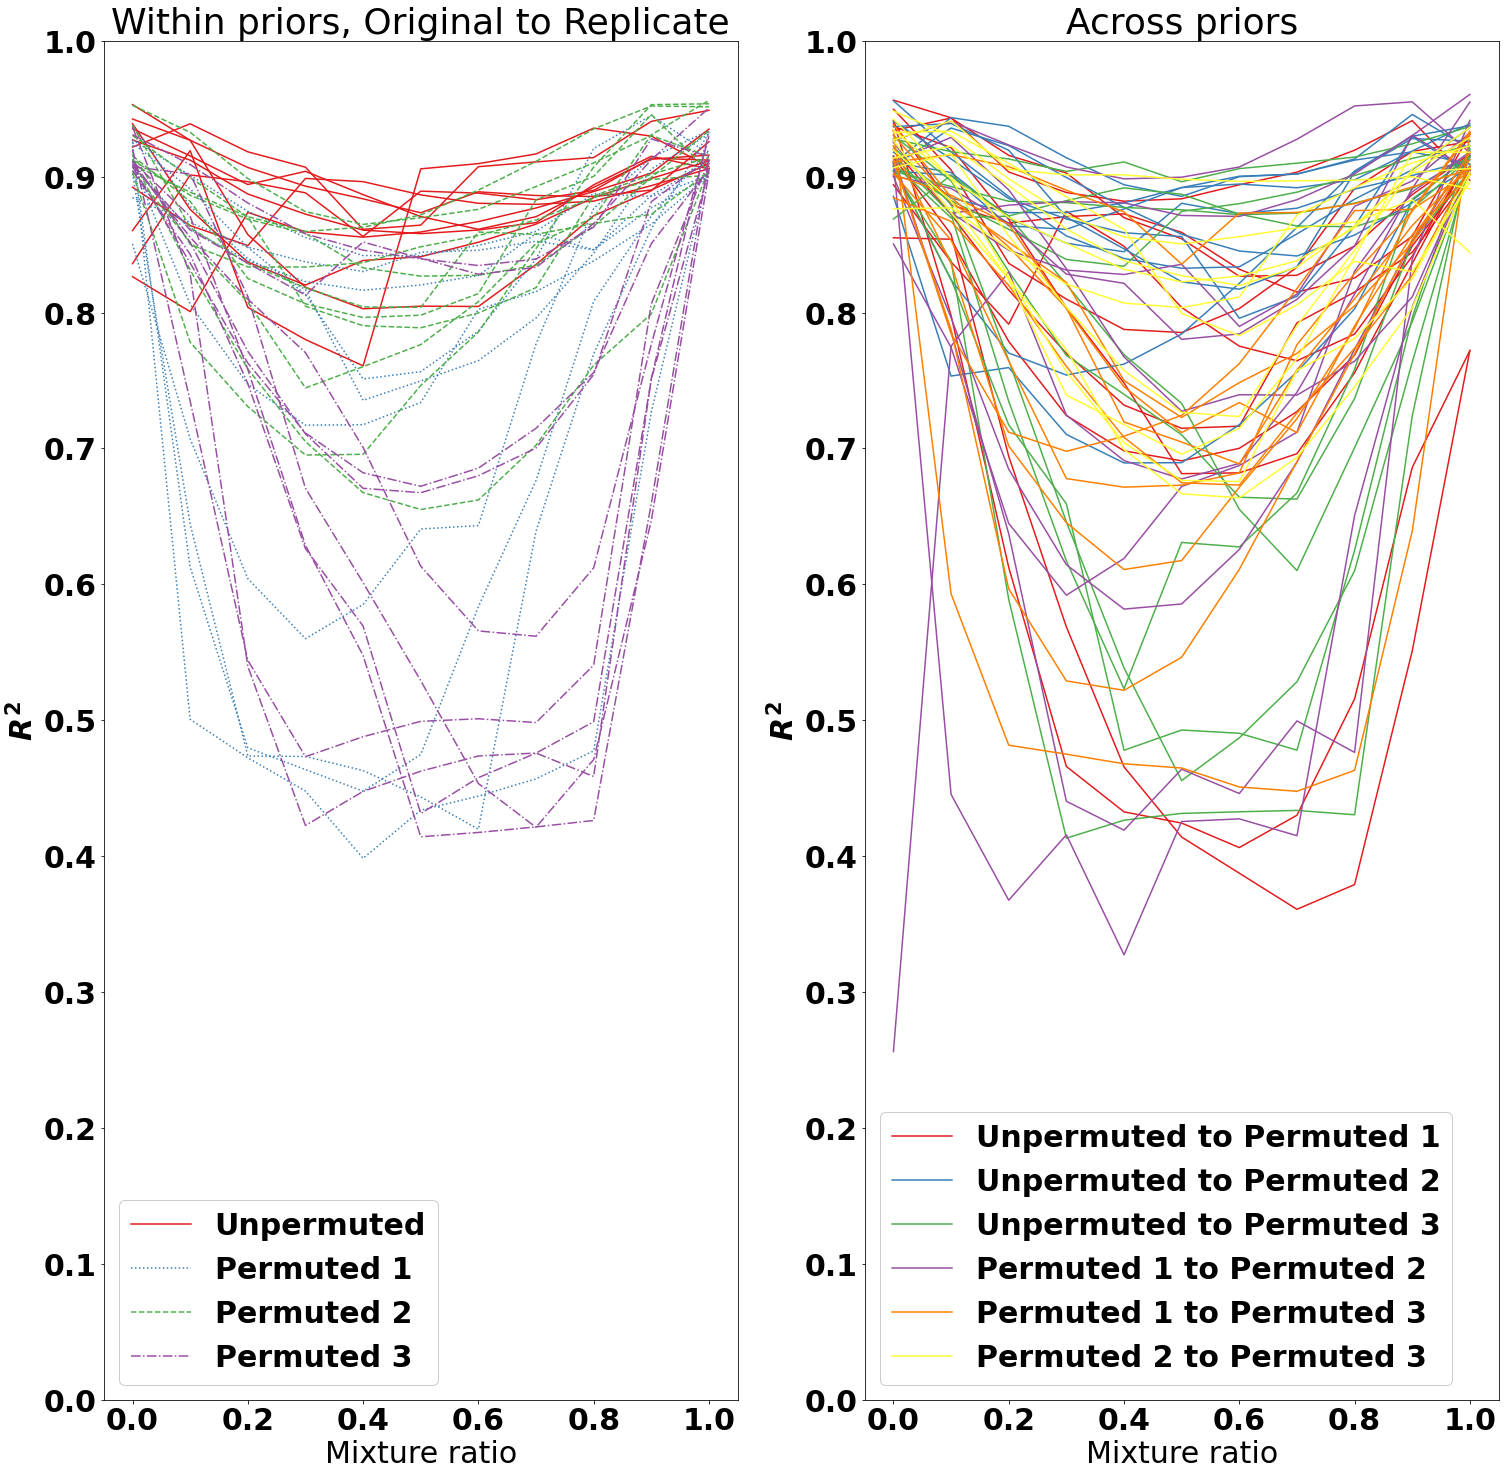

In [64]:
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
plt.figure(figsize=(25,25))

intra_color_dict = {origin: plt.cm.Set1(i) for i, origin in enumerate(intra_linestyle_dict.keys())}
plt.subplot(1,2,1)
for origin, results in intra_interpolation.iteritems():
    for result in results:
        plt.plot(result['ratio'],-result['distances'],linestyle = intra_linestyle_dict[origin],
                 color=intra_color_dict[origin],label = origin)
        plt.xlabel('Mixture ratio')
        plt.ylabel('$R^2$')
        plt.ylim([0,1])
f = lambda l,c, label: plt.plot([],[],linestyle=l, color=c, label=label)[0]
handles = [f(l=intra_linestyle_dict[origin], c=intra_color_dict[origin], label = proper_names[origin]) 
           for origin in intra_linestyle_dict.keys()]
plt.legend(handles=handles, loc=3, framealpha=1)
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Within priors, Original to Replicate")
#####
plt.subplot(1,2,2)
for origin_pair, results in inter_interpolation.iteritems():
    for result in results:
        plt.plot(result['ratio'],-result['distances'], color=inter_color_dict[origin_pair])
        plt.xlabel('Mixture ratio')
        plt.ylabel('$R^2$')
        plt.ylim([0,1])
f = lambda c, label: plt.plot([],[], color=c, label=label)[0]
def inter_labelmaker(origin_pair):
    from_origin = origin_pair[0]
    to_origin = origin_pair[1]
    return f"{proper_names[from_origin]} to {proper_names[to_origin]}"
handles = [f(c=inter_color_dict[origin_pair], label = inter_labelmaker(origin_pair))
           for origin_pair in inter_color_dict.keys()]
plt.legend(handles=handles, loc=3, framealpha=1)
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Across priors")
plt.savefig("../figures/bayesian_interpolation.pdf")
plt.show()

In [50]:
proper_names

{'unpermuted': 'Unpermuted',
 'permuted_0': 'Permuted 1',
 'permuted_1': 'Permuted 2',
 'permuted_2': 'Permuted 3'}

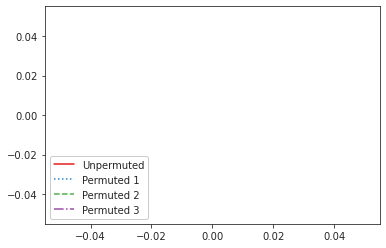

In [51]:
f = lambda l,c, label: plt.plot([],[],linestyle=l, color=c, label=label)[0]
handles = [f(l=intra_linestyle_dict[origin], c=intra_color_dict[origin], label = proper_names[origin]) 
           for origin in intra_linestyle_dict.keys()]
plt.legend(handles=handles, loc=3, framealpha=1)

Please observe: The consensus solution is not neccessarily a good one even though it is an average of better solutions.

# Results of evolutionary algorithm

In [50]:
evolution_model = pickle.load(open('../results/smcevo_gem_three_conditions_save_all_particles.pkl','rb'))

In [55]:
evolution_model.generation_size

100

In [56]:
evolution_model.generations

134

In [57]:
len(evolution_model.population)

134

In [60]:
list(map(len,evolution_model.population))[0:10]

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

In [61]:
len(evolution_model.all_particles)

6750

In [68]:
(len(evolution_model.all_particles) - 50) / evolution_model.generations # 50 new children per generations

50.0

In [67]:
len(evolution_model.all_particles) % evolution_model.generations

50

In [233]:
evolution_model.generations

134

In [64]:
type(evolution_model.all_particles[0])

dict

In [227]:
def plot_convergence_and_compare_evolution(model, reference_model, maxiter=100, legend = True):
    plot_convergence_inner(model, offset=50, generation_size=100, maxiter=maxiter, ind_start = 50, label = 'Evolutionary')
    plot_convergence_inner(reference_model, maxiter=maxiter, label = 'Bayesian')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend(loc="lower right")
    plt.tight_layout()
    return fig

In [72]:
evolution_model

In [73]:
reference_model

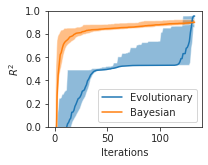

In [228]:
fig = plt.figure(figsize=(3,2.4))
evo_convergence_figure = plot_convergence_and_compare_evolution(evolution_model, reference_model, maxiter = evolution_model.generations)
plt.savefig("evo_fig.pdf")

# Effects on pathway level

In [192]:
combined_list = [reference_model]
combined_list.extend(models)
combined_index = ['unpermuted']
combined_index.extend((f'permuted_{i}') for i in range(3))
combined_df = pd.DataFrame({'model' : combined_list},index=combined_index)

In [42]:
combined_df

,model
unpermuted,<abc_etc.SMCABC object at 0x7fb6b230e9a0>
permuted_0,<abc_etc.SMCABC object at 0x7fb7365c6ca0>
permuted_1,<abc_etc.SMCABC object at 0x7fb76c0b8250>
permuted_2,<abc_etc.SMCABC object at 0x7fb73649f280>
